In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
# import Ngl
# import Nio 
# import metpy.calc as mpc
# from metpy.units import units


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
## Function from Brian Medeiros to convert times to middle of period 
#  rather than the end of the averaging period. 

def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


## Read in data

In [130]:
# ### 
# #   Third order moments not prescribed, but w'thlp' and u'w' type variables still are. w* computed in CLUBB moments
# ###

# dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/'

# # Define file names of cam history files
# hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_noThirdOrder_20minDT_HMG.3monthsFree.cam.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_noThirdOrder_20minDT_HMG.3monthsFree.cam.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_noThirdOrder_20minDT_HMG.3monthsFree.cam.h0.2015-08-09-36585.nc'])

# htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_noThirdOrder_20minDT_HTG.3monthsFree.cam.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_noThirdOrder_20minDT_HTG.3monthsFree.cam.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_noThirdOrder_20minDT_HTG.3monthsFree.cam.h0.2015-08-09-36585.nc'])

# # Define file names of clm history files 
# hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_noThirdOrder_20minDT_HMG.3monthsFree.clm2.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_noThirdOrder_20minDT_HMG.3monthsFree.clm2.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_noThirdOrder_20minDT_HMG.3monthsFree.clm2.h0.2015-08-09-36585.nc'])

# htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_noThirdOrder_20minDT_HTG.3monthsFree.clm2.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_noThirdOrder_20minDT_HTG.3monthsFree.clm2.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_noThirdOrder_20minDT_HTG.3monthsFree.clm2.h0.2015-08-09-36585.nc'])

# for iFile in range(len(hmgLNDfiles)): 
    
#     with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
#         HTGcamDS = cesm_correct_time(HTGcamDS)
#         HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
#     with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
#         HMGcamDS = cesm_correct_time(HMGcamDS)
#         HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
#     with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
#         HTGclmDS['time'] = HTGcamDS.time
#     with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
#         HMGclmDS['time'] = HMGcamDS.time
    
#     if iFile==0:
#         HTGcamDS_all = HTGcamDS 
#         HMGcamDS_all = HMGcamDS
#         HTGclmDS_all = HTGclmDS
#         HMGclmDS_all = HMGclmDS 
#     else: 
#         HTGcamDS_all = xr.concat([HTGcamDS_all, HTGcamDS], dim='time')
#         HMGcamDS_all = xr.concat([HMGcamDS_all, HMGcamDS], dim='time')
#         HTGclmDS_all = xr.concat([HTGclmDS_all,HTGclmDS], dim='time', data_vars='minimal')
#         HMGclmDS_all = xr.concat([HMGclmDS_all,HMGclmDS], dim='time', data_vars='minimal')
        
#     print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [4]:
# ### 
# #   Only prescribing thlp2, rtp2, thlprtp, and wp2. w* computed in CLUBB moments
# ###

# dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/'

# # Define file names of cam history files
# hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HMG.3monthsFree.cam.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HMG.3monthsFree.cam.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HMG.3monthsFree.cam.h0.2015-08-09-36585.nc'])

# htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HTG.3monthsFree.cam.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HTG.3monthsFree.cam.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HTG.3monthsFree.cam.h0.2015-08-09-36585.nc'])

# # Define file names of clm history files 
# hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HMG.3monthsFree.clm2.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HMG.3monthsFree.clm2.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HMG.3monthsFree.clm2.h0.2015-08-09-36585.nc'])

# htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HTG.3monthsFree.clm2.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HTG.3monthsFree.clm2.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HTG.3monthsFree.clm2.h0.2015-08-09-36585.nc'])

# for iFile in range(len(hmgLNDfiles)): 
    
#     with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
#         HTGcamDS = cesm_correct_time(HTGcamDS)
#         HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
#     with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
#         HMGcamDS = cesm_correct_time(HMGcamDS)
#         HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
#     with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
#         HTGclmDS['time'] = HTGcamDS.time
#     with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
#         HMGclmDS['time'] = HMGcamDS.time
    
#     if iFile==0:
#         HTGcamDS_all = HTGcamDS 
#         HMGcamDS_all = HMGcamDS
#         HTGclmDS_all = HTGclmDS
#         HMGclmDS_all = HMGclmDS 
#     else: 
#         HTGcamDS_all = xr.concat([HTGcamDS_all, HTGcamDS], dim='time')
#         HMGcamDS_all = xr.concat([HMGcamDS_all, HMGcamDS], dim='time')
#         HTGclmDS_all = xr.concat([HTGclmDS_all,HTGclmDS], dim='time', data_vars='minimal')
#         HMGclmDS_all = xr.concat([HMGclmDS_all,HMGclmDS], dim='time', data_vars='minimal')
        
#     print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [5]:
# ### 
# #   Only prescribing thlp2, rtp2, thlprtp, and wp2. w* computed in FluxMods, set to 0.5 if stable.
# ###

# dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/wstar_tests/'

# # Define file names of cam history files
# hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HMG_wstarPtFive.3monthsFreeRunning.cam.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HMG_wstarPtFive.3monthsFreeRunning.cam.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HMG_wstarPtFive.3monthsFreeRunning.cam.h0.2015-08-09-36585.nc'])

# htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HTG_wstarPtFive.3monthsFreeRunning.cam.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HTG_wstarPtFive.3monthsFreeRunning.cam.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HTG_wstarPtFive.3monthsFreeRunning.cam.h0.2015-08-09-36585.nc'])

# # Define file names of clm history files 
# hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HMG_wstarPtFive.3monthsFreeRunning.clm2.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HMG_wstarPtFive.3monthsFreeRunning.clm2.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HMG_wstarPtFive.3monthsFreeRunning.clm2.h0.2015-08-09-36585.nc'])

# htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HTG_wstarPtFive.3monthsFreeRunning.clm2.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HTG_wstarPtFive.3monthsFreeRunning.clm2.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlRtWp2_20minDT_HTG_wstarPtFive.3monthsFreeRunning.clm2.h0.2015-08-09-36585.nc'])

# for iFile in range(len(hmgLNDfiles)): 
    
#     with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
#         HTGcamDS = cesm_correct_time(HTGcamDS)
#         HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
#     with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
#         HMGcamDS = cesm_correct_time(HMGcamDS)
#         HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
#     with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
#         HTGclmDS['time'] = HTGcamDS.time
#     with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
#         HMGclmDS['time'] = HMGcamDS.time
    
#     if iFile==0:
#         HTGcamDS_all = HTGcamDS 
#         HMGcamDS_all = HMGcamDS
#         HTGclmDS_all = HTGclmDS
#         HMGclmDS_all = HMGclmDS 
#     else: 
#         HTGcamDS_all = xr.concat([HTGcamDS_all, HTGcamDS], dim='time')
#         HMGcamDS_all = xr.concat([HMGcamDS_all, HMGcamDS], dim='time')
#         HTGclmDS_all = xr.concat([HTGclmDS_all,HTGclmDS], dim='time', data_vars='minimal')
#         HMGclmDS_all = xr.concat([HMGclmDS_all,HMGclmDS], dim='time', data_vars='minimal')
        
#     print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [4]:
# ### 
# #   Only prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
# ###

# dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/wstar_tests/'

# # Define file names of cam history files
# hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HMG.3monthsFreeRunning.cam.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HMG.3monthsFreeRunning.cam.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HMG.3monthsFreeRunning.cam.h0.2015-08-09-36585.nc'])

# htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HTG.3monthsFreeRunning.cam.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HTG.3monthsFreeRunning.cam.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HTG.3monthsFreeRunning.cam.h0.2015-08-09-36585.nc'])

# # Define file names of clm history files 
# hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HMG.3monthsFreeRunning.clm2.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HMG.3monthsFreeRunning.clm2.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HMG.3monthsFreeRunning.clm2.h0.2015-08-09-36585.nc'])

# htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HTG.3monthsFreeRunning.clm2.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HTG.3monthsFreeRunning.clm2.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HTG.3monthsFreeRunning.clm2.h0.2015-08-09-36585.nc'])

# for iFile in range(len(hmgLNDfiles)): 
    
#     with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
#         HTGcamDS = cesm_correct_time(HTGcamDS)
#         HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
#     with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
#         HMGcamDS = cesm_correct_time(HMGcamDS)
#         HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
#     with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
#         HTGclmDS['time'] = HTGcamDS.time
#     with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
#         HMGclmDS['time'] = HMGcamDS.time
    
#     if iFile==0:
#         HTGcamDS_all = HTGcamDS 
#         HMGcamDS_all = HMGcamDS
#         HTGclmDS_all = HTGclmDS
#         HMGclmDS_all = HMGclmDS 
#     else: 
#         HTGcamDS_all = xr.concat([HTGcamDS_all, HTGcamDS], dim='time')
#         HMGcamDS_all = xr.concat([HMGcamDS_all, HMGcamDS], dim='time')
#         HTGclmDS_all = xr.concat([HTGclmDS_all,HTGclmDS], dim='time', data_vars='minimal')
#         HMGclmDS_all = xr.concat([HMGclmDS_all,HMGclmDS], dim='time', data_vars='minimal')
        
#     print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [4]:
# ### 
# #   Only prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
# #   This version uses an finidat file from June, not January 
# ###

# dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

# # Define file names of cam history files
# hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_3monthsFree.cam.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_3monthsFree.cam.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_3monthsFree.cam.h0.2015-08-09-36585.nc'])

# htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_3monthsFree.cam.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_3monthsFree.cam.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_3monthsFree.cam.h0.2015-08-09-36585.nc'])

# # Define file names of clm history files 
# hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_3monthsFree.clm2.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_3monthsFree.clm2.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_3monthsFree.clm2.h0.2015-08-09-36585.nc'])

# htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_3monthsFree.clm2.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_3monthsFree.clm2.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_3monthsFree.clm2.h0.2015-08-09-36585.nc'])

# for iFile in range(len(hmgLNDfiles)): 
    
#     with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
#         HTGcamDS = cesm_correct_time(HTGcamDS)
#         HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
#     with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
#         HMGcamDS = cesm_correct_time(HMGcamDS)
#         HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
#     with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
#         HTGclmDS['time'] = HTGcamDS.time
#     with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
#         HMGclmDS['time'] = HMGcamDS.time
    
#     if iFile==0:
#         HTGcamDS_all = HTGcamDS 
#         HMGcamDS_all = HMGcamDS
#         HTGclmDS_all = HTGclmDS
#         HMGclmDS_all = HMGclmDS 
#     else: 
#         HTGcamDS_all = xr.concat([HTGcamDS_all, HTGcamDS], dim='time')
#         HMGcamDS_all = xr.concat([HMGcamDS_all, HMGcamDS], dim='time')
#         HTGclmDS_all = xr.concat([HTGclmDS_all,HTGclmDS], dim='time', data_vars='minimal')
#         HMGclmDS_all = xr.concat([HMGclmDS_all,HMGclmDS], dim='time', data_vars='minimal')
        
#     print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [4]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

# Define file names of cam history files
hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-08-09-36585.nc'])

htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h0.2015-08-09-36585.nc'])

htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h0.2015-08-09-36585.nc'])

for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2015 = HTGcamDS 
        HMGcamDS_all2015 = HMGcamDS
        HTGclmDS_all2015 = HTGclmDS
        HMGclmDS_all2015 = HMGclmDS 
    else: 
        HTGcamDS_all2015 = xr.concat([HTGcamDS_all2015, HTGcamDS], dim='time')
        HMGcamDS_all2015 = xr.concat([HMGcamDS_all2015, HMGcamDS], dim='time')
        HTGclmDS_all2015 = xr.concat([HTGclmDS_all2015,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2015 = xr.concat([HMGclmDS_all2015,HMGclmDS], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [5]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
#
#   TEST JJA in 2016
#
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

# Define file names of cam history files
hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2016jja.cam.h0.2016-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2016jja.cam.h0.2016-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2016jja.cam.h0.2016-08-09-36585.nc'])

htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2016jja.cam.h0.2016-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2016jja.cam.h0.2016-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2016jja.cam.h0.2016-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2016jja.clm2.h0.2016-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2016jja.clm2.h0.2016-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2016jja.clm2.h0.2016-08-09-36585.nc'])

htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2016jja.clm2.h0.2016-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2016jja.clm2.h0.2016-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2016jja.clm2.h0.2016-08-09-36585.nc'])

for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2016 = HTGcamDS 
        HMGcamDS_all2016 = HMGcamDS
        HTGclmDS_all2016 = HTGclmDS
        HMGclmDS_all2016 = HMGclmDS 
    else: 
        HTGcamDS_all2016 = xr.concat([HTGcamDS_all2016, HTGcamDS], dim='time')
        HMGcamDS_all2016 = xr.concat([HMGcamDS_all2016, HMGcamDS], dim='time')
        HTGclmDS_all2016 = xr.concat([HTGclmDS_all2016,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2016 = xr.concat([HMGclmDS_all2016,HMGclmDS], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [4]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
#
#   TEST JJA in 2017
#
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

# # Define file names of cam history files
# hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2017jja.cam.h0.2017-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2017jja.cam.h0.2017-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2017jja.cam.h0.2017-08-09-36585.nc'])

# htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2017jja.cam.h0.2017-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2017jja.cam.h0.2017-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2017jja.cam.h0.2017-08-09-36585.nc'])

# # Define file names of clm history files 
# hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2017jja.clm2.h0.2017-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2017jja.clm2.h0.2017-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2017jja.clm2.h0.2017-08-09-36585.nc'])

# htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2017jja.clm2.h0.2017-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2017jja.clm2.h0.2017-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2017jja.clm2.h0.2017-08-09-36585.nc'])

# Define file names of cam history files
hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2017jjaRelaxationOn.cam.h0.2017-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2017jjaRelaxationOn.cam.h0.2017-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2017jjaRelaxationOn.cam.h0.2017-08-09-36585.nc'])

htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2017jjaRelaxationOn.cam.h0.2017-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2017jjaRelaxationOn.cam.h0.2017-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2017jjaRelaxationOn.cam.h0.2017-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2017jjaRelaxationOn.clm2.h0.2017-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2017jjaRelaxationOn.clm2.h0.2017-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2017jjaRelaxationOn.clm2.h0.2017-08-09-36585.nc'])

htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2017jjaRelaxationOn.clm2.h0.2017-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2017jjaRelaxationOn.clm2.h0.2017-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2017jjaRelaxationOn.clm2.h0.2017-08-09-36585.nc'])



for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2017 = HTGcamDS 
        HMGcamDS_all2017 = HMGcamDS
        HTGclmDS_all2017 = HTGclmDS
        HMGclmDS_all2017 = HMGclmDS 
    else: 
        HTGcamDS_all2017 = xr.concat([HTGcamDS_all2017, HTGcamDS], dim='time')
        HMGcamDS_all2017 = xr.concat([HMGcamDS_all2017, HMGcamDS], dim='time')
        HTGclmDS_all2017 = xr.concat([HTGclmDS_all2017,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2017 = xr.concat([HMGclmDS_all2017,HMGclmDS], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [ ]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
#
#   TEST JJA in 2018
#
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2018jja'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2018jja'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2018jja'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2018jja'


# Define file names of cam history files
hmgATMfiles = np.asarray([caseName_HMG+'.cam.h0.2018-05-31-84585.nc',
                          caseName_HMG+'.cam.h0.2018-07-05-60585.nc',
                          caseName_HMG+'.cam.h0.2018-08-09-36585.nc'])

htgATMfiles = np.asarray([caseName_HTG+'.cam.h0.2018-05-31-84585.nc',
                          caseName_HTG+'.cam.h0.2018-07-05-60585.nc',
                          caseName_HTG+'.cam.h0.2018-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray([caseName_HMG+'.clm2.h0.2018-05-31-84585.nc',
                          caseName_HMG+'.clm2.h0.2018-07-05-60585.nc',
                          caseName_HMG+'.clm2.h0.2018-08-09-36585.nc'])

htgLNDfiles = np.asarray([caseName_HTG+'.clm2.h0.2018-05-31-84585.nc',
                          caseName_HTG+'.clm2.h0.2018-07-05-60585.nc',
                          caseName_HTG+'.clm2.h0.2018-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray([caseName_HMG+'.clm2.h1.2018-05-31-84585.nc',
                               caseName_HMG+'.clm2.h1.2018-07-05-60585.nc',
                               caseName_HMG+'.clm2.h1.2018-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray([caseName_HTG+'.clm2.h1.2018-05-31-84585.nc',
                               caseName_HTG+'.clm2.h1.2018-07-05-60585.nc',
                               caseName_HTG+'.clm2.h1.2018-08-09-36585.nc'])


for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
        
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2018 = HTGcamDS 
        HMGcamDS_all2018 = HMGcamDS
        HTGclmDS_all2018 = HTGclmDS
        HMGclmDS_all2018 = HMGclmDS 
        HTGclmDSpatch_all2018 = HTGclmDS_patch
        HMGclmDSpatch_all2018 = HMGclmDS_patch
    else: 
        HTGcamDS_all2018 = xr.concat([HTGcamDS_all2018, HTGcamDS], dim='time')
        HMGcamDS_all2018 = xr.concat([HMGcamDS_all2018, HMGcamDS], dim='time')
        HTGclmDS_all2018 = xr.concat([HTGclmDS_all2018,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2018 = xr.concat([HMGclmDS_all2018,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2018 = xr.concat([HTGclmDSpatch_all2018,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2018 = xr.concat([HMGclmDSpatch_all2018,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

In [5]:
## Choose which year to analyze below

selYear = 2017

if selYear==2015: 
    HTGcamDS_all = HTGcamDS_all2015
    HMGcamDS_all = HMGcamDS_all2015
    HTGclmDS_all = HTGclmDS_all2015
    HMGclmDS_all = HMGclmDS_all2015 
elif selYear==2016:
    HTGcamDS_all = HTGcamDS_all2016
    HMGcamDS_all = HMGcamDS_all2016
    HTGclmDS_all = HTGclmDS_all2016
    HMGclmDS_all = HMGclmDS_all2016    
elif selYear==2017:
    HTGcamDS_all = HTGcamDS_all2017
    HMGcamDS_all = HMGcamDS_all2017
    HTGclmDS_all = HTGclmDS_all2017
    HMGclmDS_all = HMGclmDS_all2017 
elif selYear=='all': 
    ## Discard spin up days 
    iTimeStart   = np.where(HTGcamDS_all2015.time.values >= (HTGcamDS_all2015.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2015.time.values))

    HTGcamDS_all2015 = HTGcamDS_all2015.isel(time=timeArr)
    HTGclmDS_all2015 = HTGclmDS_all2015.isel(time=timeArr)
    HMGcamDS_all2015 = HMGcamDS_all2015.isel(time=timeArr)
    HMGclmDS_all2015 = HMGclmDS_all2015.isel(time=timeArr)
    
    iTimeStart   = np.where(HTGcamDS_all2016.time.values >= (HTGcamDS_all2016.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2016.time.values))

    HTGcamDS_all2016 = HTGcamDS_all2016.isel(time=timeArr)
    HTGclmDS_all2016 = HTGclmDS_all2016.isel(time=timeArr)
    HMGcamDS_all2016 = HMGcamDS_all2016.isel(time=timeArr)
    HMGclmDS_all2016 = HMGclmDS_all2016.isel(time=timeArr)
    
    iTimeStart   = np.where(HTGcamDS_all2017.time.values >= (HTGcamDS_all2017.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2017.time.values))

    HTGcamDS_all2017 = HTGcamDS_all2017.isel(time=timeArr)
    HTGclmDS_all2017 = HTGclmDS_all2017.isel(time=timeArr)
    HMGcamDS_all2017 = HMGcamDS_all2017.isel(time=timeArr)
    HMGclmDS_all2017 = HMGclmDS_all2017.isel(time=timeArr)

    ## Concat into one giant DS
    HTGcamDS_all = xr.concat([HTGcamDS_all2015, HTGcamDS_all2016, HTGcamDS_all2017], dim='time')
    HMGcamDS_all = xr.concat([HMGcamDS_all2015, HMGcamDS_all2016, HMGcamDS_all2017], dim='time')
    HTGclmDS_all = xr.concat([HTGclmDS_all2015, HTGclmDS_all2016, HTGclmDS_all2017], dim='time')
    HMGclmDS_all = xr.concat([HMGclmDS_all2015, HMGclmDS_all2016, HMGclmDS_all2017], dim='time')
    

**Sanity check that time 0 is not different between the two**

(1000.0, 200.0)

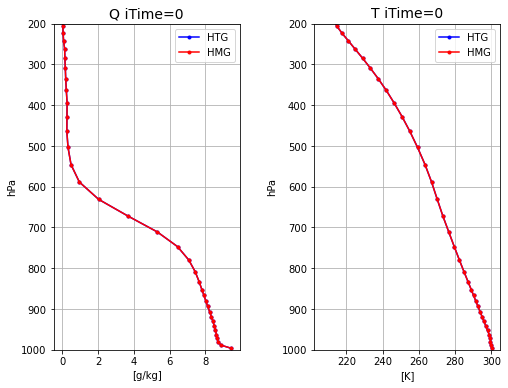

In [6]:
fig,axs = plt.subplots(1,2, figsize=(8,6))
axs = axs.ravel()
fig.subplots_adjust(wspace=0.4)

varPlot = 'Q'
axs[0].plot(HTGcamDS_all[varPlot].values[0,:,0,0]*1000, HTGcamDS_all.lev.values,'b.-', label='HTG')
axs[0].plot(HMGcamDS_all[varPlot].values[0,:,0,0]*1000, HMGcamDS_all.lev.values,'r.-', label='HMG')
axs[0].legend()
axs[0].invert_yaxis()
axs[0].set_title(varPlot+' iTime=0', fontsize=14)
axs[0].set_xlabel('[g/kg]')
axs[0].set_ylabel('hPa')
axs[0].grid()
axs[0].set_ylim([1000,200])

varPlot = 'T'
axs[1].plot(HTGcamDS_all[varPlot].values[0,:,0,0], HTGcamDS_all.lev.values,'b.-', label='HTG')
axs[1].plot(HMGcamDS_all[varPlot].values[0,:,0,0], HMGcamDS_all.lev.values,'r.-', label='HMG')
axs[1].legend()
axs[1].invert_yaxis()
axs[1].set_title(varPlot+' iTime=0', fontsize=14)
axs[1].set_xlabel('[K]')
axs[1].set_ylabel('hPa')
axs[1].grid()
axs[1].set_ylim([1000,200])

**Print some summary info about the two runs**

In [7]:
print('Sfc Q diff, time 0 = ', (HTGcamDS_all['Q'].values[0,-1,0,0]*1000) - (HMGcamDS_all['Q'].values[0,-1,0,0]*1000), ' g/kg')
print('Sfc T diff, time 0 = ', HTGcamDS_all['T'].values[0,-1,0,0] - HMGcamDS_all['T'].values[0,-1,0,0] , ' K')
print()
print('Sfc+1 Q diff, time 0 = ', (HTGcamDS_all['Q'].values[0,-2,0,0]*1000) - (HMGcamDS_all['Q'].values[0,-2,0,0]*1000), ' g/kg')
print('Sfc+1 T diff, time 0 = ', HTGcamDS_all['T'].values[0,-2,0,0] - HMGcamDS_all['T'].values[0,-2,0,0], ' K')



Sfc Q diff, time 0 =  0.000951811671257019  g/kg
Sfc T diff, time 0 =  -0.0021972656  K

Sfc+1 Q diff, time 0 =  -0.0006705522537231445  g/kg
Sfc+1 T diff, time 0 =  0.0009765625  K


In [233]:
print('Year: 2015')
print('HMG:  Mean TREFHT = %.4f %s' % (np.nanmean(HMGcamDS_all2015['TREFHT'].values), HMGcamDS_all2015['TREFHT'].units) )
print('HTG:  Mean TREFHT = %.4f %s' % (np.nanmean(HTGcamDS_all2015['TREFHT'].values), HTGcamDS_all2015['TREFHT'].units) )
print('HTG-HMG: %17.4f' % ((np.nanmean(HTGcamDS_all2015['TREFHT'].values) - (np.nanmean(HMGcamDS_all2015['TREFHT'].values)))))
print()
print('HMG:  Mean QREFHT = %.4f %s' % (np.nanmean(HMGcamDS_all2015['QREFHT'].values), HMGcamDS_all2015['QREFHT'].units) )
print('HTG:  Mean QREFHT = %.4f %s' % (np.nanmean(HTGcamDS_all2015['QREFHT'].values), HTGcamDS_all2015['QREFHT'].units) )
print('HTG-HMG: %17.4f' % ((np.nanmean(HTGcamDS_all2015['QREFHT'].values) - (np.nanmean(HMGcamDS_all2015['QREFHT'].values)))))
print()
print('HMG:  Mean rainfall = %.4e %s' % (np.nanmean(HMGclmDS_all2015['RAIN'].values), HMGclmDS_all2015['RAIN'].units) )
print('HTG:  Mean rainfall = %.4e %s' % (np.nanmean(HTGclmDS_all2015['RAIN'].values), HTGclmDS_all2015['RAIN'].units) )
print('HTG-HMG: %17.4e' % ((np.nanmean(HTGclmDS_all2015['RAIN'].values) - (np.nanmean(HMGclmDS_all2015['RAIN'].values)))))
print()
print('HMG:  Mean ET = %.4e %s' % (np.nanmean(HMGclmDS_all2015['QFLX_EVAP_TOT'].values), HMGclmDS_all2015['QFLX_EVAP_TOT'].units) )
print('HTG:  Mean ET = %.4e %s' % (np.nanmean(HTGclmDS_all2015['QFLX_EVAP_TOT'].values), HTGclmDS_all2015['QFLX_EVAP_TOT'].units) )
print('HTG-HMG: %17.4e' % ((np.nanmean(HTGclmDS_all2015['QFLX_EVAP_TOT'].values) - (np.nanmean(HMGclmDS_all2015['QFLX_EVAP_TOT'].values)))))
print()
print('HMG:  MeanP-MeanE = %.4e mm/s' % (np.nanmean(HMGclmDS_all2015['RAIN'].values) - np.nanmean(HMGclmDS_all2015['QFLX_EVAP_TOT'].values)))
print('HTG:  MeanP-MeanE = %.4e mm/s' % (np.nanmean(HTGclmDS_all2015['RAIN'].values) - np.nanmean(HTGclmDS_all2015['QFLX_EVAP_TOT'].values)))


print('\n\n')

print('Year: 2016')
print('HMG:  Mean TREFHT = %.4f %s' % (np.nanmean(HMGcamDS_all2016['TREFHT'].values), HMGcamDS_all2016['TREFHT'].units) )
print('HTG:  Mean TREFHT = %.4f %s' % (np.nanmean(HTGcamDS_all2016['TREFHT'].values), HTGcamDS_all2016['TREFHT'].units) )
print('HTG-HMG: %17.4f' % ((np.nanmean(HTGcamDS_all2016['TREFHT'].values) - (np.nanmean(HMGcamDS_all2016['TREFHT'].values)))))
print()
print('HMG:  Mean QREFHT = %.4f %s' % (np.nanmean(HMGcamDS_all2016['QREFHT'].values), HMGcamDS_all2016['QREFHT'].units) )
print('HTG:  Mean QREFHT = %.4f %s' % (np.nanmean(HTGcamDS_all2016['QREFHT'].values), HTGcamDS_all2016['QREFHT'].units) )
print('HTG-HMG: %17.4f' % ((np.nanmean(HTGcamDS_all2016['QREFHT'].values) - (np.nanmean(HMGcamDS_all2016['QREFHT'].values)))))
print()
print('HMG:  Mean rainfall = %.4e %s' % (np.nanmean(HMGclmDS_all2016['RAIN'].values), HMGclmDS_all2016['RAIN'].units) )
print('HTG:  Mean rainfall = %.4e %s' % (np.nanmean(HTGclmDS_all2016['RAIN'].values), HTGclmDS_all2016['RAIN'].units) )
print('HTG-HMG: %17.4e' % ((np.nanmean(HTGclmDS_all2016['RAIN'].values) - (np.nanmean(HMGclmDS_all2016['RAIN'].values)))))
print()
print('HMG:  Mean ET = %.4e %s' % (np.nanmean(HMGclmDS_all2016['QFLX_EVAP_TOT'].values), HMGclmDS_all2016['QFLX_EVAP_TOT'].units) )
print('HTG:  Mean ET = %.4e %s' % (np.nanmean(HTGclmDS_all2016['QFLX_EVAP_TOT'].values), HTGclmDS_all2016['QFLX_EVAP_TOT'].units) )
print('HTG-HMG: %17.4e' % ((np.nanmean(HTGclmDS_all2016['QFLX_EVAP_TOT'].values) - (np.nanmean(HMGclmDS_all2016['QFLX_EVAP_TOT'].values)))))
print()
print('HMG:  MeanP-MeanE = %.4e mm/s' % (np.nanmean(HMGclmDS_all2016['RAIN'].values) - np.nanmean(HMGclmDS_all2016['QFLX_EVAP_TOT'].values)))
print('HTG:  MeanP-MeanE = %.4e mm/s' % (np.nanmean(HTGclmDS_all2016['RAIN'].values) - np.nanmean(HTGclmDS_all2016['QFLX_EVAP_TOT'].values)))





Year: 2015
HMG:  Mean TREFHT = 306.4380 K
HTG:  Mean TREFHT = 305.0998 K
HTG-HMG:           -1.3383

HMG:  Mean QREFHT = 0.0189 kg/kg
HTG:  Mean QREFHT = 0.0179 kg/kg
HTG-HMG:           -0.0009

HMG:  Mean rainfall = 4.5211e-05 mm/s
HTG:  Mean rainfall = 4.4428e-05 mm/s
HTG-HMG:       -7.8297e-07

HMG:  Mean ET = 3.7331e-05 kg m-2 s-1
HTG:  Mean ET = 3.6660e-05 kg m-2 s-1
HTG-HMG:       -6.7016e-07

HMG:  MeanP-MeanE = 7.8801e-06 mm/s
HTG:  MeanP-MeanE = 7.7673e-06 mm/s



Year: 2016
HMG:  Mean TREFHT = 302.0318 K
HTG:  Mean TREFHT = 302.8772 K
HTG-HMG:            0.8454

HMG:  Mean QREFHT = 0.0172 kg/kg
HTG:  Mean QREFHT = 0.0182 kg/kg
HTG-HMG:            0.0009

HMG:  Mean rainfall = 4.2545e-05 mm/s
HTG:  Mean rainfall = 4.6010e-05 mm/s
HTG-HMG:        3.4654e-06

HMG:  Mean ET = 3.6724e-05 kg m-2 s-1
HTG:  Mean ET = 3.8737e-05 kg m-2 s-1
HTG-HMG:        2.0135e-06

HMG:  MeanP-MeanE = 5.8210e-06 mm/s
HTG:  MeanP-MeanE = 7.2728e-06 mm/s


#### Make a few more plots to try and get at mean state differences

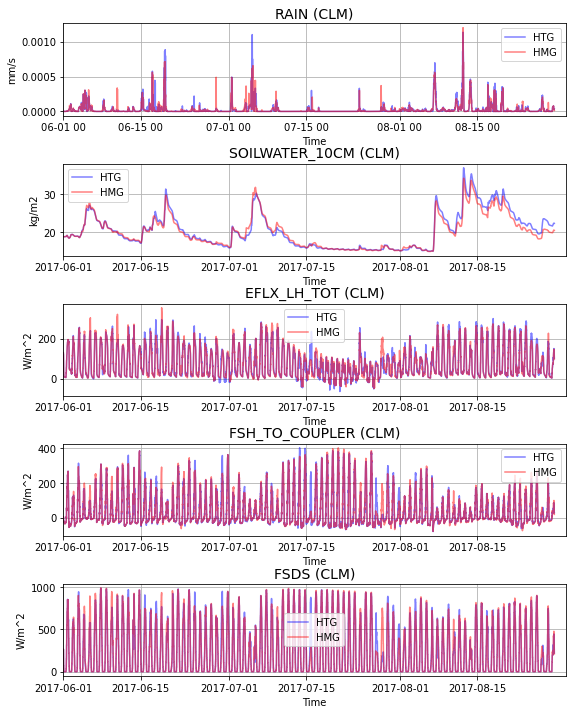

In [8]:
fig,axs = plt.subplots(5,1, figsize=(9,12))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.52)

axs[0].plot(HTGclmDS_all.time.values, HTGclmDS_all['RAIN'].values,'b-', alpha=0.5,  label='HTG')
axs[0].plot(HMGclmDS_all.time.values, HMGclmDS_all['RAIN'].values, 'r-',alpha=0.5,label='HMG')
axs[0].legend()
axs[0].set_title('RAIN (CLM)', fontsize=14)
axs[0].set_ylabel(HTGclmDS_all['RAIN'].units)

axs[1].plot(HTGclmDS_all.time.values, HTGclmDS_all['SOILWATER_10CM'].values,'b-', alpha=0.5,label='HTG')
axs[1].plot(HMGclmDS_all.time.values, HMGclmDS_all['SOILWATER_10CM'].values, 'r-',alpha=0.5,label='HMG')
axs[1].legend()
axs[1].set_title('SOILWATER_10CM (CLM)', fontsize=14)
axs[1].set_ylabel(HTGclmDS_all['SOILWATER_10CM'].units)

axs[2].plot(HTGclmDS_all.time.values, HTGclmDS_all['EFLX_LH_TOT'].values,'b-', alpha=0.5,label='HTG')
axs[2].plot(HMGclmDS_all.time.values, HMGclmDS_all['EFLX_LH_TOT'].values, 'r-',alpha=0.5,label='HMG')
axs[2].legend()
axs[2].set_title('EFLX_LH_TOT (CLM)', fontsize=14)
axs[2].set_ylabel(HTGclmDS_all['EFLX_LH_TOT'].units)

axs[3].plot(HTGclmDS_all.time.values, HTGclmDS_all['FSH_TO_COUPLER'].values,'b-', alpha=0.5,label='HTG')
axs[3].plot(HMGclmDS_all.time.values, HMGclmDS_all['FSH_TO_COUPLER'].values, 'r-',alpha=0.5,label='HMG')
axs[3].legend()
axs[3].set_title('FSH_TO_COUPLER (CLM)', fontsize=14)
axs[3].set_ylabel(HTGclmDS_all['FSH_TO_COUPLER'].units)

axs[4].plot(HTGclmDS_all.time.values, HTGclmDS_all['FSDS'].values,'b-', alpha=0.5,label='HTG')
axs[4].plot(HMGclmDS_all.time.values, HMGclmDS_all['FSDS'].values, 'r-',alpha=0.5,label='HMG')
axs[4].legend()
axs[4].set_title('FSDS (CLM)', fontsize=14)
axs[4].set_ylabel(HTGclmDS_all['FSDS'].units)

# Set the options that are consistent across subplots
axs[0].set_xlabel('Time')
axs[1].set_xlabel('Time')
axs[2].set_xlabel('Time')
axs[3].set_xlabel('Time')
axs[4].set_xlabel('Time')

axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()
axs[4].grid()

startDay   = 1
startMonth = 6
startHr    = 0
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs[0].set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
    axs[1].set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
    axs[2].set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
    axs[3].set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
    axs[4].set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017:
    axs[0].set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
    axs[1].set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
    axs[2].set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
    axs[3].set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
    axs[4].set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else:
    axs[0].set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
    axs[1].set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
    axs[2].set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
    axs[3].set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
    axs[4].set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 



# axs.set_xlim([datetime.date(2015,5,31), datetime.date(2015,6,4)])
# axs[0].set_xlim([datetime.date(2016,5,31), datetime.date(2016,6,3)])
# axs.set_ylim([15,30])



Text(0.5, 0, 'Time')

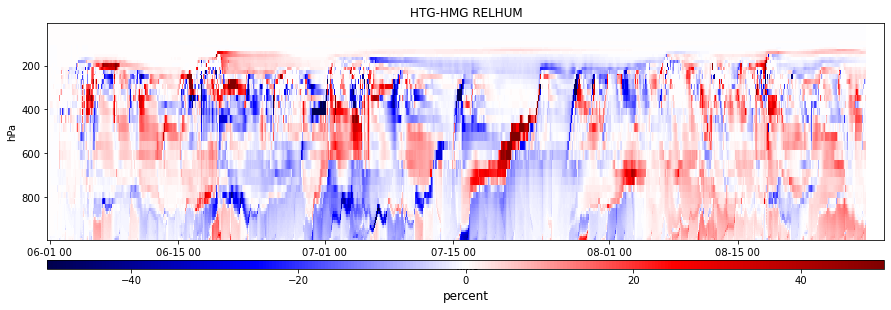

In [10]:
varPlot = 'RELHUM'
diffVar = (HTGcamDS_all[varPlot].values[:,:,0,0]) - (HMGcamDS_all[varPlot].values[:,:,0,0])

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar),
                               vmin=-50, vmax=50,
                              #levels=np.arange(-1.5, 1.55, 0.05),
                       cmap = 'seismic')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 

axs.invert_yaxis()

axs.set_title('HTG-HMG '+varPlot, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')



Text(0.5, 0, 'Time')

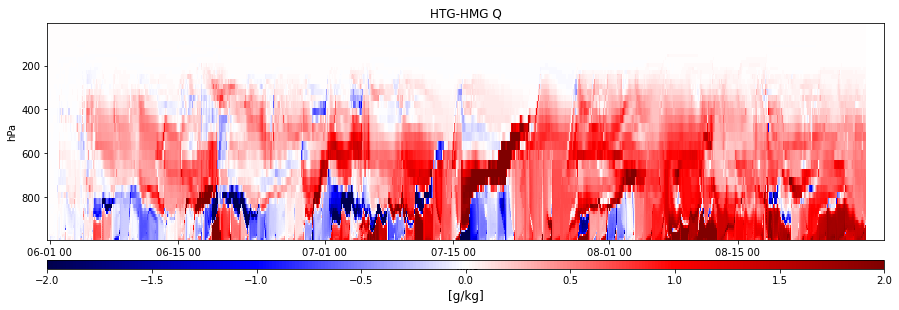

In [9]:
varPlot = 'Q'
diffVar = (HTGcamDS_all[varPlot].values[:,:,0,0]*1000.0) - (HMGcamDS_all[varPlot].values[:,:,0,0]*1000.0)

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar),
                               vmin=-2, vmax=2,
                              #levels=np.arange(-1.5, 1.55, 0.05),
                       cmap = 'seismic')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[g/kg]',fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 

axs.invert_yaxis()

axs.set_title('HTG-HMG '+varPlot, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')


Text(0.5, 0, 'Time')

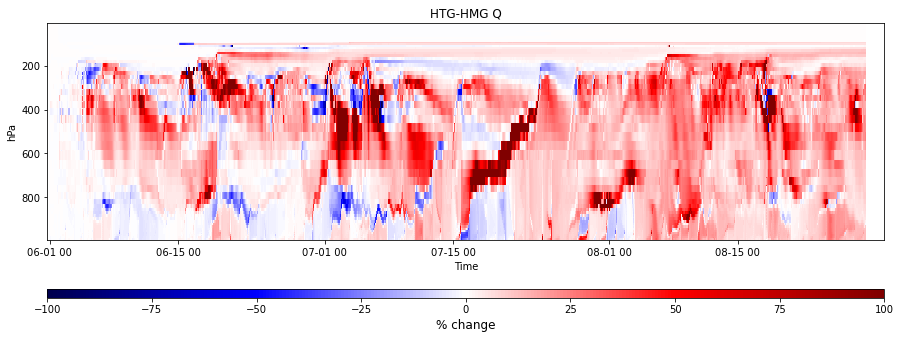

In [11]:
varPlot = 'Q'
diffVar = ((HTGcamDS_all[varPlot].values[:,:,0,0]*1000.0) - (HMGcamDS_all[varPlot].values[:,:,0,0]*1000.0))/(HMGcamDS_all[varPlot].values[:,:,0,0]*1000.0)

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar*100),
                               vmin=-100, vmax=100,
                              #levels=np.arange(-1.5, 1.55, 0.05),
                       cmap = 'seismic')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('% change',fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 

axs.invert_yaxis()

axs.set_title('HTG-HMG '+varPlot, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')



Text(0.5, 0, 'Time')

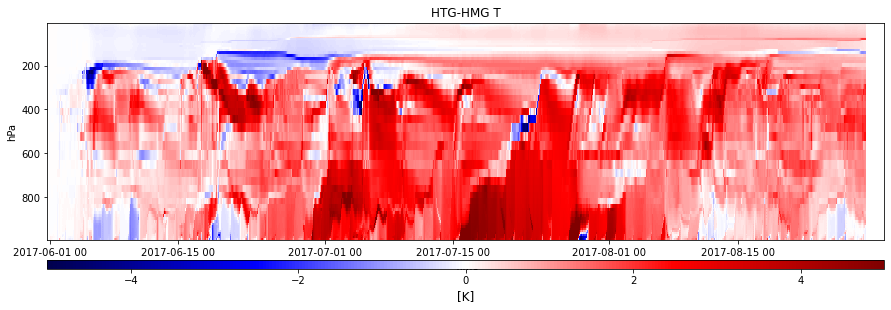

In [12]:
varPlot = 'T'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar),
                                vmin=-5, vmax=5,
                                #levels=np.arange(-2,2.1,0.1),
                               cmap = 'seismic')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[K]',fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG '+varPlot, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')


Text(0.5, 0, 'Time')

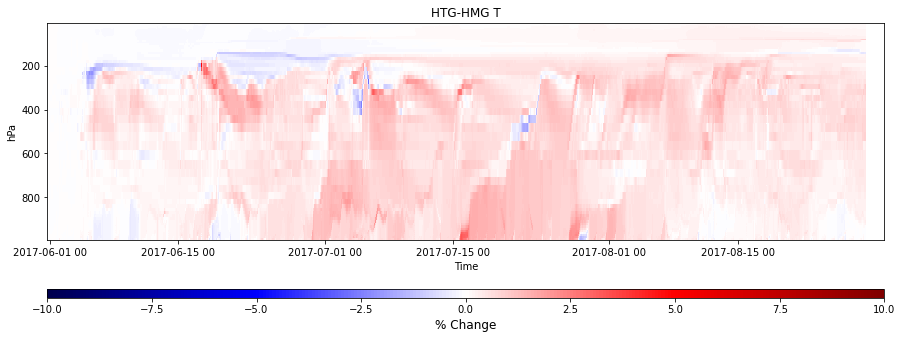

In [13]:
varPlot = 'T'
diffVar = (HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0])/HMGcamDS_all[varPlot].values[:,:,0,0]



fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar*100),
                                vmin=-10, vmax=10,
                                #levels=np.arange(-2,2.1,0.1),
                               cmap = 'seismic')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('% Change',fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG '+varPlot, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')



(3.0, 0.0)

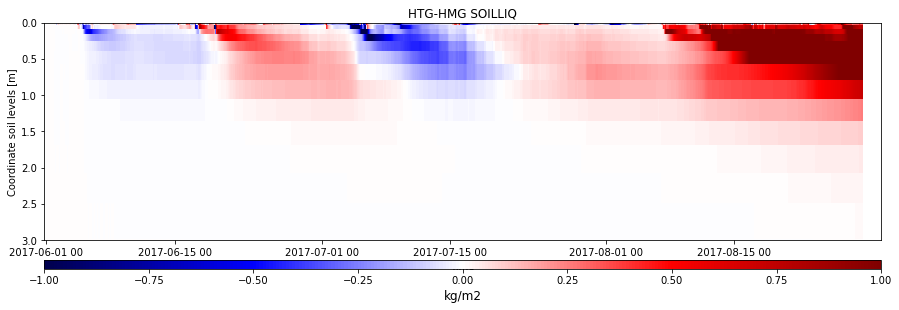

In [14]:
varPlot = 'SOILLIQ'
diffVar = HTGclmDS_all[varPlot].values[:,:,0] - HMGclmDS_all[varPlot].values[:,:,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGclmDS_all.time.values, HTGclmDS_all.levsoi.values, np.transpose(diffVar),
                                vmin=-1, vmax=1,
                                #levels=np.arange(-1,1.1,0.1),
                       cmap = 'seismic')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGclmDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])


# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
    
axs.invert_yaxis()

axs.set_title('HTG-HMG '+varPlot, fontsize=12)
axs.set_ylabel('Coordinate soil levels [m]')
axs.set_xlabel('Time')
axs.set_ylim([3,0])



Text(0.5, 0, 'Time')

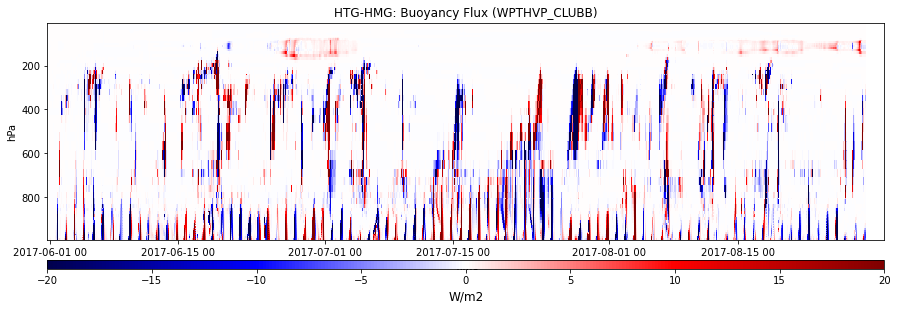

In [244]:
varPlot = 'WPTHVP_CLUBB'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar),
                                vmin=-20, vmax=20,
                                #levels=np.arange(-2,2.1,0.1),
                               cmap = 'seismic')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG: '+HTGcamDS_all[varPlot].long_name+' ('+varPlot+')', fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')



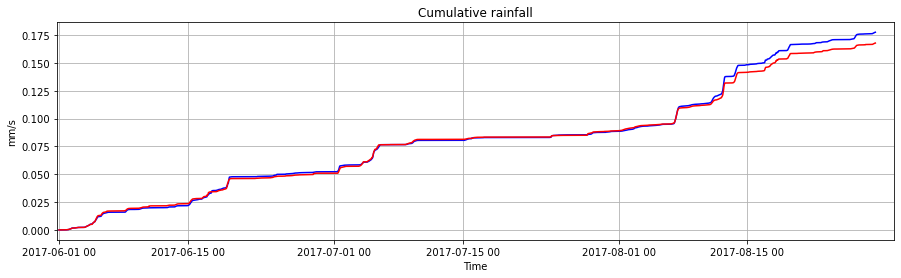

In [15]:
## CDF of rainfall over the summer 
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(HTGclmDS_all.time.values, HTGclmDS_all.RAIN.cumsum(dim='time'),'b-',label='HTG')
axs.plot(HMGclmDS_all.time.values, HMGclmDS_all.RAIN.cumsum(dim='time'),'r-',label='HMG')

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
    

axs.set_title('Cumulative rainfall', fontsize=12)
axs.set_ylabel(HTGclmDS_all.RAIN.units)
axs.set_xlabel('Time')

axs.grid()


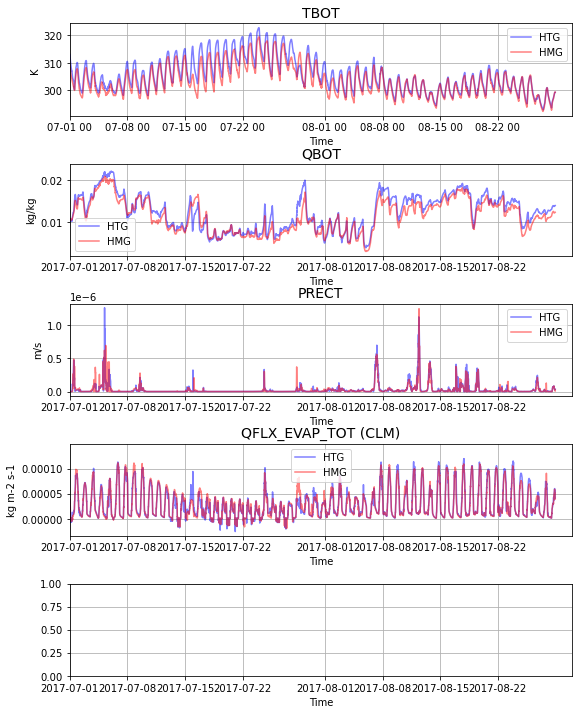

In [246]:
fig,axs = plt.subplots(5,1, figsize=(9,12))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.52)

axs[0].plot(HTGcamDS_all.time.values, HTGcamDS_all['T'].values[:,-1,0,0], 'b-', alpha=0.5, label='HTG')
axs[0].plot(HMGcamDS_all.time.values, HMGcamDS_all['T'].values[:,-1,0,0], 'r-', alpha=0.5, label='HMG')
axs[0].legend()
axs[0].set_title('TBOT', fontsize=14)
axs[0].set_ylabel(HTGcamDS_all['T'].units)

axs[1].plot(HTGcamDS_all.time.values, HTGcamDS_all['Q'].values[:,-1,0,0], 'b-', alpha=0.5, label='HTG')
axs[1].plot(HMGcamDS_all.time.values, HMGcamDS_all['Q'].values[:,-1,0,0], 'r-', alpha=0.5, label='HMG')
axs[1].legend()
axs[1].set_title('QBOT', fontsize=14)
axs[1].set_ylabel(HTGcamDS_all['Q'].units)

axs[2].plot(HTGcamDS_all.time.values, HTGcamDS_all['PRECT'].values[:,0,0], 'b-', alpha=0.5, label='HTG')
axs[2].plot(HMGcamDS_all.time.values, HMGcamDS_all['PRECT'].values[:,0,0], 'r-', alpha=0.5, label='HMG')
axs[2].legend()
axs[2].set_title('PRECT', fontsize=14)
axs[2].set_ylabel(HTGcamDS_all['PRECT'].units)

axs[3].plot(HTGclmDS_all.time.values, HTGclmDS_all['QFLX_EVAP_TOT'].values, 'b-', alpha=0.5, label='HTG')
axs[3].plot(HMGclmDS_all.time.values, HMGclmDS_all['QFLX_EVAP_TOT'].values, 'r-', alpha=0.5, label='HMG')
axs[3].legend()
axs[3].set_title('QFLX_EVAP_TOT (CLM)', fontsize=14)
axs[3].set_ylabel(HTGclmDS_all['QFLX_EVAP_TOT'].units)

# axs[4].plot(HTGclmDS_all.time.values, HTGclmDS_all['FSDS'].values, 'b-', alpha=0.5, label='HTG')
# axs[4].plot(HMGclmDS_all.time.values, HMGclmDS_all['FSDS'].values, 'r-', alpha=0.5, label='HMG')
# axs[4].legend()
# axs[4].set_title('FSDS (CLM)', fontsize=14)
# axs[4].set_ylabel(HTGclmDS_all['FSDS'].units)

# Set the options that are consistent across subplots
axs[0].set_xlabel('Time')
axs[1].set_xlabel('Time')
axs[2].set_xlabel('Time')
axs[3].set_xlabel('Time')
axs[4].set_xlabel('Time')

axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()
axs[4].grid()

startDay   = 1
startMonth = 7
startHr    = 0
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs[0].set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
    axs[1].set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
    axs[2].set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
    axs[3].set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
    axs[4].set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs[0].set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
    axs[1].set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
    axs[2].set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
    axs[3].set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
    axs[4].set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])


else: 
    axs[0].set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
    axs[1].set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
    axs[2].set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
    axs[3].set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
    axs[4].set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
     
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 

# axs.set_xlim([datetime.date(2015,5,31), datetime.date(2015,6,4)])
# axs[0].set_xlim([datetime.date(2016,5,31), datetime.date(2016,6,3)])
# axs.set_ylim([15,30])




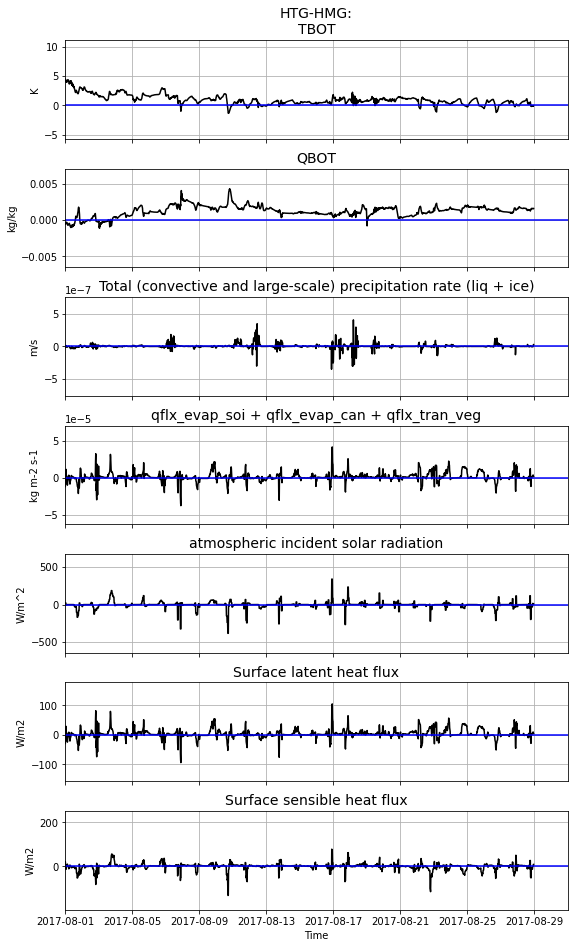

In [247]:
fig,axs = plt.subplots(7,1, figsize=(9,16))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.3)

axs[0].plot(HTGcamDS_all.time.values, HTGcamDS_all['T'].values[:,-1,0,0] - HMGcamDS_all['T'].values[:,-1,0,0], 
            'k-')
axs[0].set_title('HTG-HMG:\nTBOT', fontsize=14)
axs[0].set_ylabel(HTGcamDS_all['T'].units)

axs[1].plot(HTGcamDS_all.time.values, HTGcamDS_all['Q'].values[:,-1,0,0]-HMGcamDS_all['Q'].values[:,-1,0,0], 
            'k-')
axs[1].set_title('QBOT', fontsize=14)
axs[1].set_ylabel(HTGcamDS_all['Q'].units)

axs[2].plot(HTGcamDS_all.time.values, HTGcamDS_all['PRECT'].values[:,0,0]-HMGcamDS_all['PRECT'].values[:,0,0], 
            'k-')
axs[2].set_title(HTGcamDS_all['PRECT'].long_name, fontsize=14)
axs[2].set_ylabel(HTGcamDS_all['PRECT'].units)

axs[3].plot(HTGclmDS_all.time.values, HTGclmDS_all['QFLX_EVAP_TOT'].values-HMGclmDS_all['QFLX_EVAP_TOT'].values, 
            'k-')
axs[3].set_title(HTGclmDS_all['QFLX_EVAP_TOT'].long_name, fontsize=14)
axs[3].set_ylabel(HTGclmDS_all['QFLX_EVAP_TOT'].units)

# axs[4].plot(HTGclmDS_all.time.values, HTGclmDS_all['QOVER'].values-HMGclmDS_all['QOVER'].values, 
#             'k-')
# axs[4].set_title('HTG-HMG QOVER (CLM)', fontsize=14)
# axs[4].set_ylabel(HTGclmDS_all['QOVER'].units)

axs[4].plot(HTGclmDS_all.time.values, HTGclmDS_all['FSDS'].values-HMGclmDS_all['FSDS'].values, 
            'k-')
axs[4].set_title(HTGclmDS_all['FSDS'].long_name, fontsize=14)
axs[4].set_ylabel(HTGclmDS_all['FSDS'].units)

axs[5].plot(HTGcamDS_all.time.values, HTGcamDS_all['LHFLX'].values[:,0,0]-HMGcamDS_all['LHFLX'].values[:,0,0], 
            'k-')
axs[5].set_title(HTGcamDS_all['LHFLX'].long_name, fontsize=14)
axs[5].set_ylabel(HTGcamDS_all['LHFLX'].units)

axs[6].plot(HTGcamDS_all.time.values, HTGcamDS_all['SHFLX'].values[:,0,0]-HMGcamDS_all['SHFLX'].values[:,0,0], 
            'k-')
axs[6].set_title(HTGcamDS_all['SHFLX'].long_name, fontsize=14)
axs[6].set_ylabel(HTGcamDS_all['SHFLX'].units)

# Set the options that are consistent across subplots
axs[6].set_xlabel('Time')

axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()
axs[4].grid()
axs[5].grid()
axs[6].grid()

axs[0].axhline(0,color='b')
axs[1].axhline(0,color='b')
axs[2].axhline(0,color='b')
axs[3].axhline(0,color='b')
axs[4].axhline(0,color='b')
axs[5].axhline(0,color='b')
axs[6].axhline(0,color='b')

startDay   = 1
startMonth = 8
startHr    = 0
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs[0].set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
    axs[1].set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
    axs[2].set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
    axs[3].set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
    axs[4].set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
    axs[5].set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
    axs[6].set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs[0].set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
    axs[1].set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
    axs[2].set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
    axs[3].set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
    axs[4].set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
    axs[5].set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
    axs[6].set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs[0].set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
    axs[1].set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
    axs[2].set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
    axs[3].set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
    axs[4].set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
    axs[5].set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
    axs[6].set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])



axs[0].axes.xaxis.set_ticklabels([])
axs[1].axes.xaxis.set_ticklabels([])
axs[2].axes.xaxis.set_ticklabels([])
axs[3].axes.xaxis.set_ticklabels([])
axs[4].axes.xaxis.set_ticklabels([])
axs[5].axes.xaxis.set_ticklabels([])


# axs[6].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 

# axs.set_xlim([datetime.date(2015,5,31), datetime.date(2015,6,4)])
# axs[0].set_xlim([datetime.date(2016,5,31), datetime.date(2016,6,3)])
# axs.set_ylim([15,30])


plt.show()


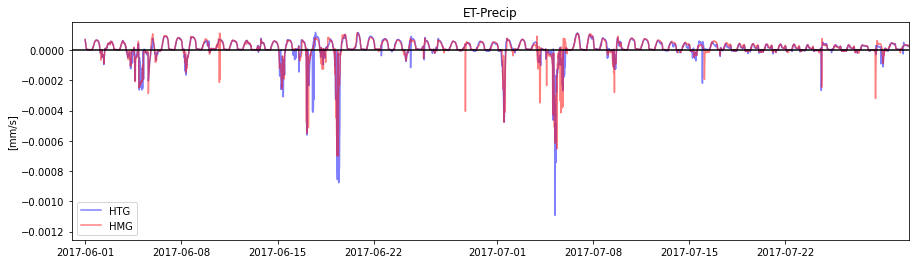

In [248]:
## Can I look at E-P?
#  (should give some estimate of large scale moisture convergence/divergence, which shouldn't be here)

## E is in units of kg /m2 /s, but that's equivalent to mm/s. 
## P is in mm/s too, so what's the balance?

htg_EminusP = HTGclmDS_all['QFLX_EVAP_TOT'].values - HTGclmDS_all['RAIN'].values
hmg_EminusP = HMGclmDS_all['QFLX_EVAP_TOT'].values - HMGclmDS_all['RAIN'].values


fig,axs = plt.subplots(1,1, figsize=(15,4))
axs.plot(HTGclmDS_all.time.values, htg_EminusP,'b-',alpha=0.5,label='HTG')
axs.plot(HMGclmDS_all.time.values, hmg_EminusP,'r-',alpha=0.5,label='HMG')
axs.legend()

axs.set_title('ET-Precip')
axs.set_ylabel('[mm/s]')
axs.axhline(0,color='k')

endDay=31
endMonth=7
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.date(2016,5,31), datetime.date(2016,endMonth,endDay)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.date(2017,5,31), datetime.date(2017,endMonth,endDay)])
else: 
    axs.set_xlim([datetime.date(2015,5,31), datetime.date(2015,endMonth,endDay)])
    

(-0.0002, 0.0016)

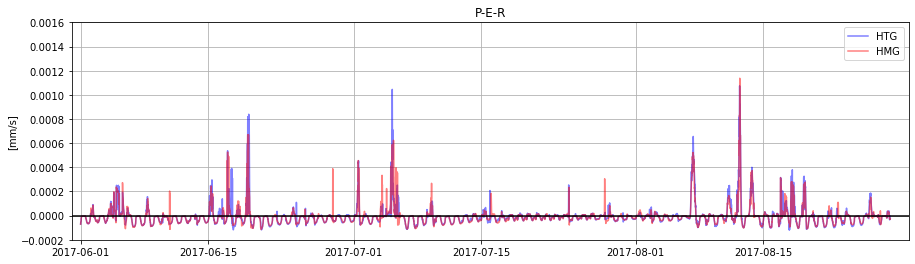

In [249]:
htg_sfcWatBalance = HTGclmDS_all['RAIN'].values - HTGclmDS_all['QFLX_EVAP_TOT'].values - HTGclmDS_all['QOVER'].values
hmg_sfcWatBalance = HMGclmDS_all['RAIN'].values - HMGclmDS_all['QFLX_EVAP_TOT'].values - HMGclmDS_all['QOVER'].values


fig,axs = plt.subplots(1,1, figsize=(15,4))
axs.plot(HTGclmDS_all.time.values, htg_sfcWatBalance,'b-',alpha=0.5,label='HTG')
axs.plot(HMGclmDS_all.time.values, hmg_sfcWatBalance,'r-',alpha=0.5,label='HMG')
axs.legend()

axs.set_title('P-E-R')
axs.set_ylabel('[mm/s]')
axs.axhline(0,color='k')

endDay=31
endMonth=8

if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.date(2016,5,31), datetime.date(2016,endMonth,endDay)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.date(2017,5,31), datetime.date(2017,endMonth,endDay)])
else: 
    axs.set_xlim([datetime.date(2015,5,31), datetime.date(2015,endMonth,endDay)])
    


axs.grid()
axs.set_ylim([-0.0002, 0.0016])

(-0.0002, 0.0016)

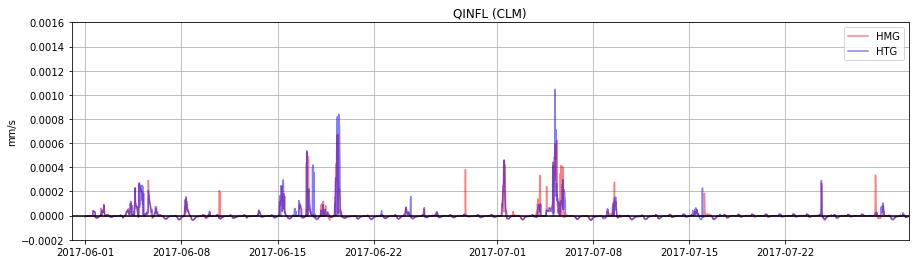

In [250]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(HMGclmDS_all.time.values, np.squeeze(HMGclmDS_all.QINFL.values), 'r-', alpha=0.5, label='HMG')
axs.plot(HTGclmDS_all.time.values, np.squeeze(HTGclmDS_all.QINFL.values), 'b-', alpha=0.5, label='HTG')
axs.legend()
axs.set_title('QINFL (CLM)')
axs.set_ylabel(HMGclmDS_all.QINFL.units)

axs.axhline(0,color='k')


endDay=31
endMonth=7
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.date(2016,5,31), datetime.date(2016,endMonth,endDay)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.date(2017,5,31), datetime.date(2017,endMonth,endDay)])
else: 
    axs.set_xlim([datetime.date(2015,5,31), datetime.date(2015,endMonth,endDay)])
    
axs.grid()
axs.set_ylim([-0.0002, 0.0016])
    

Text(0.5, 0, 'Time')

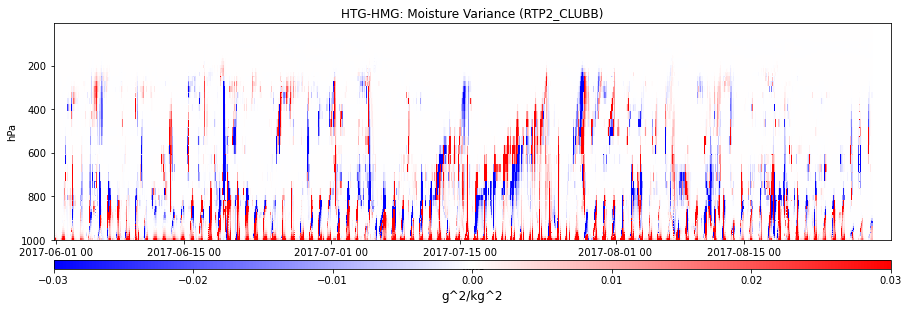

In [252]:
varPlot = 'RTP2_CLUBB'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.ilev.values, np.transpose(diffVar),
                                vmin=-3e-2, vmax=3e-2,
                                #levels=np.arange(-2,2.1,0.1),
                               cmap = 'bwr')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG: '+HTGcamDS_all[varPlot].long_name+' ('+varPlot+')', fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')


Text(0.5, 0, 'Time')

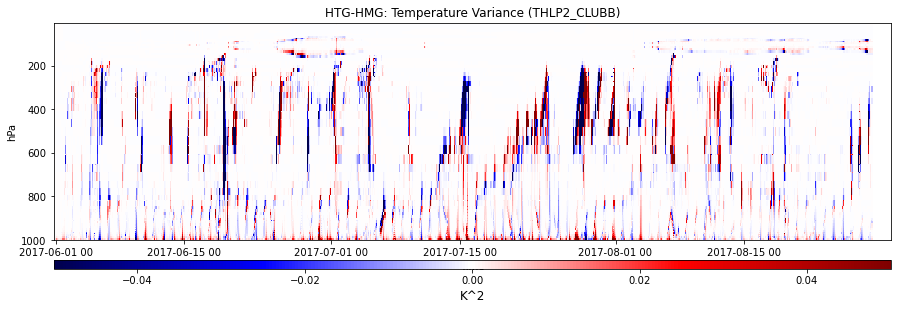

In [253]:
varPlot = 'THLP2_CLUBB'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.ilev.values, np.transpose(diffVar),
                                vmin=-5e-2, vmax=5e-2,
                                #levels=np.arange(-2,2.1,0.1),
                               cmap = 'seismic')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG: '+HTGcamDS_all[varPlot].long_name+' ('+varPlot+')', fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')





Text(0.5, 0, 'Time')

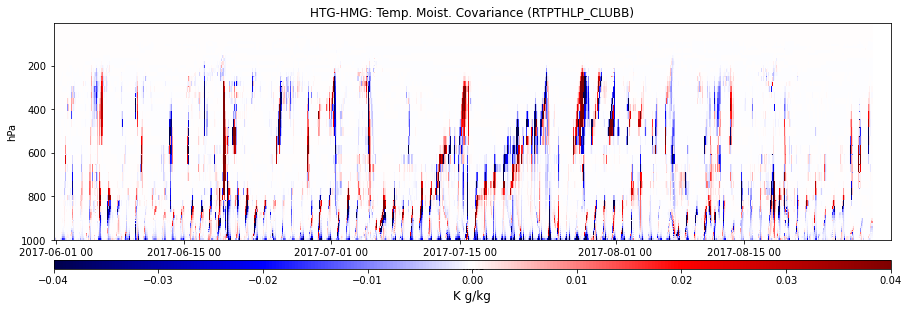

In [254]:
varPlot = 'RTPTHLP_CLUBB'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.ilev.values, np.transpose(diffVar),
                                vmin=-4e-2, vmax=4e-2,
                                #levels=np.arange(-2,2.1,0.1),
                               cmap = 'seismic')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG: '+HTGcamDS_all[varPlot].long_name+' ('+varPlot+')', fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')





Text(0.5, 0, 'Time')

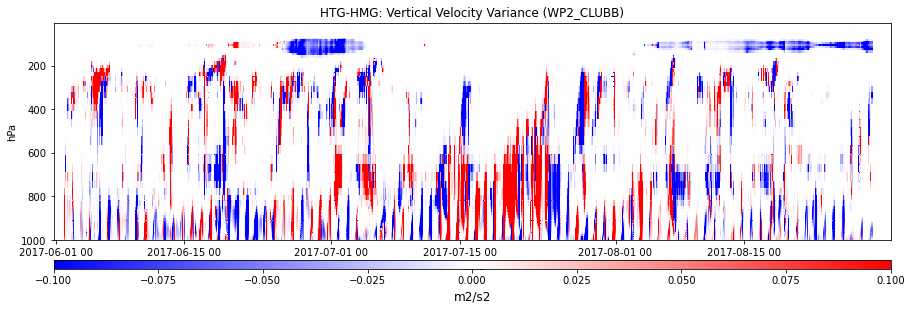

In [255]:
varPlot = 'WP2_CLUBB'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.ilev.values, np.transpose(diffVar),
                                vmin=-10e-2, vmax=10e-2,
                                #levels=np.arange(-2,2.1,0.1),
                               cmap = 'bwr')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG: '+HTGcamDS_all[varPlot].long_name+' ('+varPlot+')', fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')



Text(0.5, 0, 'Time')

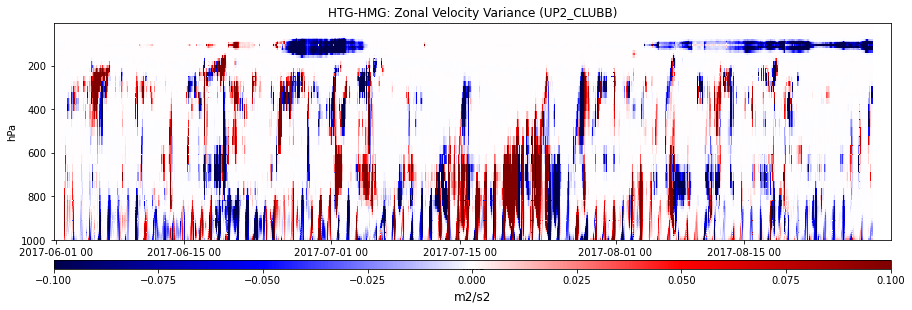

In [256]:
varPlot = 'UP2_CLUBB'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.ilev.values, np.transpose(diffVar),
                                vmin=-10e-2, vmax=10e-2,
                                #levels=np.arange(-2,2.1,0.1),
                               cmap = 'seismic')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG: '+HTGcamDS_all[varPlot].long_name+' ('+varPlot+')', fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')




Text(0.5, 0, 'Time')

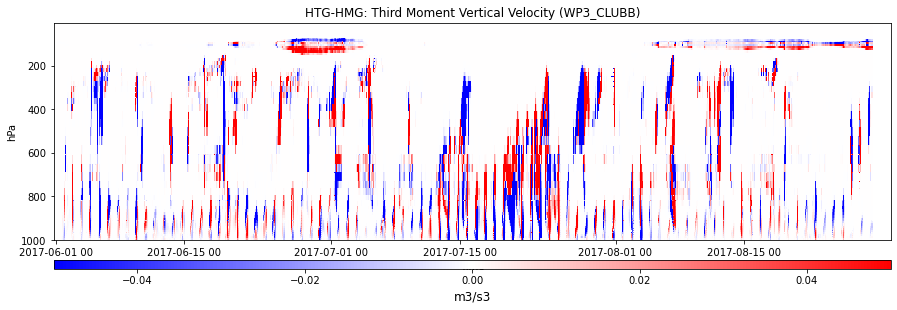

In [257]:
varPlot = 'WP3_CLUBB'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.ilev.values, np.transpose(diffVar),
                                vmin=-5e-2, vmax=5e-2,
                                #levels=np.arange(-2,2.1,0.1),
                               cmap = 'bwr')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG: '+HTGcamDS_all[varPlot].long_name+' ('+varPlot+')', fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')




Text(0.5, 0, 'Time')

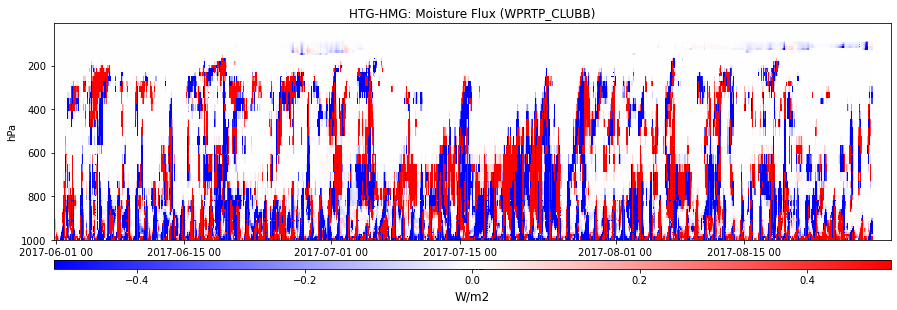

In [258]:
varPlot = 'WPRTP_CLUBB'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.ilev.values, np.transpose(diffVar),
                                vmin=-0.5, vmax=0.5,
                                #levels=np.arange(-2,2.1,0.1),
                               cmap = 'bwr')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG: '+HTGcamDS_all[varPlot].long_name+' ('+varPlot+')', fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')





Text(0.5, 0, 'Time')

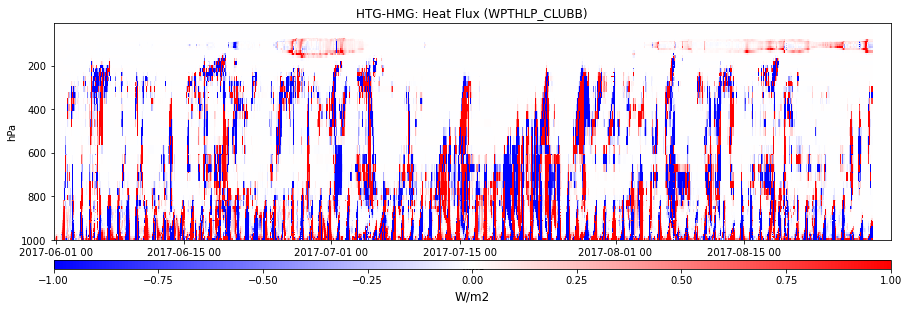

In [259]:
varPlot = 'WPTHLP_CLUBB'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.ilev.values, np.transpose(diffVar),
                                vmin=-1, vmax=1,
                                #levels=np.arange(-2,2.1,0.1),
                               cmap = 'bwr')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG: '+HTGcamDS_all[varPlot].long_name+' ('+varPlot+')', fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')






Text(0.5, 0, 'Time')

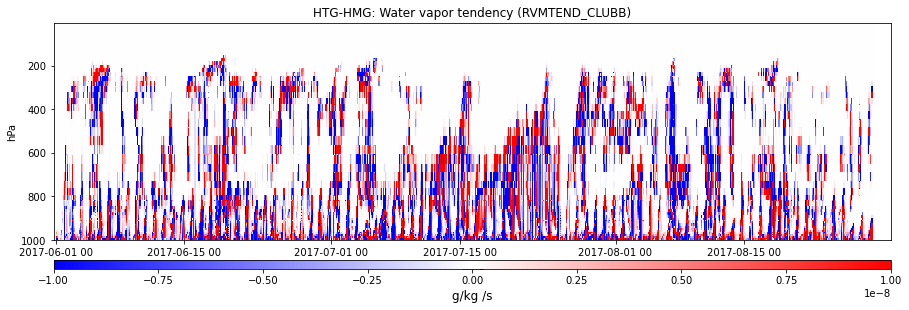

In [260]:
varPlot = 'RVMTEND_CLUBB'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.ilev.values, np.transpose(diffVar),
                                vmin=-1e-8, vmax=1e-8,
                                #levels=np.arange(-2,2.1,0.1),
                               cmap = 'bwr')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG: '+HTGcamDS_all[varPlot].long_name+' ('+varPlot+')', fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')



Text(0.5, 0, 'Time')

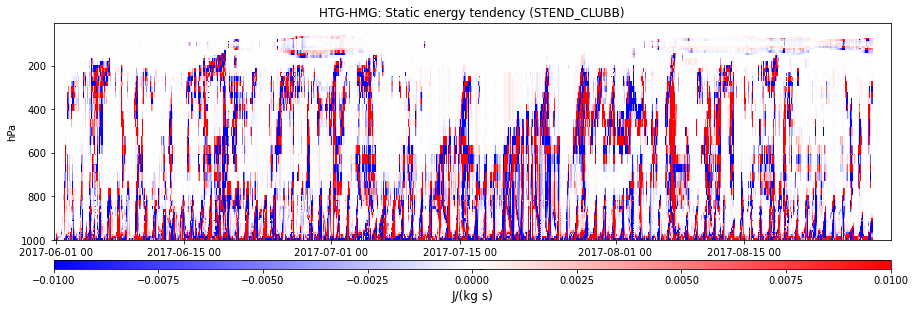

In [261]:
varPlot = 'STEND_CLUBB'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.ilev.values, np.transpose(diffVar),
                                vmin=-1e-2, vmax=1e-2,
                                #levels=np.arange(-2,2.1,0.1),
                               cmap = 'bwr')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG: '+HTGcamDS_all[varPlot].long_name+' ('+varPlot+')', fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')




Text(0.5, 0, 'Time')

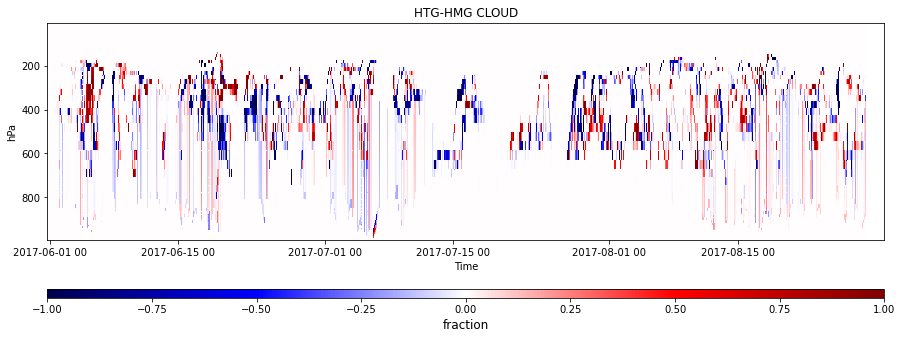

In [262]:
varPlot = 'CLOUD'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
# contour_plot   = axs.contourf(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar),
# #                              vmin=-1,vmax=1,norm=norm,
#                              levels=np.linspace(-1, 1.1,20),
#                              cmap = 'bwr',
#                              extend='both')

contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar),
                             vmin=-1,vmax=1,
                             #levels=np.linspace(-1, 1,20),
                             cmap = 'seismic')
#                              #extend='both'

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG '+varPlot, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')



Text(0.5, 0, 'Time')

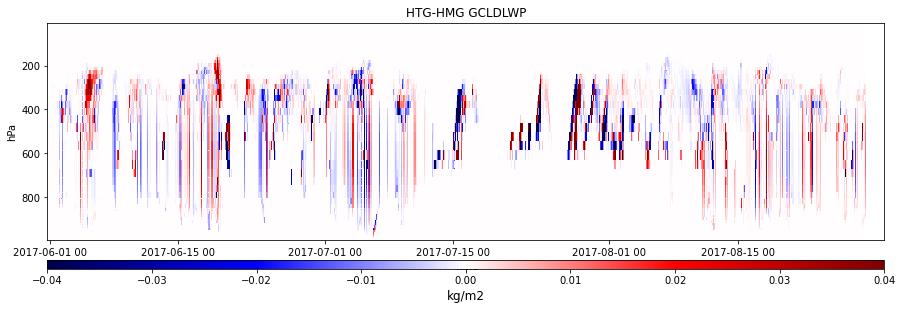

In [263]:
varPlot = 'GCLDLWP'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar),
                              vmin=-4e-2, vmax=4e-2,
                       #levels=np.linspace(-4e-2, 4e-2,21),
                       cmap = 'seismic')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG '+varPlot, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')


Text(0.5, 0, 'Time')

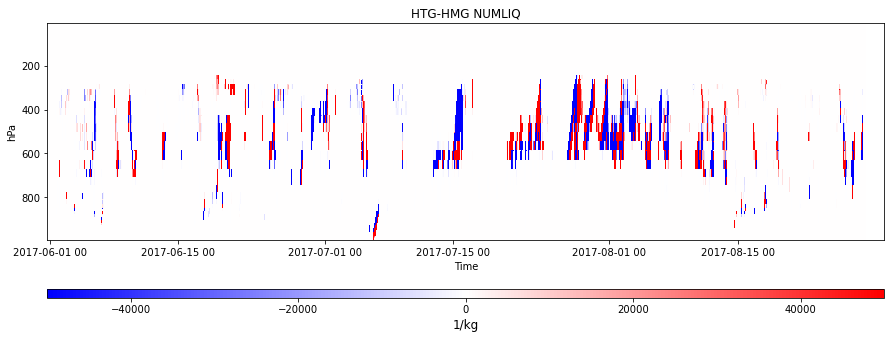

In [264]:
varPlot = 'NUMLIQ'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
# contour_plot   = axs.contourf(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar),
# #                              vmin=-1,vmax=1,norm=norm,
#                              levels=np.linspace(-1, 1.1,20),
#                              cmap = 'bwr',
#                              extend='both')

contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar),
                             vmin=-50000,vmax=50000,
                             #levels=np.linspace(-1, 1,20),
                             cmap = 'bwr')
#                              #extend='both'

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG '+varPlot, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')


Text(0.5, 0, 'Time')

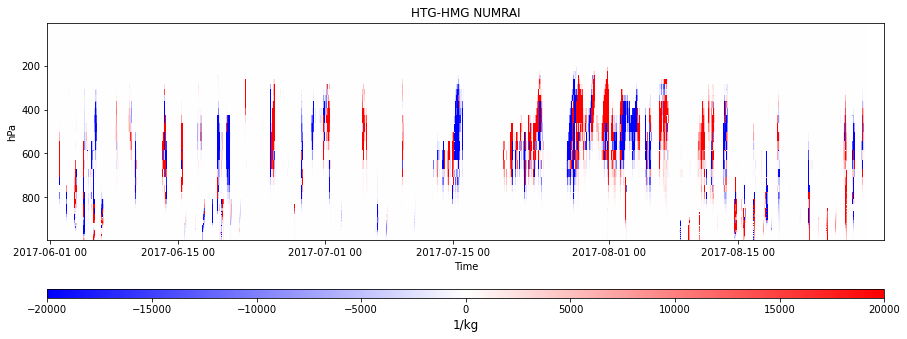

In [265]:
varPlot = 'NUMRAI'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
# contour_plot   = axs.contourf(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar),
# #                              vmin=-1,vmax=1,norm=norm,
#                              levels=np.linspace(-1, 1.1,20),
#                              cmap = 'bwr',
#                              extend='both')

contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar),
                             vmin=-20000,vmax=20000,
                             #levels=np.linspace(-1, 1,20),
                             cmap = 'bwr')
#                              #extend='both'

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG '+varPlot, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')



Text(0.5, 0, 'Time')

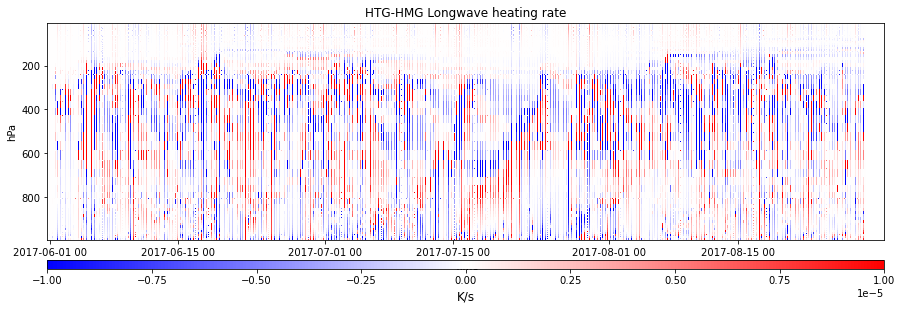

In [266]:
varPlot = 'QRL'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar),
                              vmin=-1e-5, vmax=1e-5,
                              #levels=np.linspace(-5e-5, 5e-5,21),
                       cmap = 'bwr')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG '+HMGcamDS_all[varPlot].long_name, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')





Text(0.5, 0, 'Time')

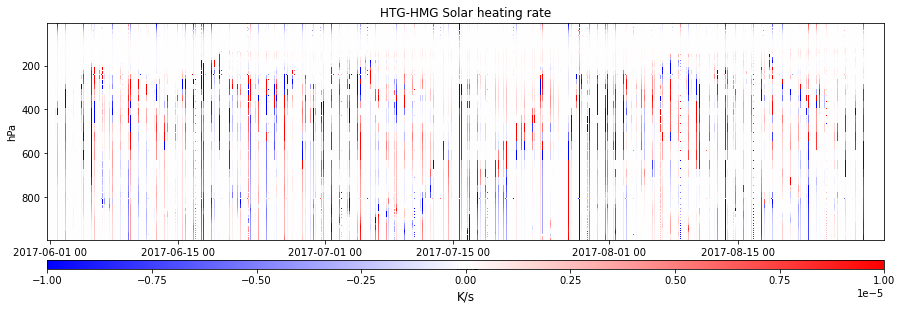

In [267]:
varPlot = 'QRS'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar),
                              vmin=-1e-5, vmax=1e-5,
                              #levels=np.linspace(-5e-5, 5e-5,21),
                       cmap = 'bwr')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG '+HMGcamDS_all[varPlot].long_name, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')






Text(0.5, 0, 'Time')

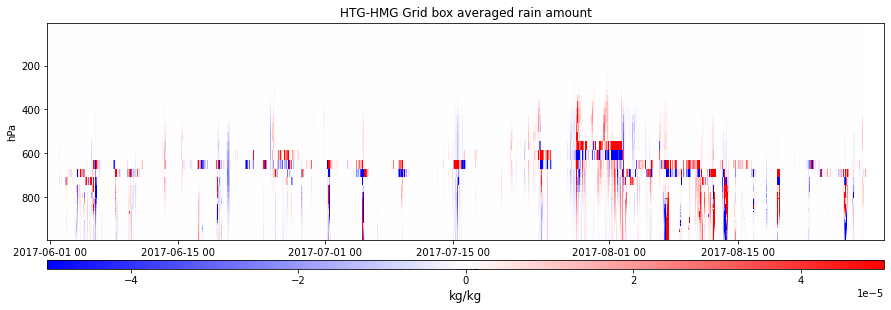

In [268]:
varPlot = 'RAINQM'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar),
                              vmin=-5e-5, vmax=5e-5,
                              #levels=np.linspace(-5e-5, 5e-5,21),
                       cmap = 'bwr')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG '+HMGcamDS_all[varPlot].long_name, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')



Text(0.5, 0, 'Time')

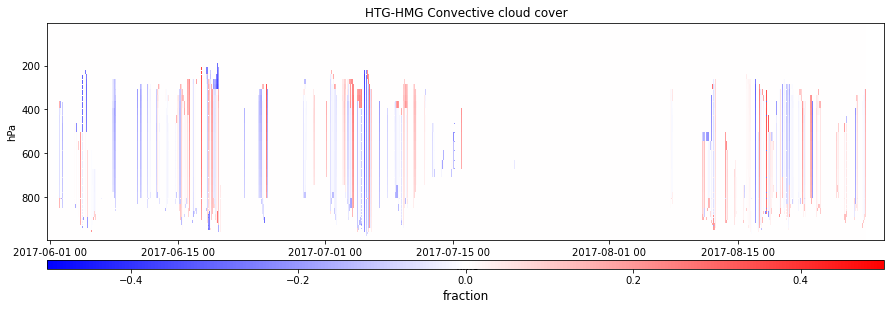

In [269]:
varPlot = 'CONCLD'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar),
                              vmin=-0.5, vmax=0.5,
                              #levels=np.linspace(-5e-5, 5e-5,21),
                       cmap = 'bwr')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG '+HMGcamDS_all[varPlot].long_name, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')


Text(0.5, 0, 'Time')

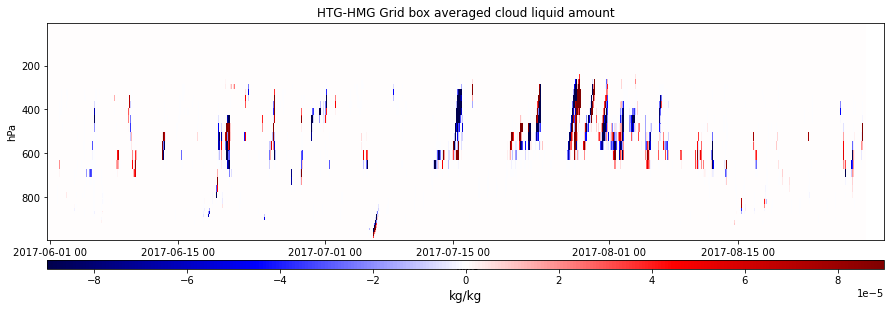

In [270]:
varPlot = 'CLDLIQ'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar),
                              vmin=-9e-5, vmax=9e-5,
                              #levels=np.linspace(-5e-5, 5e-5,21),
                       cmap = 'seismic')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG '+HMGcamDS_all[varPlot].long_name, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')



Text(0.5, 0, 'Time')

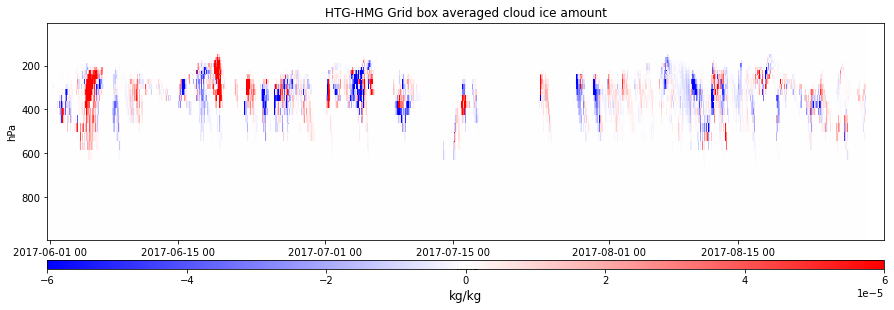

In [271]:
varPlot = 'CLDICE'
diffVar = HTGcamDS_all[varPlot].values[:,:,0,0] - HMGcamDS_all[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time.values, HTGcamDS_all.lev.values, np.transpose(diffVar),
                              vmin=-6e-5, vmax=6e-5,
                              #levels=np.linspace(-5e-5, 5e-5,21),
                       cmap = 'bwr')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
if HTGclmDS_all['time.year'].values[0]==2016: 
    axs.set_xlim([datetime.datetime(2016,startMonth,startDay,startHr,0,0), datetime.datetime(2016,endMonth,endDay,0,0,0)])
elif HTGclmDS_all['time.year'].values[0]==2017: 
    axs.set_xlim([datetime.datetime(2017,startMonth,startDay,startHr,0,0), datetime.datetime(2017,endMonth,endDay,0,0,0)])
else: 
    axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG '+HMGcamDS_all[varPlot].long_name, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')




**Do the results in 2015 July/August match what would happen if initialized just before the month starts?**

In [223]:
julFile = dataDir+'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_July.cam.h0.2015-06-30-84585.nc'
augFile = dataDir+'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_August.cam.h0.2015-07-31-84585.nc'
julLndFile = dataDir+'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_July.clm2.h0.2015-06-30-84585.nc'
augLndFile = dataDir+'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_August.clm2.h0.2015-07-31-84585.nc'

with xr.open_dataset(julFile, decode_times=False) as HTGjulDS:
    HTGjulDS = cesm_correct_time(HTGjulDS)
    HTGjulDS['time'] = HTGjulDS.indexes['time'].to_datetimeindex()

with xr.open_dataset(augFile, decode_times=False) as HTGaugDS:
    HTGaugDS = cesm_correct_time(HTGaugDS)
    HTGaugDS['time'] = HTGaugDS.indexes['time'].to_datetimeindex()
    
with xr.open_dataset(julLndFile, decode_times=False) as HTGjulLndDS:
    HTGjulLndDS['time'] = HTGjulDS.indexes['time']

with xr.open_dataset(augLndFile, decode_times=False) as HTGaugLndDS:
    HTGaugLndDS['time'] = HTGaugDS.indexes['time']
    
julFile = dataDir+'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_July.cam.h0.2015-06-30-84585.nc'
augFile = dataDir+'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_August.cam.h0.2015-07-31-84585.nc'
julLndFile = dataDir+'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_July.clm2.h0.2015-06-30-84585.nc'
augLndFile = dataDir+'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_August.clm2.h0.2015-07-31-84585.nc'

with xr.open_dataset(julFile, decode_times=False) as HMGjulDS:
    HMGjulDS = cesm_correct_time(HMGjulDS)
    HMGjulDS['time'] = HMGjulDS.indexes['time'].to_datetimeindex()

with xr.open_dataset(augFile, decode_times=False) as HMGaugDS:
    HMGaugDS = cesm_correct_time(HMGaugDS)
    HMGaugDS['time'] = HMGaugDS.indexes['time'].to_datetimeindex()
    
with xr.open_dataset(julLndFile, decode_times=False) as HMGjulLndDS:
    HMGjulLndDS['time'] = HMGjulDS.indexes['time']

with xr.open_dataset(augLndFile, decode_times=False) as HMGaugLndDS:
    HMGaugLndDS['time'] = HMGaugDS.indexes['time']
    

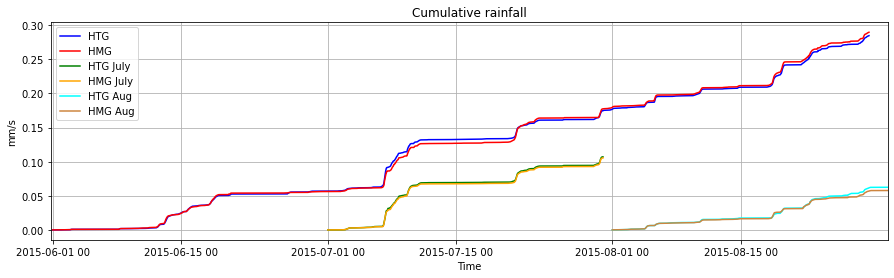

In [227]:
## CDF of rainfall over the summer 
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(HTGclmDS_all2015.time.values, HTGclmDS_all2015.RAIN.cumsum(dim='time'),'b-',label='HTG')
axs.plot(HMGclmDS_all2015.time.values, HMGclmDS_all2015.RAIN.cumsum(dim='time'),'r-',label='HMG')

# Plot July start 
axs.plot(HTGjulLndDS.time.values, HTGjulLndDS.RAIN.cumsum(dim='time'),'-',color='green',label='HTG July')
axs.plot(HMGjulLndDS.time.values, HMGjulLndDS.RAIN.cumsum(dim='time'),'-',color='orange',label='HMG July')

# Plot Aug start 
axs.plot(HTGaugLndDS.time.values, HTGaugLndDS.RAIN.cumsum(dim='time'),'-',color='cyan',label='HTG Aug')
axs.plot(HMGaugLndDS.time.values, HMGaugLndDS.RAIN.cumsum(dim='time'),'-',color='peru',label='HMG Aug')

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
    
axs.legend()
axs.set_title('Cumulative rainfall', fontsize=12)
axs.set_ylabel(HTGclmDS_all2015.RAIN.units)
axs.set_xlabel('Time')

axs.grid()



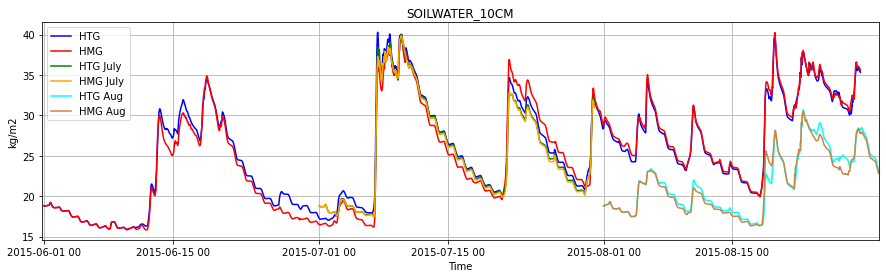

In [228]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(HTGclmDS_all2015.time.values, HTGclmDS_all2015.SOILWATER_10CM,'b-',label='HTG')
axs.plot(HMGclmDS_all2015.time.values, HMGclmDS_all2015.SOILWATER_10CM,'r-',label='HMG')

# Plot July start 
axs.plot(HTGjulLndDS.time.values, HTGjulLndDS.SOILWATER_10CM,'-',color='green',label='HTG July')
axs.plot(HMGjulLndDS.time.values, HMGjulLndDS.SOILWATER_10CM,'-',color='orange',label='HMG July')

# Plot Aug start 
axs.plot(HTGaugLndDS.time.values, HTGaugLndDS.SOILWATER_10CM,'-',color='cyan',label='HTG Aug')
axs.plot(HMGaugLndDS.time.values, HMGaugLndDS.SOILWATER_10CM,'-',color='peru',label='HMG Aug')

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8
axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])
 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
    
axs.legend()
axs.set_title('SOILWATER_10CM', fontsize=12)
axs.set_ylabel(HTGclmDS_all2015.SOILWATER_10CM.units)
axs.set_xlabel('Time')

axs.grid()



(3.0, 0.0)

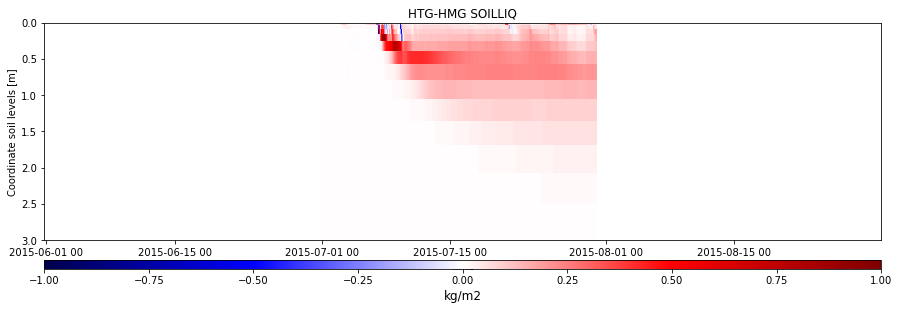

In [299]:
varPlot = 'SOILLIQ'
diffVar = HTGjulLndDS[varPlot].values[:,:,0] - HMGjulLndDS[varPlot].values[:,:,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGjulLndDS.time.values, HTGjulLndDS.levsoi.values, np.transpose(diffVar),
                                vmin=-1, vmax=1,
                                #levels=np.arange(-1,1.1,0.1),
                       cmap = 'seismic')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGclmDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8

axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])


# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
    
axs.invert_yaxis()

axs.set_title('HTG-HMG '+varPlot, fontsize=12)
axs.set_ylabel('Coordinate soil levels [m]')
axs.set_xlabel('Time')
axs.set_ylim([3,0])



(3.0, 0.0)

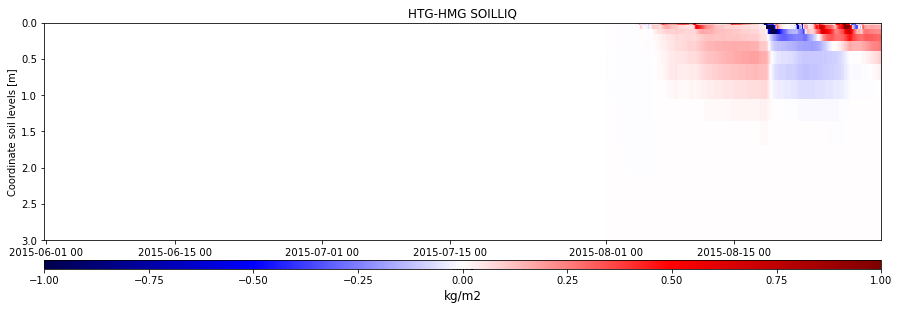

In [300]:
varPlot = 'SOILLIQ'
diffVar = HTGaugLndDS[varPlot].values[:,:,0] - HMGaugLndDS[varPlot].values[:,:,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGaugLndDS.time.values, HTGaugLndDS.levsoi.values, np.transpose(diffVar),
                                vmin=-1, vmax=1,
                                #levels=np.arange(-1,1.1,0.1),
                       cmap = 'seismic')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGclmDS_all[varPlot].units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18
endDay     = 31
endMonth   = 8

axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])


# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
    
axs.invert_yaxis()

axs.set_title('HTG-HMG '+varPlot, fontsize=12)
axs.set_ylabel('Coordinate soil levels [m]')
axs.set_xlabel('Time')
axs.set_ylim([3,0])

Text(0.5, 0, 'Time')

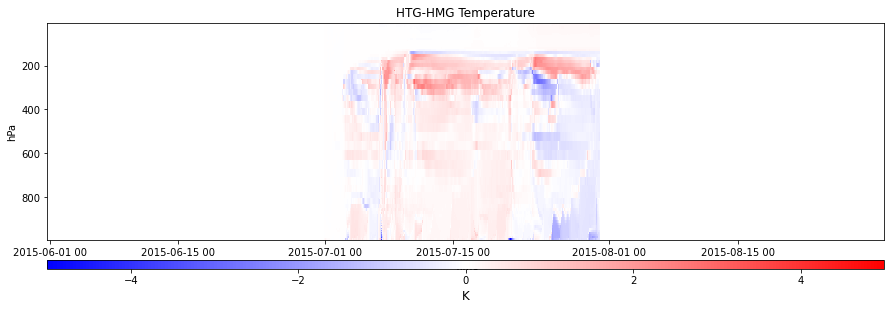

In [275]:
varPlot = 'T'
diffVar = HTGjulDS[varPlot].values[:,:,0,0] - HMGjulDS[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGjulDS.time.values, HTGjulDS.lev.values, np.transpose(diffVar),
                              vmin=-5, vmax=5,
                              #levels=np.linspace(-5e-5, 5e-5,21),
                       cmap = 'bwr')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_all[varPlot].units,fontsize=12)


axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG '+HMGcamDS_all[varPlot].long_name, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')



Text(0.5, 0, 'Time')

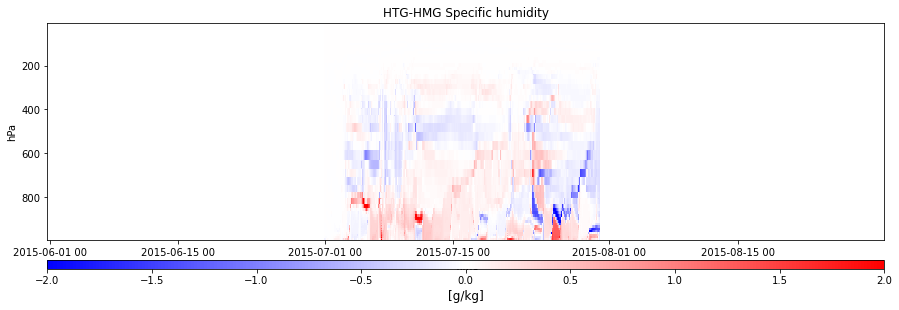

In [277]:
varPlot = 'Q'
diffVar = (HTGjulDS[varPlot].values[:,:,0,0]*1000) - (HMGjulDS[varPlot].values[:,:,0,0]*1000)

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGjulDS.time.values, HTGjulDS.lev.values, np.transpose(diffVar),
                              vmin=-2, vmax=2,
                              #levels=np.linspace(-5e-5, 5e-5,21),
                       cmap = 'bwr')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[g/kg]',fontsize=12)


axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG '+HMGcamDS_all[varPlot].long_name, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')


Text(0.5, 0, 'Time')

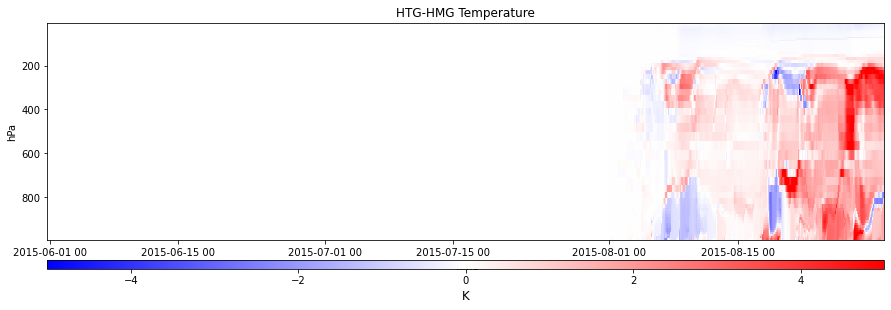

In [278]:
varPlot = 'T'
diffVar = HTGaugDS[varPlot].values[:,:,0,0] - HMGaugDS[varPlot].values[:,:,0,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGaugDS.time.values, HTGaugDS.lev.values, np.transpose(diffVar),
                              vmin=-5, vmax=5,
                              #levels=np.linspace(-5e-5, 5e-5,21),
                       cmap = 'bwr')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_all[varPlot].units,fontsize=12)


axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG '+HMGcamDS_all[varPlot].long_name, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')




Text(0.5, 0, 'Time')

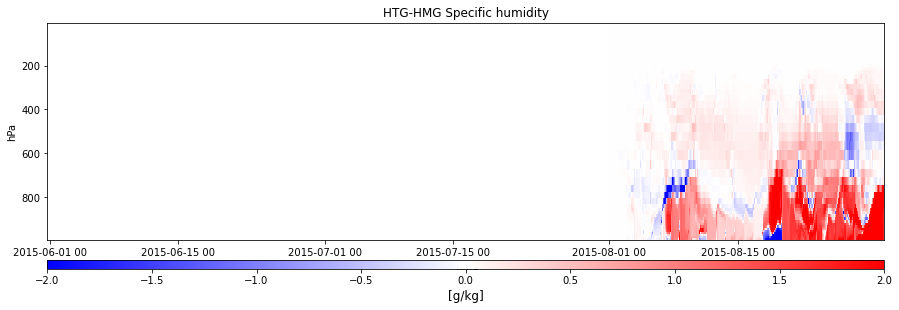

In [279]:
varPlot = 'Q'
diffVar = (HTGaugDS[varPlot].values[:,:,0,0]*1000) - (HMGaugDS[varPlot].values[:,:,0,0]*1000)

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGaugDS.time.values, HTGaugDS.lev.values, np.transpose(diffVar),
                              vmin=-2, vmax=2,
                              #levels=np.linspace(-5e-5, 5e-5,21),
                       cmap = 'bwr')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[g/kg]',fontsize=12)


axs.set_xlim([datetime.datetime(2015,startMonth,startDay,startHr,0,0), datetime.datetime(2015,endMonth,endDay,0,0,0)])

 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()
axs.set_title('HTG-HMG '+HMGcamDS_all[varPlot].long_name, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')

**Allow for spin up**

In [305]:
## Discard the first 2 days... 
# iTimeStart   = np.where(HMGcamDS_all.time.values >= np.datetime64('2015-06-02'))[0]
# iTimeStart   = np.where(HMGcamDS_all.time.values >= np.datetime64('2016-06-02'))[0]
iTimeStart   = np.where(HMGcamDS_all.time.values >= np.datetime64('2017-06-02'))[0]

timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all.time.values))

HTGcamDS_all = HTGcamDS_all.isel(time=timeArr)
HTGclmDS_all = HTGclmDS_all.isel(time=timeArr)

HMGcamDS_all = HMGcamDS_all.isel(time=timeArr)
HMGclmDS_all = HMGclmDS_all.isel(time=timeArr)


In [306]:
# Convert times to a pandas datetime array, with UTC timezone
times      = pd.DatetimeIndex(HTGcamDS_all.time.values, tz='UTC')
localTime  = times.tz_convert(tz='US/Central') 


In [307]:
localTime


DatetimeIndex(['2017-06-02 18:39:45-05:00', '2017-06-02 18:59:45-05:00',
               '2017-06-02 19:19:45-05:00', '2017-06-02 19:39:45-05:00',
               '2017-06-02 19:59:45-05:00', '2017-06-02 20:19:45-05:00',
               '2017-06-02 20:39:45-05:00', '2017-06-02 20:59:45-05:00',
               '2017-06-02 21:19:45-05:00', '2017-06-02 21:39:45-05:00',
               ...
               '2017-08-28 15:19:45-05:00', '2017-08-28 15:39:45-05:00',
               '2017-08-28 15:59:45-05:00', '2017-08-28 16:19:45-05:00',
               '2017-08-28 16:39:45-05:00', '2017-08-28 16:59:45-05:00',
               '2017-08-28 17:19:45-05:00', '2017-08-28 17:39:45-05:00',
               '2017-08-28 17:59:45-05:00', '2017-08-28 18:19:45-05:00'],
              dtype='datetime64[ns, US/Central]', length=6264, freq=None)

### How different are the w*'s computed in CLUBB vs. by default? 

In [9]:
# logFile = dataDir+'lnd.log.8632415.chadmin1.ib0.cheyenne.ucar.edu.210608-091307'

# with open(logFile) as f:
#     lines = f.readlines()


In [10]:
# # First get where each output for a timestep ends

# endTimeLines = []

# for iLines in range(len(lines)):
#     if lines[iLines].startswith(' clm: completed timestep ')==True:
#         endTimeLines = np.append(endTimeLines,iLines)
# # Ignore firt day (~72 timesteps
# endTimeLines = endTimeLines[72::]
        
# wstar_CLUBBmoments = np.full([len(endTimeLines),20], np.nan)
# wstar_frictionVel  = np.full([len(endTimeLines),20], np.nan)

# for iTimes in range(len(endTimeLines)):
    
#     timestepSection = lines[int(endTimeLines[iTimes-1]):int(endTimeLines[iTimes])]

#     lineFrict = [item for item in timestepSection if item.startswith(' MDF:  Patch wstar from frictionVel =')]
#     for iPatch in range(len(lineFrict)):
#         strArr     = lineFrict[iPatch].split('=')
#         wstarFrict = strArr[1].split('\n')
#         # Save value of zeta at this time step/patch 
#         wstar_frictionVel[iTimes,iPatch] = float(wstarFrict[0])
        
#     lineCLUBB = [item for item in timestepSection if item.startswith(' MDF:  Patch wstar from CLUBBmoments =')]
#     for iPatch in range(len(lineCLUBB)):
#         strArr     = lineCLUBB[iPatch].split('=')
#         wstarCLUBB = strArr[1].split('\n')
#         # Save value of zeta at this time step/patch 
#         wstar_CLUBBmoments[iTimes,iPatch] = float(wstarCLUBB[0])
        

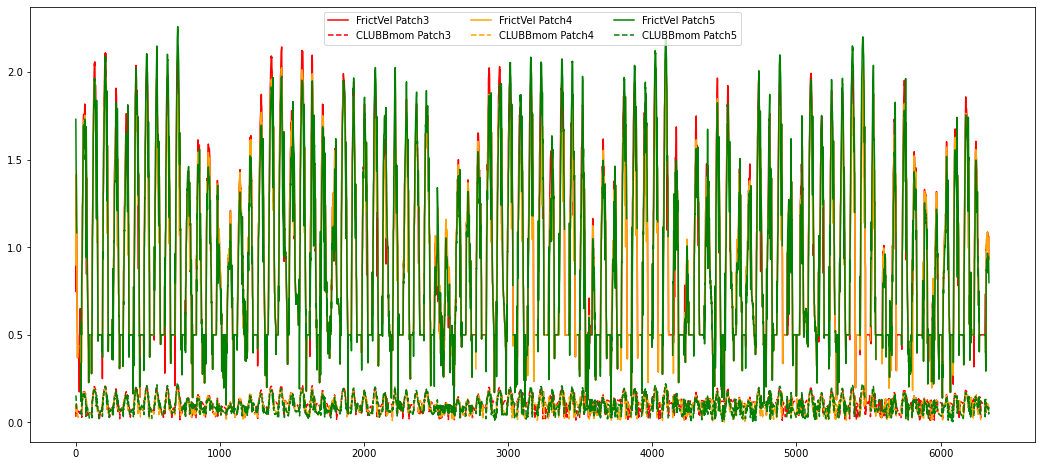

In [12]:
# fig,ax1 = plt.subplots(1,1, figsize=(18,8))

# colorsList = np.asarray(['red','orange','green','blue','purple'])

# for iPatch in range(3):
#     ax1.plot(wstar_frictionVel[:,iPatch+3],color=colorsList[iPatch],label = 'FrictVel Patch'+str(iPatch+3))
#     ax1.plot(wstar_CLUBBmoments[:,iPatch+3],'--',color=colorsList[iPatch],label = 'CLUBBmom Patch'+str(iPatch+3))
    
# ax1.legend(ncol=3)
    

## Make some plots for comparison

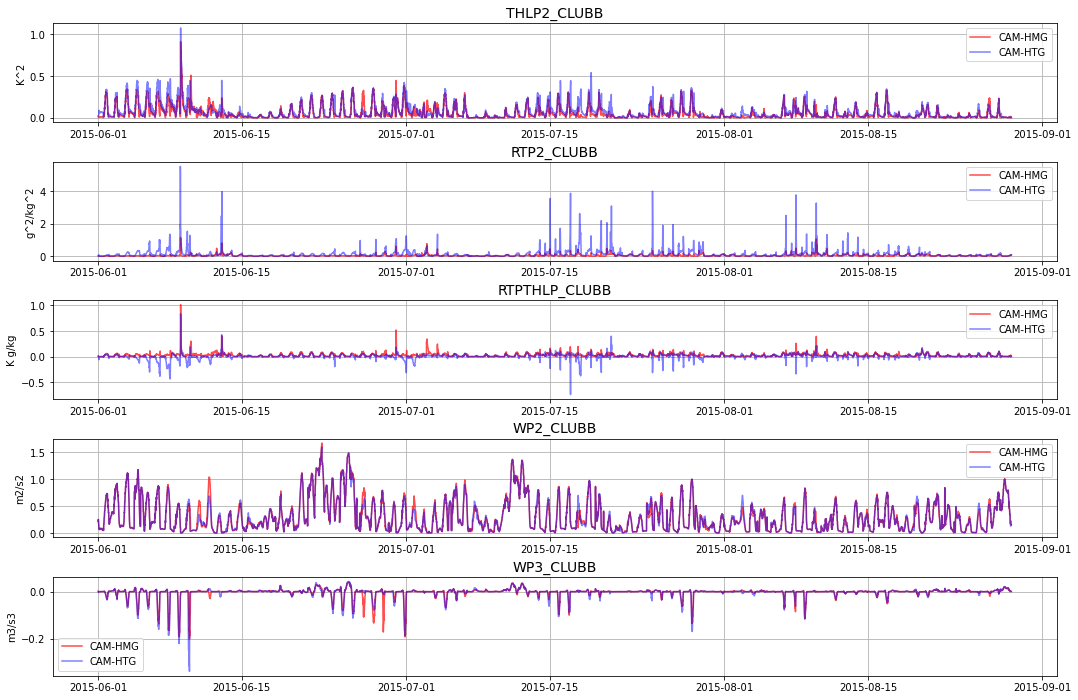

In [7]:
fig,axs = plt.subplots(5,1, figsize=(18,12))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','WP3_CLUBB'])

for iVar in range(5):
    
    if ATM_varNames[iVar]=='WP3_CLUBB':
        axs[iVar].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames[iVar]].values[:,-2,:,:]),
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames[iVar]].values[:,-2,:,:]),
                      'b-', alpha=0.5, label='CAM-HTG')        
    else:
        axs[iVar].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames[iVar]].values[:,-1,:,:]),
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames[iVar]].values[:,-1,:,:]),
                      'b-', alpha=0.5, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units)
    axs[iVar].legend()
    axs[iVar].grid()
#     axs[iVar].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])


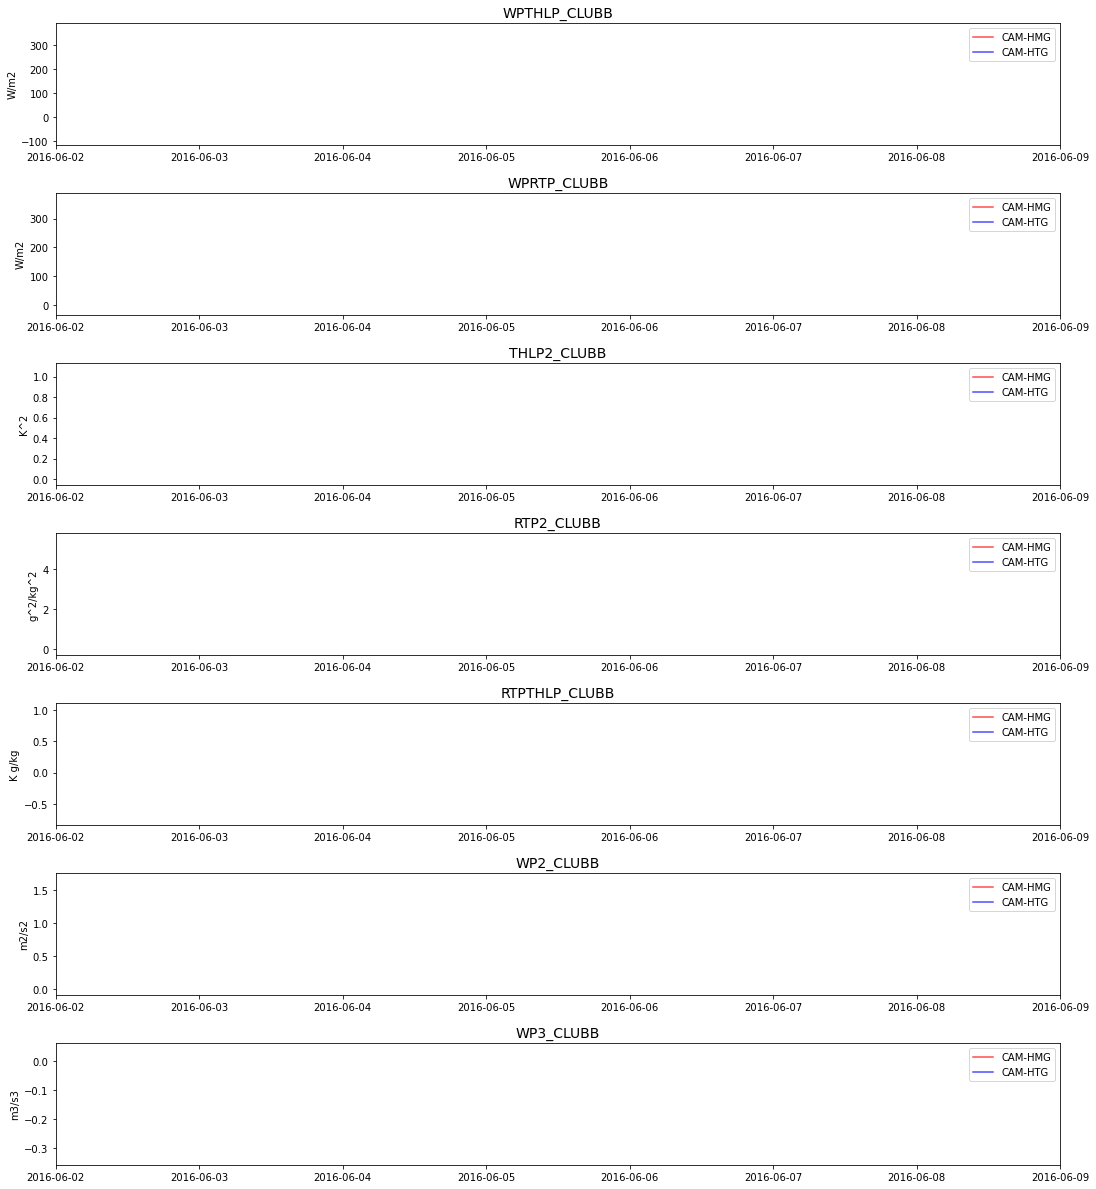

In [8]:
fig,axs = plt.subplots(7,1, figsize=(18,21))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

ATM_varNames = np.asarray(['WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','RTP2_CLUBB', 'RTPTHLP_CLUBB','WP2_CLUBB','WP3_CLUBB'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(7):
        
    if ATM_varNames[iVar]=='WP3_CLUBB':
        axs[iVar].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames[iVar]].values)[:,-2],
                  'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames[iVar]].values)[:,-2],
                  'b-', alpha=0.7, label='CAM-HTG')
    else: 
        axs[iVar].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames[iVar]].values)[:,-1],
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames[iVar]].values)[:,-1],
                      'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_ylabel(HMGcamDS_all[ATM_varNames[iVar]].units)
    axs[iVar].legend()
#     axs[iVar].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])
#     axs[iVar].set_xlim([datetime.date(2015,6,2), datetime.date(2015,6,9)])
    axs[iVar].set_xlim([datetime.date(2016,6,2), datetime.date(2016,6,9)])





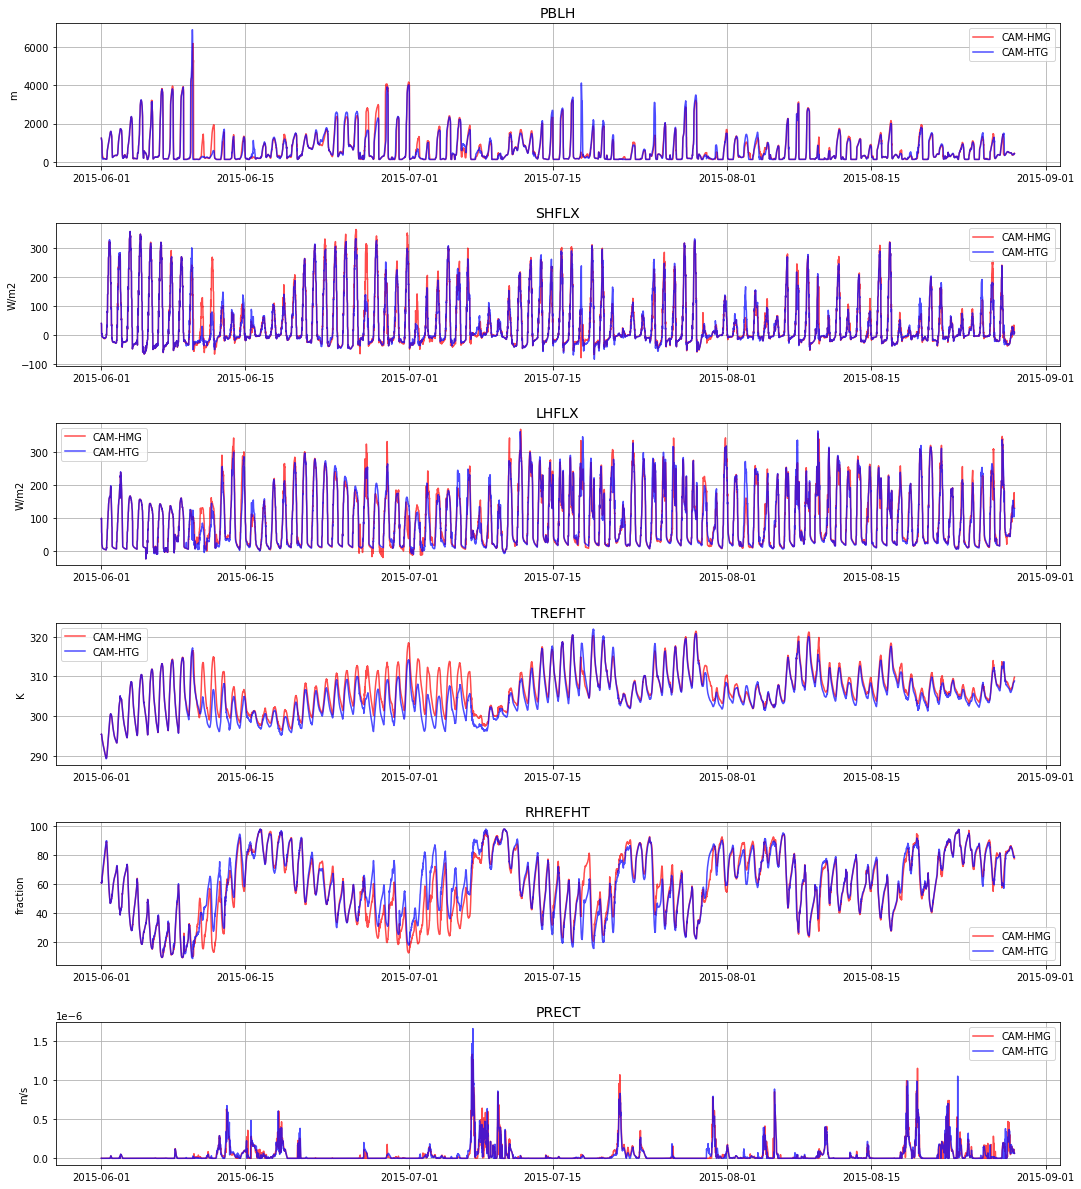

In [9]:
fig,axs = plt.subplots(6,1, figsize=(18,21))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

ATM_varNames = np.asarray(['PBLH','SHFLX','LHFLX','TREFHT','RHREFHT','PRECT'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):
        
    axs[iVar].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units)
    axs[iVar].legend()
    axs[iVar].grid()
#     axs[iVar].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])
#     axs[iVar].set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,9)])

#     if ATM_varNames[iVar]=='SHFLX':
#         axs[iVar].set_ylim([-50,300])
#     elif ATM_varNames[iVar]=='LHFLX':
#         axs[iVar].set_ylim([-10,260])
#     elif ATM_varNames[iVar]=='TREFHT':
#         axs[iVar].set_ylim([270,310])
#     elif ATM_varNames[iVar]=='RHREFHT':
#         axs[iVar].set_ylim([10,120])



In [57]:
np.shape(HMGcamDS_all[ATM_varNames].values)

()

(275.0, 325.0)

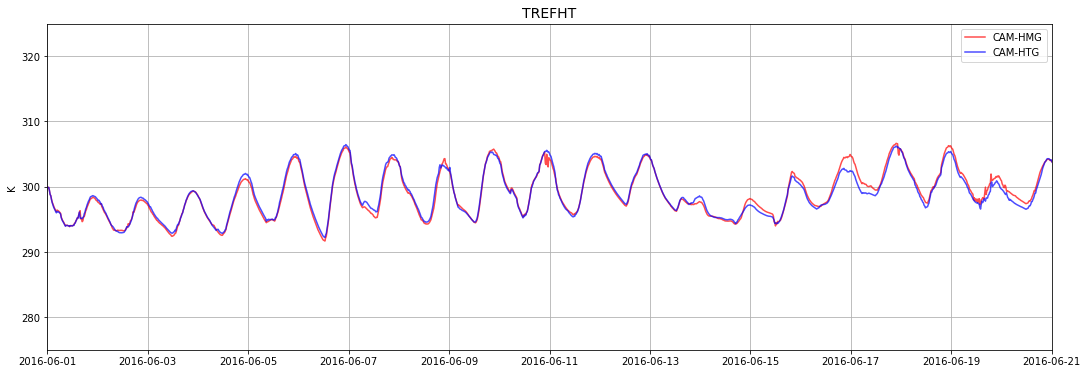

In [61]:
fig,axs = plt.subplots(1,1, figsize=(18,6))

ATM_varNames = np.asarray(['TREFHT'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

        
axs.plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames[0]].values),
              'r-', alpha=0.7, label='CAM-HMG')
axs.plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames[0]].values),
              'b-', alpha=0.7, label='CAM-HTG')

axs.set_title(ATM_varNames[0],fontsize=14)
axs.set_ylabel(HMGcamDS[ATM_varNames[0]].units)
axs.legend()
axs.grid()
#     axs[iVar].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])
axs.set_xlim([datetime.date(2016,6,1), datetime.date(2016,6,21)])

#     if ATM_varNames[iVar]=='SHFLX':
#         axs[iVar].set_ylim([-50,300])
#     elif ATM_varNames[iVar]=='LHFLX':
#         axs[iVar].set_ylim([-10,260])
#     elif ATM_varNames[iVar]=='TREFHT':
#         axs[iVar].set_ylim([270,310])
#     elif ATM_varNames[iVar]=='RHREFHT':
#         axs[iVar].set_ylim([10,120])

axs.set_ylim([275,325])


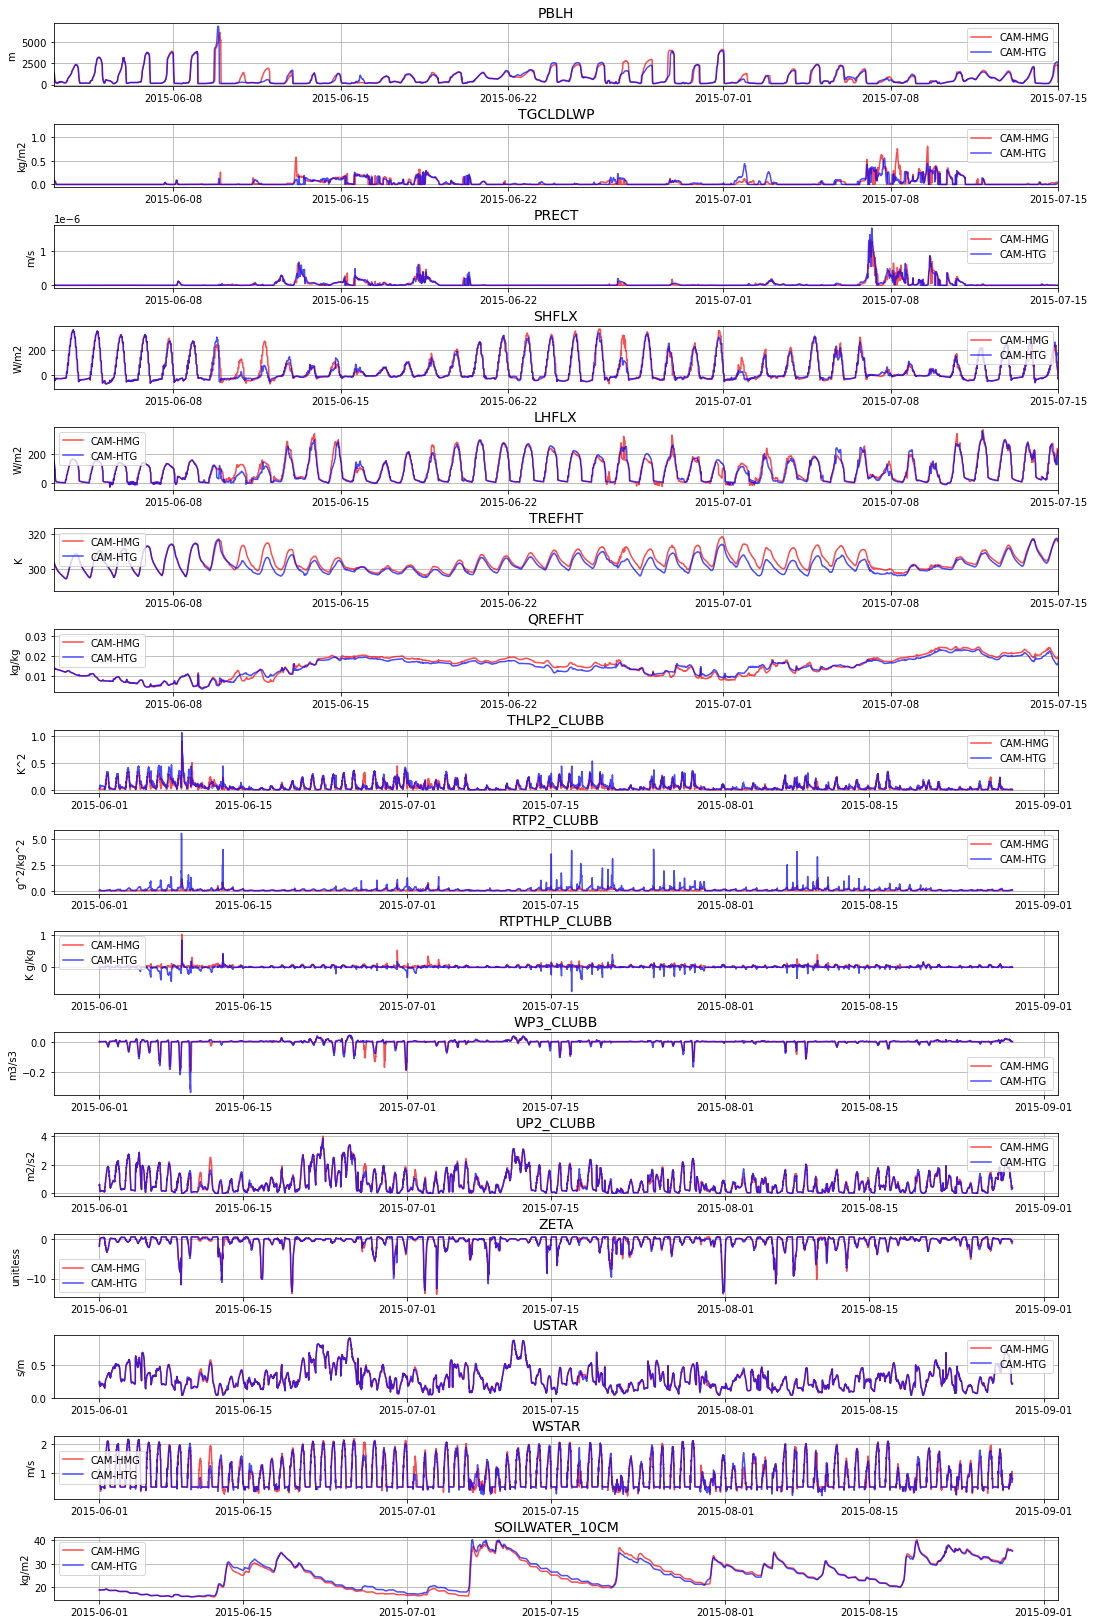

In [10]:
## Merge it all into one giant plot! 
## -----------------------------------------------------

# ATM_varNames   = np.asarray(['PBLH','SHFLX','LHFLX','PRECT'])
ATM_varNames   = np.asarray(['PBLH','TGCLDLWP','PRECT','SHFLX','LHFLX','TREFHT','QREFHT'])

#ATM_varNames3D = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])
ATM_varNames3D = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP3_CLUBB','UP2_CLUBB'])

# LND_varNames   = np.asarray(['ZETA','USTAR','U10'])
LND_varNames   = np.asarray(['ZETA','USTAR','WSTAR','SOILWATER_10CM'])


nPlots = len(ATM_varNames)+len(ATM_varNames3D)+len(LND_varNames)
fig,axs = plt.subplots(nPlots,1, figsize=(18,29))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.6)

zoomWeek = 0
full3mo  = 1 

# When to start and end "zoomWeek" option
startDate = datetime.date(2015,7,10)
endDate   = datetime.date(2015,7,24)

for iVar in range(len(ATM_varNames)):
        
    axs[iVar].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units)
    axs[iVar].legend()
    axs[iVar].grid()
    if HMGcamDS_all['time.year'].values[0]==2016:
        axs[iVar].set_xlim([datetime.date(2016,7,3), datetime.date(2016,8,29)])
    elif HMGcamDS_all['time.year'].values[0]==2015:
        axs[iVar].set_xlim([datetime.date(2015,6,3), datetime.date(2015,7,15)])
#     if zoomWeek==1: 
#          axs[iVar].set_xlim([startDate, endDate])
#     elif full3mo==1: 
#         axs[iVar].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,29)])
#     else: 
#         axs[iVar].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,29)])


for iVar in range(len(ATM_varNames3D)):
    iPlt = iVar+len(ATM_varNames)
      
    if ATM_varNames3D[iVar]=='WP3_CLUBB':
        axs[iPlt].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames3D[iVar]].values)[:,-2],
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iPlt].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames3D[iVar]].values)[:,-2],
                      'b-', alpha=0.7, label='CAM-HTG')        
    else: 
        axs[iPlt].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames3D[iVar]].values)[:,-1],
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iPlt].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames3D[iVar]].values)[:,-1],
                      'b-', alpha=0.7, label='CAM-HTG')

    axs[iPlt].set_title(ATM_varNames3D[iVar],fontsize=14)
    axs[iPlt].set_ylabel(HMGcamDS[ATM_varNames3D[iVar]].units)
    axs[iPlt].legend()
    axs[iPlt].grid()
    if HMGcamDS_all['time.year'].values[0]==2016:
        axs[iVar].set_xlim([datetime.date(2016,7,3), datetime.date(2016,8,29)])
    elif HMGcamDS_all['time.year'].values[0]==2015:
        axs[iVar].set_xlim([datetime.date(2015,6,3), datetime.date(2015,7,15)])
#     if zoomWeek==1: 
#          axs[iPlt].set_xlim([startDate, endDate])
#     elif full3mo==1: 
#         axs[iPlt].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,29)])
#     else: 
#         axs[iPlt].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,29)])
    
    
for iVar in range(len(LND_varNames)):
    iPlt = iVar+len(ATM_varNames)+len(ATM_varNames3D)
        
    axs[iPlt].plot(HMGclmDS_all['time'].values, np.squeeze(HMGclmDS_all[LND_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlt].plot(HTGclmDS_all['time'].values, np.squeeze(HTGclmDS_all[LND_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG')

    axs[iPlt].set_title(LND_varNames[iVar],fontsize=14)
    axs[iPlt].set_ylabel(HMGclmDS[LND_varNames[iVar]].units)
    axs[iPlt].legend()
    axs[iPlt].grid()
    if HMGcamDS_all['time.year'].values[0]==2016:
        axs[iVar].set_xlim([datetime.date(2016,7,3), datetime.date(2016,8,29)])
    elif HMGcamDS_all['time.year'].values[0]==2015:
        axs[iVar].set_xlim([datetime.date(2015,6,3), datetime.date(2015,7,15)])
#     if zoomWeek==1: 
#          axs[iPlt].set_xlim([startDate, endDate])
#     elif full3mo==1: 
#         axs[iPlt].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,29)])
#     else: 
#         axs[iPlt].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,29)]) 


Text(0.5, 1.0, 'CLDHGH')

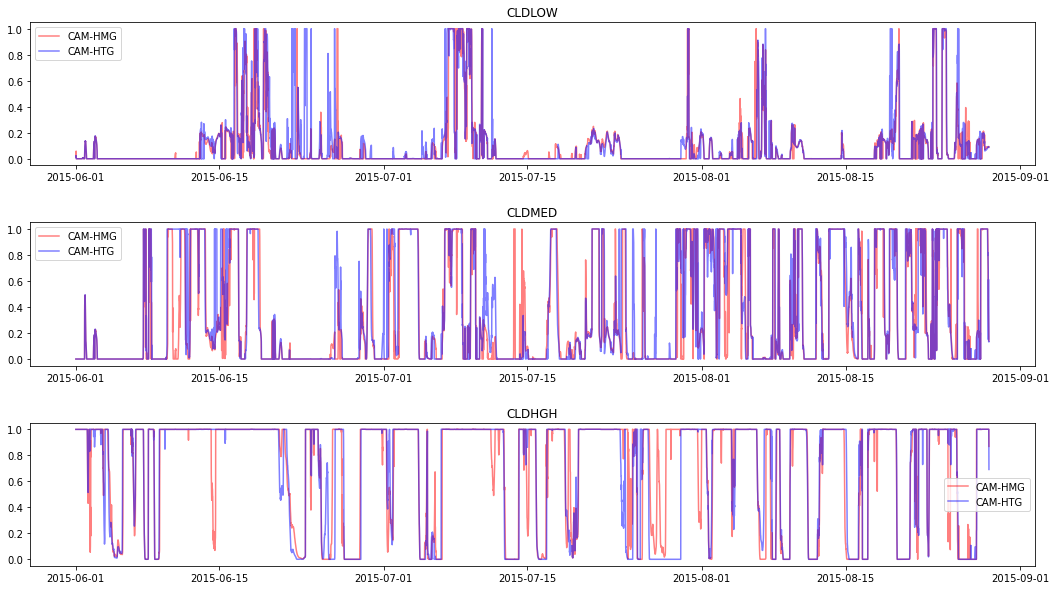

In [11]:
fig,axs = plt.subplots(3,1, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

axs[0].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all.CLDLOW.values), 'r-', alpha=0.5, label='CAM-HMG')
axs[0].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all.CLDLOW.values), 'b-', alpha=0.5, label='CAM-HTG')
axs[0].legend()
axs[0].set_title('CLDLOW')
# axs[0].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])

axs[1].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all.CLDMED.values), 'r-', alpha=0.5, label='CAM-HMG')
axs[1].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all.CLDMED.values), 'b-', alpha=0.5, label='CAM-HTG')
axs[1].legend()
axs[1].set_title('CLDMED')
# axs[1].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])

axs[2].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all.CLDHGH.values), 'r-', alpha=0.5, label='CAM-HMG')
axs[2].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all.CLDHGH.values), 'b-', alpha=0.5, label='CAM-HTG')
axs[2].legend()
axs[2].set_title('CLDHGH')
# axs[2].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])


Text(0.5, 1.0, 'U10')

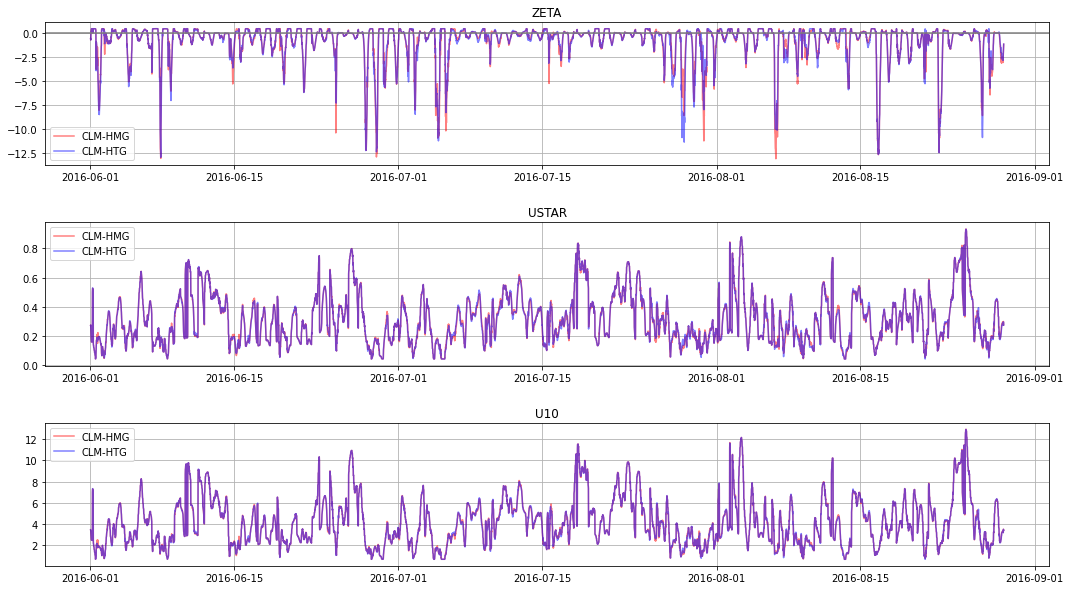

In [19]:
fig,axs = plt.subplots(3,1, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

axs[0].plot(HMGclmDS_all['time'].values, np.squeeze(HMGclmDS_all.ZETA.values), 'r-', alpha=0.5, label='CLM-HMG')
axs[0].plot(HMGclmDS_all['time'].values, np.squeeze(HTGclmDS_all.ZETA.values), 'b-', alpha=0.5, label='CLM-HTG')
axs[0].legend()
axs[0].grid()
axs[0].axhline(0,color='grey')
axs[0].set_title('ZETA')
# axs[0].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])
# axs[0].set_xlim([datetime.date(2015,6,2), datetime.date(2015,6,9)])

axs[1].plot(HMGclmDS_all['time'].values, np.squeeze(HMGclmDS_all.USTAR.values), 'r-', alpha=0.5, label='CLM-HMG')
axs[1].plot(HTGclmDS_all['time'].values, np.squeeze(HTGclmDS_all.USTAR.values), 'b-', alpha=0.5, label='CLM-HTG')
axs[1].legend()
axs[1].grid()
axs[1].set_title('USTAR')
# axs[1].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])
# axs[1].set_xlim([datetime.date(2015,6,2), datetime.date(2015,6,9)])

axs[2].plot(HMGclmDS_all['time'].values, np.squeeze(HMGclmDS_all.U10.values), 'r-', alpha=0.5, label='CLM-HMG')
axs[2].plot(HTGclmDS_all['time'].values, np.squeeze(HTGclmDS_all.U10.values), 'b-', alpha=0.5, label='CLM-HTG')
axs[2].legend()
axs[2].grid()
axs[2].set_title('U10')
# axs[2].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])
# axs[2].set_xlim([datetime.date(2015,6,2), datetime.date(2015,6,9)])


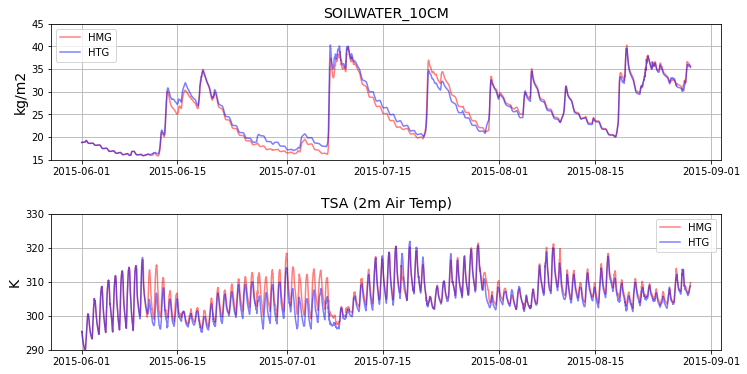

In [13]:
fig,axs = plt.subplots(2,1, figsize=(12,6))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

axs[0].plot(HMGclmDS_all['time'].values, np.squeeze(HMGclmDS_all.SOILWATER_10CM.values), 'r-', alpha=0.5, label='HMG')
axs[0].plot(HTGclmDS_all['time'].values, np.squeeze(HTGclmDS_all.SOILWATER_10CM.values), 'b-', alpha=0.5, label='HTG')
axs[0].legend()
axs[0].set_ylabel(HTGclmDS_all.SOILWATER_10CM.units,fontsize=14)
axs[0].set_title('SOILWATER_10CM',fontsize=14)
axs[0].set_ylim([15,45])
axs[0].grid()

axs[1].plot(HMGclmDS_all['time'].values, np.squeeze(HMGclmDS_all.TSA.values), 'r-', alpha=0.5, label='HMG')
axs[1].plot(HTGclmDS_all['time'].values, np.squeeze(HTGclmDS_all.TSA.values), 'b-', alpha=0.5, label='HTG')
axs[1].legend()
axs[1].set_ylabel(HTGclmDS_all.TSA.units,fontsize=14)
axs[1].set_title('TSA (2m Air Temp)',fontsize=14)
axs[1].set_ylim([290,330])
axs[1].grid()


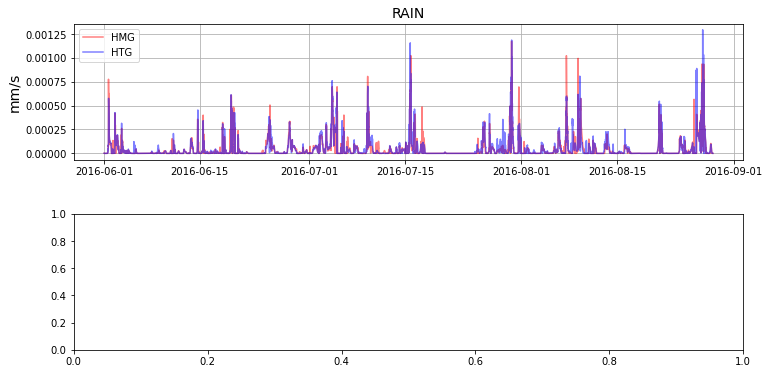

In [34]:
fig,axs = plt.subplots(2,1, figsize=(12,6))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

axs[0].plot(HMGclmDS_all['time'].values, np.squeeze(HMGclmDS_all.RAIN.values), 'r-', alpha=0.5, label='HMG')
axs[0].plot(HTGclmDS_all['time'].values, np.squeeze(HTGclmDS_all.RAIN.values), 'b-', alpha=0.5, label='HTG')
axs[0].legend()
axs[0].set_ylabel(HTGclmDS_all.RAIN.units,fontsize=14)
axs[0].set_title('RAIN',fontsize=14)
# axs[0].set_ylim([15,45])
axs[0].grid()



### Upsample to hourly means? 

In [18]:
# ## NOTE that calculating the hourly means does take a VERY long time to run
# HMGcamDS_hourly = HMGcamDS_all.resample(time="1H", keep_attrs=True).mean()
# HTGcamDS_hourly = HTGcamDS_all.resample(time="1H", keep_attrs=True).mean()

# HMGclmDS_hourly = HMGclmDS_all.resample(time="1H", keep_attrs=True).mean()
# HTGclmDS_hourly = HTGclmDS_all.resample(time="1H", keep_attrs=True).mean()


NameError: name 'HMGcamDS_hourly' is not defined

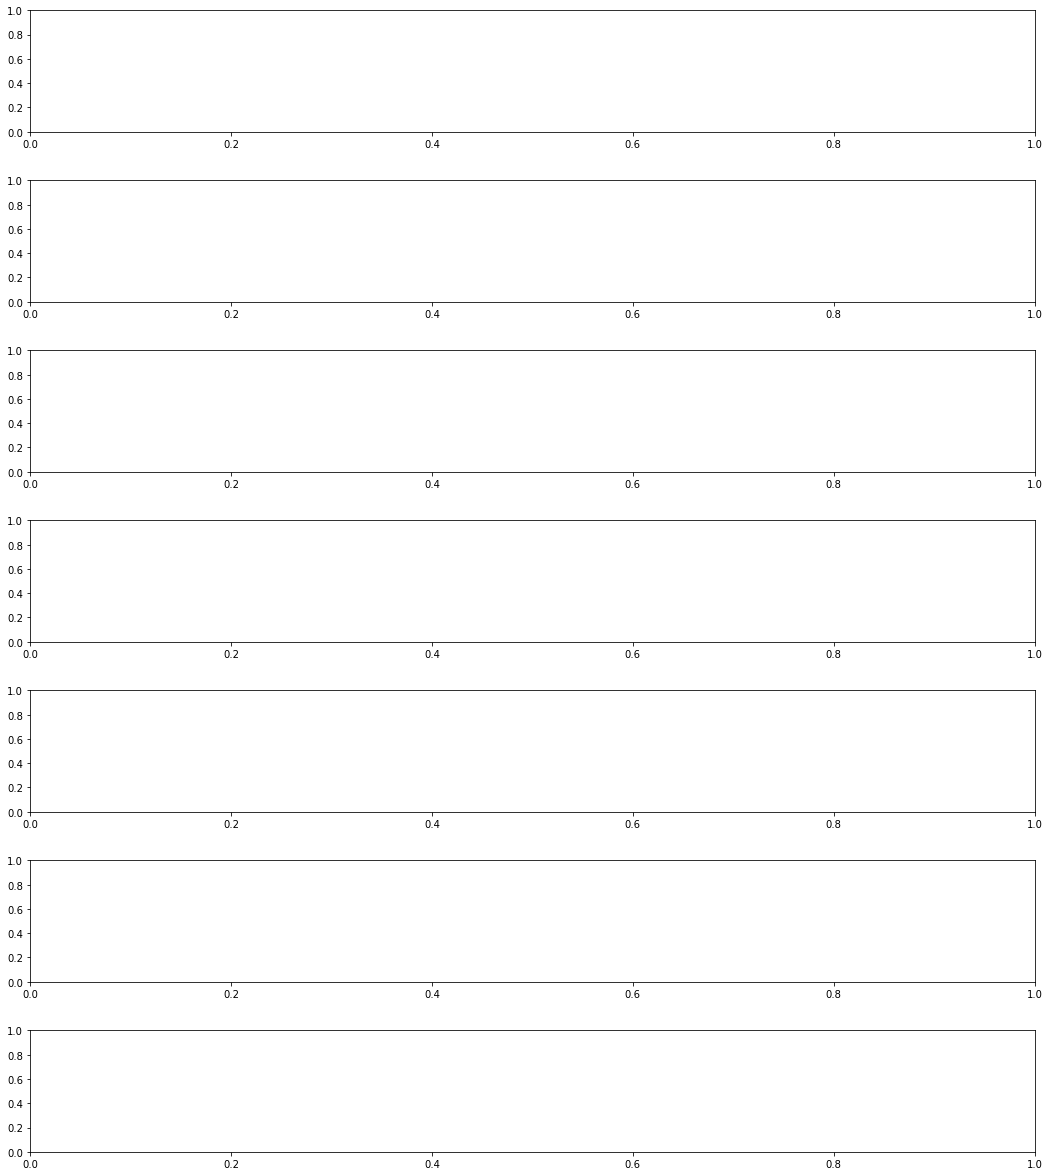

In [16]:
# fig,axs = plt.subplots(6,1, figsize=(18,21))
# axs = axs.ravel()
# fig.subplots_adjust(hspace=0.4)

# ATM_varNames = np.asarray(['PBLH','SHFLX','LHFLX','TREFHT','RHREFHT','PRECT'])
# # LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

# for iVar in range(6):
        
#     axs[iVar].plot(HMGcamDS_hourly['time'].values, np.squeeze(HMGcamDS_hourly[ATM_varNames[iVar]].values),
#                   'r-', alpha=0.7, label='CAM-HMG')
#     axs[iVar].plot(HTGcamDS_hourly['time'].values, np.squeeze(HTGcamDS_hourly[ATM_varNames[iVar]].values),
#                   'b-', alpha=0.7, label='CAM-HTG')

#     axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
#     axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units)
#     axs[iVar].legend()
#     axs[iVar].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])



### Mean diurnal cycle?

In [308]:
# Get means a function of hour of day
hourlyMean_HMG = HMGcamDS_all.groupby("time.hour").mean()
hourlyMean_HTG = HTGcamDS_all.groupby("time.hour").mean()

hourlyMean_HMG['TBOT'] = (('time','lat','lon'), hourlyMean_HMG.T.values[:,-1,:,:])
hourlyMean_HTG['TBOT'] = (('time','lat','lon'), hourlyMean_HTG.T.values[:,-1,:,:])

hourlyMean_HMG['TBOT'].attrs['units'] = 'K'
hourlyMean_HTG['TBOT'].attrs['units'] = 'K'


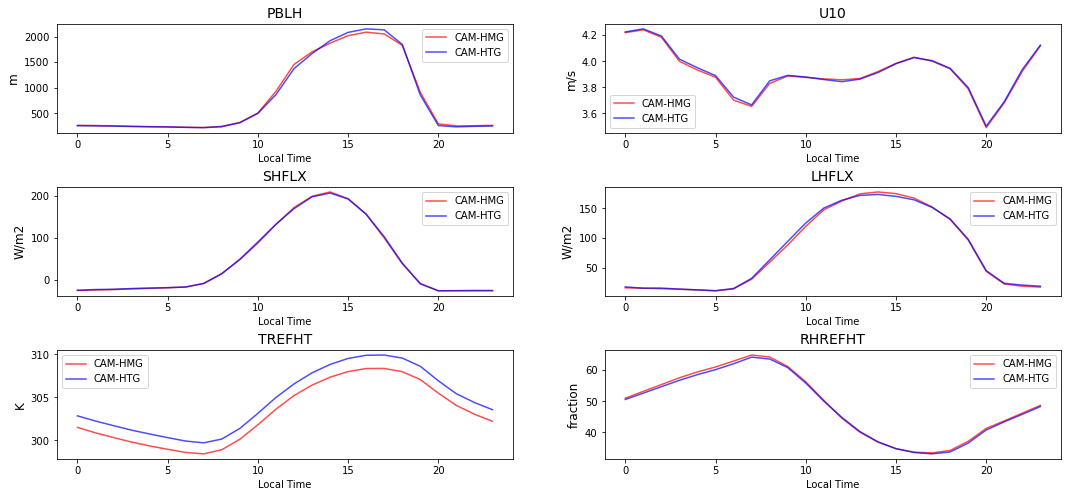

In [309]:
fig,axs = plt.subplots(3,2, figsize=(18,8))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['PBLH','U10','SHFLX','LHFLX','TREFHT','RHREFHT'])
# ATM_varNames = np.asarray(['TGCLDLWP','U10','SHFLX','LHFLX','TREFHT','RHREFHT'])


# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):
    # Make it show in local time 
    doubleVar_HMG = np.concatenate([np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values)[:],np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values)[:]])
    doubleVar_HTG = np.concatenate([np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values)[:],np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values)[:]])
    doubleHour    = np.concatenate([hourlyMean_HMG['hour'].values-5,hourlyMean_HMG['hour'].values-5+24])
       
    axs[iVar].plot(doubleHour[5:29], doubleVar_HMG[5:29],
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(doubleHour[5:29], doubleVar_HTG[5:29],
                  'b-', alpha=0.7, label='CAM-HTG')
    
#     axs[iVar].plot(hourlyMean_HMG['hour'].values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values),
#                   'r-', alpha=0.7, label='CAM-HMG')
#     axs[iVar].plot(hourlyMean_HTG['hour'].values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values),
#                   'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    
    if ATM_varNames[iVar]!='TBOT':
        axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(HMGcamDS['T'].units, fontsize=12)
        

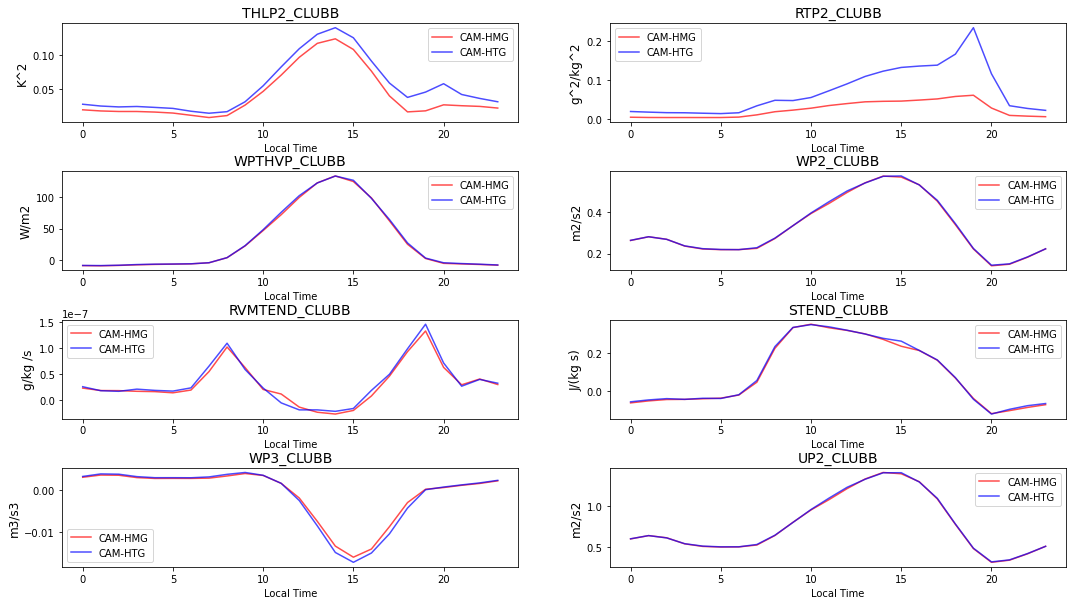

In [22]:
fig,axs = plt.subplots(4,2, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(8):
    # Make it show in local time 
    if ATM_varNames[iVar]!='WP3_CLUBB':
        doubleVar_HMG = np.concatenate([np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values)[:,-1],np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values)[:,-1]])
        doubleVar_HTG = np.concatenate([np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values)[:,-1],np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values)[:,-1]])
    else: 
        doubleVar_HMG = np.concatenate([np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values)[:,-2],np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values)[:,-2]])
        doubleVar_HTG = np.concatenate([np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values)[:,-2],np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values)[:,-2]])


    doubleHour    = np.concatenate([hourlyMean_HMG['hour'].values-5,hourlyMean_HMG['hour'].values-5+24])
       
    axs[iVar].plot(doubleHour[5:29], doubleVar_HMG[5:29],
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(doubleHour[5:29], doubleVar_HTG[5:29],
                  'b-', alpha=0.7, label='CAM-HTG')
    
#     axs[iVar].plot(hourlyMean_HMG['hour'].values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values),
#                   'r-', alpha=0.7, label='CAM-HMG')
#     axs[iVar].plot(hourlyMean_HTG['hour'].values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values),
#                   'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    
    if ATM_varNames[iVar]!='TBOT':
        axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(HMGcamDS['T'].units, fontsize=12)
        

In [147]:
## Convert to local times...
HMGcamDS_local = HMGcamDS_all.copy(deep=True)
HTGcamDS_local = HTGcamDS_all.copy(deep=True)

# Replace time dimension with local time
localTimes     = HMGcamDS_all['time'].values - np.timedelta64(5,'h')
HMGcamDS_local = HMGcamDS_local.assign_coords({"time": localTimes})
HTGcamDS_local = HTGcamDS_local.assign_coords({"time": localTimes})

# Get hourly means
hourlyMeanLocal_HMG = HMGcamDS_local.groupby("time.hour").mean()
hourlyMeanLocal_HTG = HTGcamDS_local.groupby("time.hour").mean()


In [153]:
# Select just June: 
iJune = np.where(HMGcamDS_local["time.month"]==8)[0]
HMGcamDS_localJune = HMGcamDS_local.isel(time=iJune)
HTGcamDS_localJune = HTGcamDS_local.isel(time=iJune)

# Get hourly means
hourlyMeanLocal_HMG = HMGcamDS_localJune.groupby("time.hour").mean()
hourlyMeanLocal_HTG = HTGcamDS_localJune.groupby("time.hour").mean()


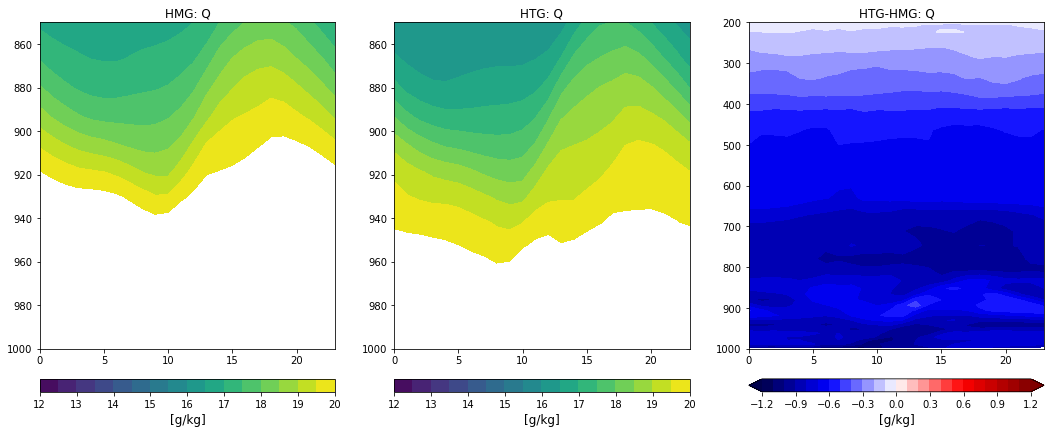

In [154]:
fig,axs = plt.subplots(1,3, figsize=(18,6))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

cLevels = np.arange(12,20.5, 0.5)

contour_plot = axs[0].contourf(hourlyMeanLocal_HMG.hour.values, hourlyMeanLocal_HMG.lev.values, 
                               np.squeeze(hourlyMeanLocal_HMG.Q.values*1000.0).transpose(),
                               #vmin=0.1, vmax=0.2)
                               levels=cLevels)
axs[0].set_ylim([850,1000])
axs[0].invert_yaxis()
axs[0].set_title('HMG: Q')
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[g/kg]',fontsize=12)

contour_plot = axs[1].contourf(hourlyMeanLocal_HTG.hour.values, hourlyMeanLocal_HTG.lev.values, 
                               np.squeeze(hourlyMeanLocal_HTG.Q.values*1000.0).transpose(),
                               #vmin=0.1, vmax=0.2)
                               levels=cLevels)
axs[1].set_ylim([850,1000])
axs[1].invert_yaxis()
axs[1].set_title('HTG: Q')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[g/kg]',fontsize=12)


# Also plot difference in the two: 
Qdiff    = np.squeeze(hourlyMeanLocal_HTG.Q.values*1000.0) - np.squeeze(hourlyMeanLocal_HMG.Q.values*1000.0)
diffLevs = np.arange(-1.2,1.3,0.1)

contour_plot = axs[2].contourf(hourlyMeanLocal_HTG.hour.values, hourlyMeanLocal_HTG.lev.values, 
                               Qdiff.transpose(),
                               cmap='seismic',
                               levels=diffLevs,
                              extend='both')
axs[2].set_ylim([200,1000])
axs[2].invert_yaxis()
axs[2].set_title('HTG-HMG: Q')
# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[g/kg]',fontsize=12)


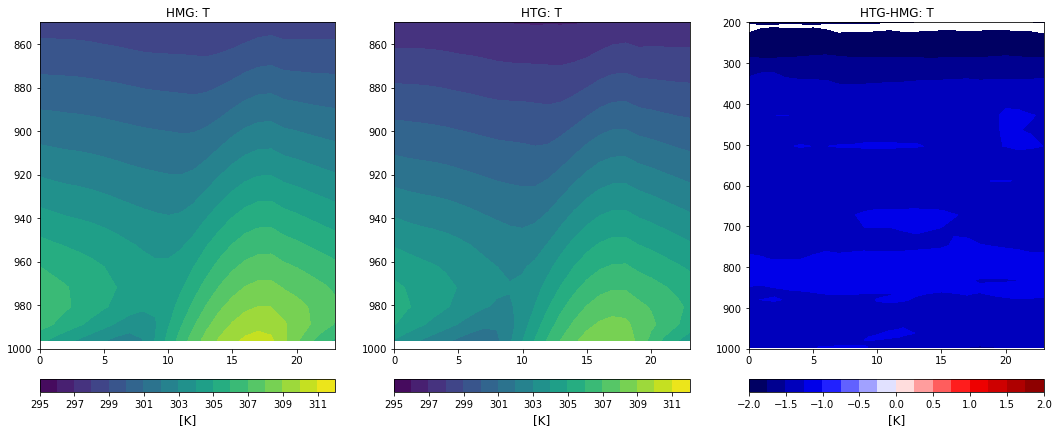

In [11]:
fig,axs = plt.subplots(1,3, figsize=(18,6))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

cLevels = np.arange(295,313,1)

contour_plot = axs[0].contourf(hourlyMeanLocal_HMG.hour.values, hourlyMeanLocal_HMG.lev.values, 
                               np.squeeze(hourlyMeanLocal_HMG.T.values).transpose(),
                               #vmin=0.1, vmax=0.2)
                               levels=cLevels)
axs[0].set_ylim([850,1000])
axs[0].invert_yaxis()
axs[0].set_title('HMG: T')
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[K]',fontsize=12)

contour_plot = axs[1].contourf(hourlyMeanLocal_HTG.hour.values, hourlyMeanLocal_HTG.lev.values, 
                               np.squeeze(hourlyMeanLocal_HTG.T.values).transpose(),
                               #vmin=0.1, vmax=0.2)
                               levels=cLevels)
axs[1].set_ylim([850,1000])
axs[1].invert_yaxis()
axs[1].set_title('HTG: T')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[K]',fontsize=12)


# Also plot difference in the two: 
Qdiff    = np.squeeze(hourlyMeanLocal_HTG.T.values) - np.squeeze(hourlyMeanLocal_HMG.T.values)
diffLevs = np.arange(-2,2.25,0.25)

contour_plot = axs[2].contourf(hourlyMeanLocal_HTG.hour.values, hourlyMeanLocal_HTG.lev.values, 
                               Qdiff.transpose(),
                               cmap='seismic',
                               levels=diffLevs)
axs[2].set_ylim([200,1000])
axs[2].invert_yaxis()
axs[2].set_title('HTG-HMG: T')
# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[K]',fontsize=12)



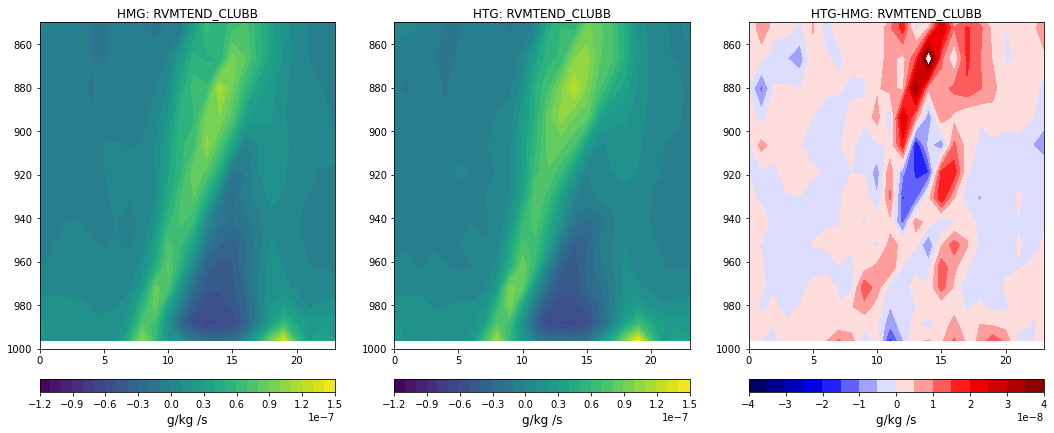

In [12]:
fig,axs = plt.subplots(1,3, figsize=(18,6))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

cLevels = np.arange(-1.2e-7, 1.6e-7, 0.1e-7)

contour_plot = axs[0].contourf(hourlyMeanLocal_HMG.hour.values, hourlyMeanLocal_HMG.lev.values, 
                               np.squeeze(hourlyMeanLocal_HMG.RVMTEND_CLUBB.values).transpose(), 
                               #vmin=0.1, vmax=0.2)
                               levels=cLevels)
axs[0].set_ylim([850,1000])
axs[0].invert_yaxis()
axs[0].set_title('HMG: RVMTEND_CLUBB')
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local.RVMTEND_CLUBB.units,fontsize=12)



contour_plot = axs[1].contourf(hourlyMeanLocal_HTG.hour.values, hourlyMeanLocal_HTG.lev.values, 
                               np.squeeze(hourlyMeanLocal_HTG.RVMTEND_CLUBB.values).transpose(),
                               #vmin=0.1, vmax=0.2)
                               levels=cLevels)
axs[1].set_ylim([850,1000])
axs[1].invert_yaxis()
axs[1].set_title('HTG: RVMTEND_CLUBB')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local.RVMTEND_CLUBB.units,fontsize=12)


# Also plot difference in the two: 
Qdiff    = np.squeeze(hourlyMeanLocal_HTG.RVMTEND_CLUBB.values) - np.squeeze(hourlyMeanLocal_HMG.RVMTEND_CLUBB.values)
diffLevs = np.arange(-4e-8, 4.1e-8, 0.5e-8)

contour_plot = axs[2].contourf(hourlyMeanLocal_HTG.hour.values, hourlyMeanLocal_HTG.lev.values, 
                               Qdiff.transpose(),
                               cmap='seismic',
                               levels=diffLevs)
axs[2].set_ylim([850,1000])
axs[2].invert_yaxis()
axs[2].set_title('HTG-HMG: RVMTEND_CLUBB')
# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local.RVMTEND_CLUBB.units,fontsize=12)



**What if we try to define the PBL as dQ/dz??**

In [9]:
## Need to use metPy conda env
import metpy.calc as mpc
from metpy.units import units

In [10]:
def PBLHasMaxDZ(DS, pbl_var): 
    # Convert HMGcamDS_all to height (nabbed from Rich's script)
    p0 = DS['P0'].values[0]
    
    plevm = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
    plevm.attrs['units'] = "Pa"

    # Height with standard atmosphere
    zlevm      = plevm
    zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
    zlevm      = plevm.copy(deep=True)
    zlevm[:,:] = zlevm_vals
    
    pvar        = DS[pbl_var].isel(lat=0,lon=0)
    pvar['lev'] = zlevm[0,:].values
    dvardz      = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

    dvardz.loc[:,200:]   = 0.  # Restrict to a specificheight region
    dvardz.loc[:,:3000.] = 0

    nT = np.shape(dvardz)[0]
    PBLdepth = np.full([nT], np.nan)

    for iT in range(nT):
        iLevs  = np.where((zlevm[iT,:]>=200) & (zlevm[iT,:]<=3000))[0]
        maxLev = np.where(dvardz[iT,iLevs]==np.nanmax(dvardz[iT,iLevs]))[0]
        PBLdepth[iT] = zlevm[iT,iLevs[maxLev[0]]]
    
    return PBLdepth

In [14]:
# # Convert HMGcamDS_all to height (nabbed from Rich's script) -- HMG
# p0 = HMGcamDS_all['P0'].values[0]

# plevm_hmg = HMGcamDS_all['hyam']*p0 + HMGcamDS_all['hybm']*HMGcamDS_all['PS'].isel(lat=0,lon=0) # Mid level
# plevm_hmg.attrs['units'] = "Pa"

# # Height with standard atmosphere
# zlevm_hmg = plevm_hmg
# zlevm_vals_hmg = 1000.*np.asarray(mpc.pressure_to_height_std(plevm_hmg)) # Units of [m] after multiplied 
# zlevm_hmg = plevm_hmg.copy(deep=True)
# zlevm_hmg[:,:] = zlevm_vals_hmg


# # Convert HMGcamDS_all to height (nabbed from Rich's script) -- HTG
# p0 = HTGcamDS_all['P0'].values[0]

# plevm_htg = HTGcamDS_all['hyam']*p0 + HTGcamDS_all['hybm']*HTGcamDS_all['PS'].isel(lat=0,lon=0) # Mid level
# plevm_htg.attrs['units'] = "Pa"

# # Height with standard atmosphere
# zlevm_htg = plevm_htg
# zlevm_vals_htg = 1000.*np.asarray(mpc.pressure_to_height_std(plevm_htg)) # Units of [m] after multiplied 
# zlevm_htg = plevm_htg.copy(deep=True)
# zlevm_htg[:,:] = zlevm_vals_htg




In [33]:
# # Also from Rich's script...
# # pbl_var = 'Q'
# pbl_var = 'T'

# pvar = HMGcamDS_all[pbl_var].isel(lat=0,lon=0)
# pvar['lev'] = zlevm_hmg[0,:].values
# dvardz_hmg = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

# dvardz_hmg.loc[:,200:]   = 0.  # Restrict to a specificheight region
# dvardz_hmg.loc[:,:3000.] = 0
    
# # dvardz_kmin = dvardz.argmin(axis=1) # Find the index of the maxium in the vertical
# # dvardz_zmin = dvardz.lev[dvardz_kmin[:]] # Height level of max/min level.
# # dvardz_ptop = dvardz.min(axis=1) # Actual value at min/max level.

# nT = np.shape(dvardz_hmg)[0]
# PBLdepth_hmg = np.full([nT], np.nan)

# for iT in range(nT):
#     iLevs_hmg = np.where((zlevm_hmg[iT,:]>=200) & (zlevm_hmg[iT,:]<=3000))[0]
#     maxLev_hmg = np.where(dvardz_hmg[iT,iLevs_hmg]==np.nanmax(dvardz_hmg[iT,iLevs_hmg]))[0]
#     PBLdepth_hmg[iT] = zlevm_hmg[iT,iLevs_hmg[maxLev_hmg[0]]]
    

In [34]:
# # Also from Rich's script...
# # pbl_var = 'Q'
# pbl_var = 'T'

# pvar = HTGcamDS_all[pbl_var].isel(lat=0,lon=0)
# pvar['lev'] = zlevm_htg[0,:].values
# dvardz_htg = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

# dvardz_htg.loc[:,200:]   = 0.  # Restrict to a specificheight region
# dvardz_htg.loc[:,:3000.] = 0
    
# # dvardz_kmin = dvardz.argmin(axis=1) # Find the index of the maxium in the vertical
# # dvardz_zmin = dvardz.lev[dvardz_kmin[:]] # Height level of max/min level.
# # dvardz_ptop = dvardz.min(axis=1) # Actual value at min/max level.

# nT = np.shape(dvardz_htg)[0]
# PBLdepth_htg = np.full([nT], np.nan)

# for iT in range(nT):
#     iLevs_htg = np.where((zlevm_htg[iT,:]>=200) & (zlevm_htg[iT,:]<=3000))[0]
#     maxLev_htg = np.where(dvardz_htg[iT,iLevs_htg]==np.nanmax(dvardz_htg[iT,iLevs_htg]))[0]
#     PBLdepth_htg[iT] = zlevm_htg[iT,iLevs_htg[maxLev_htg[0]]]
    

In [11]:
PBLdepth_hmg = PBLHasMaxDZ(HMGcamDS_all, 'T')
PBLdepth_htg = PBLHasMaxDZ(HTGcamDS_all, 'T')


In [12]:
## Add PBLdepth to camDS_all arrays, and get average diurnal cycle: 

HMGcamDS_all['PBLdepth'] = (('time'), PBLdepth_hmg)
HTGcamDS_all['PBLdepth'] = (('time'), PBLdepth_htg)

# HMGcamDS_all['dQdz'] = (('time','lev'), dvardz_hmg)
# HTGcamDS_all['dQdz'] = (('time','lev'), dvardz_htg)

# HMGcamDS_all['dTdz'] = (('time','lev'), dvardz_hmg)
# HTGcamDS_all['dTdz'] = (('time','lev'), dvardz_htg)

HMGcamDS_local = HMGcamDS_all.copy(deep=True)
HTGcamDS_local = HTGcamDS_all.copy(deep=True)

# Replace time dimension with local time
localTimes     = HMGcamDS_all['time'].values - np.timedelta64(5,'h')
HMGcamDS_local = HMGcamDS_local.assign_coords({"time": localTimes})
HTGcamDS_local = HTGcamDS_local.assign_coords({"time": localTimes})

# Get hourly means
hourlyMeanLocal_HMG = HMGcamDS_local.groupby("time.hour").mean()
hourlyMeanLocal_HTG = HTGcamDS_local.groupby("time.hour").mean()


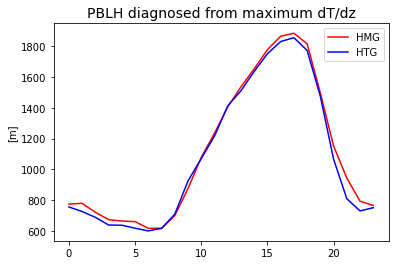

In [13]:
plt.plot(hourlyMeanLocal_HMG.hour.values, hourlyMeanLocal_HMG.PBLdepth.values, 'r', label='HMG')
plt.plot(hourlyMeanLocal_HTG.hour.values, hourlyMeanLocal_HTG.PBLdepth.values, 'b', label='HTG')
# plt.title('PBLH diagnosed from maximum dQ/dz',fontsize=14)
plt.title('PBLH diagnosed from maximum dT/dz',fontsize=14)
plt.ylabel('[m]')
plt.legend()


AttributeError: 'Dataset' object has no attribute 'dQdz'

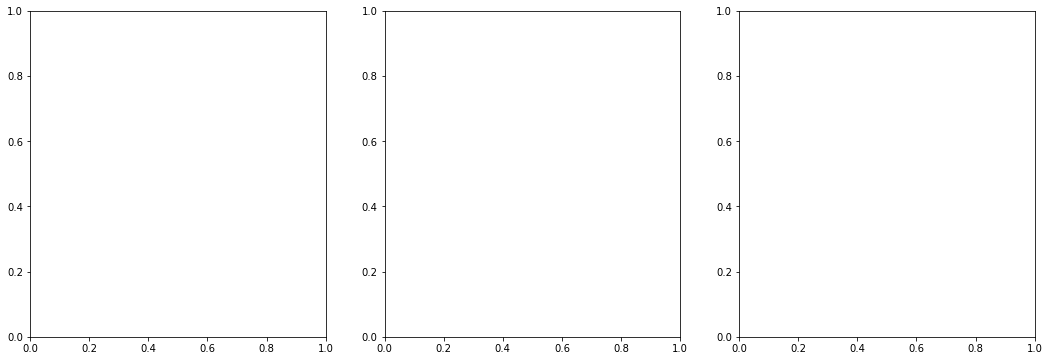

In [14]:
# fig,axs = plt.subplots(1,3, figsize=(18,6))
# axs = axs.ravel()
# # fig.subplots_adjust(hspace=0.5)

# cLevels = np.arange(-1.75e-5, 0.25e-5, 0.25e-5)

# contour_plot = axs[0].contourf(hourlyMeanLocal_HMG.hour.values, hourlyMeanLocal_HMG.lev.values, 
#                                np.squeeze(hourlyMeanLocal_HMG.dQdz.values).transpose(),
#                                #vmin=0.1, vmax=0.2)
#                                levels=cLevels)
# axs[0].set_ylim([850,1000])
# axs[0].invert_yaxis()
# axs[0].set_title('HMG: dQ/dz')
# # Add colorbar 
# ax_position = axs[0].get_position()
# cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
# cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label('[kg/kg /m]',fontsize=12)

# contour_plot = axs[1].contourf(hourlyMeanLocal_HTG.hour.values, hourlyMeanLocal_HTG.lev.values, 
#                                np.squeeze(hourlyMeanLocal_HTG.dQdz.values).transpose(),
#                                #vmin=0.1, vmax=0.2)
#                                levels=cLevels)
# axs[1].set_ylim([850,1000])
# axs[1].invert_yaxis()
# axs[1].set_title('HTG: dQ/dz')
# # Add colorbar 
# ax_position = axs[1].get_position()
# cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
# cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label('[kg/kg /m]',fontsize=12)


# # Also plot difference in the two: 
# Qdiff    = np.squeeze(hourlyMeanLocal_HTG.dQdz.values) - np.squeeze(hourlyMeanLocal_HMG.dQdz.values)
# diffLevs = np.arange(-3e-6,3.25e-6,0.5e-6)

# contour_plot = axs[2].contourf(hourlyMeanLocal_HTG.hour.values, hourlyMeanLocal_HTG.lev.values, 
#                                Qdiff.transpose(),
#                                cmap='seismic',
#                                levels=diffLevs)
# axs[2].set_ylim([850,1000])
# axs[2].invert_yaxis()
# axs[2].set_title('HTG-HMG: dQ/dz')
# # Add colorbar 
# ax_position = axs[2].get_position()
# cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
# cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label('[kg/kg /m]',fontsize=12)



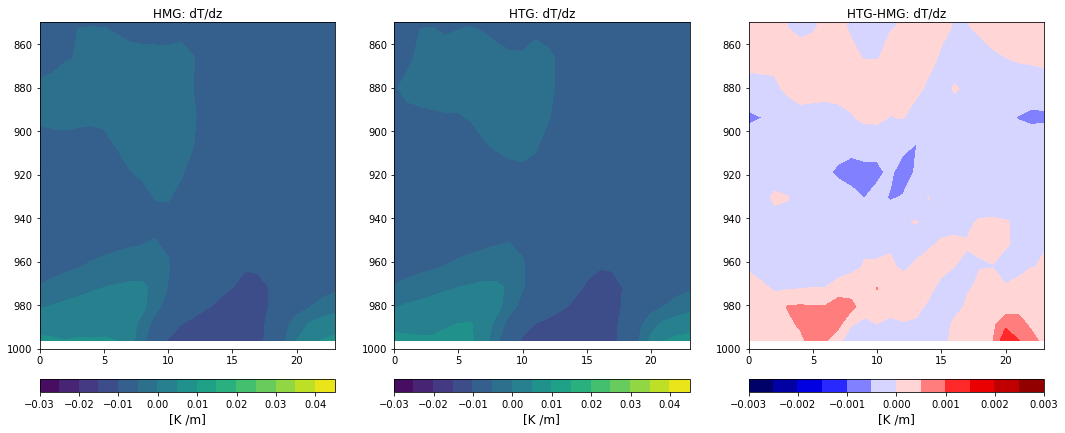

In [20]:
# fig,axs = plt.subplots(1,3, figsize=(18,6))
# axs = axs.ravel()
# # fig.subplots_adjust(hspace=0.5)

# cLevels = np.arange(-0.03, 0.05, 0.005)

# contour_plot = axs[0].contourf(hourlyMeanLocal_HMG.hour.values, hourlyMeanLocal_HMG.lev.values, 
#                                np.squeeze(hourlyMeanLocal_HMG.dTdz.values).transpose(),
#                                #vmin=0.1, vmax=0.2)
#                                levels=cLevels)
# axs[0].set_ylim([850,1000])
# axs[0].invert_yaxis()
# axs[0].set_title('HMG: dT/dz')
# # Add colorbar 
# ax_position = axs[0].get_position()
# cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
# cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label('[K /m]',fontsize=12)

# contour_plot = axs[1].contourf(hourlyMeanLocal_HTG.hour.values, hourlyMeanLocal_HTG.lev.values, 
#                                np.squeeze(hourlyMeanLocal_HTG.dTdz.values).transpose(),
#                                #vmin=0.1, vmax=0.2)
#                                levels=cLevels)
# axs[1].set_ylim([850,1000])
# axs[1].invert_yaxis()
# axs[1].set_title('HTG: dT/dz')
# # Add colorbar 
# ax_position = axs[1].get_position()
# cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
# cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label('[K /m]',fontsize=12)


# # Also plot difference in the two: 
# Qdiff    = np.squeeze(hourlyMeanLocal_HTG.dTdz.values) - np.squeeze(hourlyMeanLocal_HMG.dTdz.values)
# diffLevs = np.arange(-0.003,0.0035,0.0005)

# contour_plot = axs[2].contourf(hourlyMeanLocal_HTG.hour.values, hourlyMeanLocal_HTG.lev.values, 
#                                Qdiff.transpose(),
#                                cmap='seismic',
#                                levels=diffLevs)
# axs[2].set_ylim([850,1000])
# axs[2].invert_yaxis()
# axs[2].set_title('HTG-HMG: dT/dz')
# # Add colorbar 
# ax_position = axs[2].get_position()
# cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
# cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label('[K /m]',fontsize=12)


### What causes evening peak in RTP2 and THLP2? 

This will have to be looked to in at a later date. Right now, my clm2.h1. files don't have temperature/humidity of each patch saved out, and teh CLUBB variables in particualr are just the grid cell means (so it would take some configuring to output something useful per *patch* in CLM). 

In [44]:
# ### 
# #   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
# #   This version uses an finidat file from June, not January 
# #   This version also prescribes u'2, v'2, and w'2.
# #   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
# ###

# dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

# # Define file names of cam history files
# hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-08-09-36585.nc'])

# htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-08-09-36585.nc'])

# # Define file names of clm history files 
# hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h1.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h1.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h1.2015-08-09-36585.nc'])

# htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h1.2015-05-31-84585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h1.2015-07-05-60585.nc',
#                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h1.2015-08-09-36585.nc'])

# for iFile in range(len(hmgLNDfiles)): 
    
#     with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
#         HTGcamDS = cesm_correct_time(HTGcamDS)
#         HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
#     with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
#         HMGcamDS = cesm_correct_time(HMGcamDS)
#         HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
#     with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
#         HTGclmDS['time'] = HTGcamDS.time
#     with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
#         HMGclmDS['time'] = HMGcamDS.time
    
#     if iFile==0:
#         HTGclmDS_allPatch = HTGclmDS
#         HMGclmDS_allPatch = HMGclmDS 
#     else: 
#         HTGclmDS_allPatch = xr.concat([HTGclmDS_allPatch,HTGclmDS], dim='time', data_vars='minimal')
#         HMGclmDS_allPatch = xr.concat([HMGclmDS_allPatch,HMGclmDS], dim='time', data_vars='minimal')
        
#     print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


### Separate rainy vs. dry periods?


In [15]:
## Convert to local times...
HMGcamDS_local = HMGcamDS_all.copy(deep=True)
HTGcamDS_local = HTGcamDS_all.copy(deep=True)

# Replace time dimension with local time
localTimes = HMGcamDS_all['time'].values - np.timedelta64(5,'h')
HMGcamDS_local = HMGcamDS_local.assign_coords({"time": localTimes})
HTGcamDS_local = HTGcamDS_local.assign_coords({"time": localTimes})


In [16]:
## Add month-day dimension to use in summing rainfall over each day 
month_day_idx                      = pd.MultiIndex.from_arrays([HMGcamDS_local['time.month'].values, 
                                                                HMGcamDS_local['time.day'].values])
HMGcamDS_local.coords['month_day'] = ('time', month_day_idx)


month_day_idx                      = pd.MultiIndex.from_arrays([HTGcamDS_local['time.month'].values, 
                                                                HTGcamDS_local['time.day'].values])
HTGcamDS_local.coords['month_day'] = ('time', month_day_idx)


In [17]:
# PRECT defined as mean [m/s] over 20m timestep, 
#   so multiply by seconds in a 20m timestep and by 1000 mm/m to turn into  [mm/20 min]
HMGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_local.PRECT.values*1200.0*1000.0)
HTGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_local.PRECT.values*1200.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySum = HMGcamDS_local.groupby('month_day').sum()
HTGcamDS_localDailySum = HTGcamDS_local.groupby('month_day').sum()


In [18]:
# Define cutoff for classifying a "dry day" [mm/day] 
# prectCutoff = 0.001
prectCutoff = 0.01



In [19]:
# First, get month/days that qualify as dry days 
dryDaysSum = np.where((HTGcamDS_localDailySum.PRECT_mmPerDT.values < prectCutoff) & 
                      (HMGcamDS_localDailySum.PRECT_mmPerDT.values < prectCutoff))[0]
dryDaySums_HTG = HTGcamDS_localDailySum.isel(month_day = dryDaysSum)
# Next, get the times in the full array that line up with those dry days above 
iDry = []
for iTime in range(len(dryDaySums_HTG.month_day.values)):
    iKeepTimes = np.where((HTGcamDS_local['time.month']==dryDaySums_HTG.month_day_level_0.values[iTime]) & 
                          (HTGcamDS_local['time.day']==dryDaySums_HTG.month_day_level_1.values[iTime]))[0]    
    iDry = np.append(iDry, iKeepTimes).astype(int)
# Now select only those times in the local time array
dryDays_HTG = HTGcamDS_local.isel(time=iDry)
dryDays_HMG = HMGcamDS_local.isel(time=iDry)


#Do the same for wet days 
wetDaysSum = np.where((HTGcamDS_localDailySum.PRECT_mmPerDT.values >= prectCutoff) & 
                      (HMGcamDS_localDailySum.PRECT_mmPerDT.values >= prectCutoff))[0]
wetDaySums_HTG = HTGcamDS_localDailySum.isel(month_day = wetDaysSum)
iWet = []
for iTime in range(len(wetDaySums_HTG.month_day.values)):
    iKeepTimes = np.where((HTGcamDS_local['time.month']==wetDaySums_HTG.month_day_level_0.values[iTime]) & 
                          (HTGcamDS_local['time.day']==wetDaySums_HTG.month_day_level_1.values[iTime]))[0]    
    iWet = np.append(iWet, iKeepTimes).astype(int)
# Now select only those times in the local time array
wetDays_HTG = HTGcamDS_local.isel(time=iWet)
wetDays_HMG = HMGcamDS_local.isel(time=iWet)


print(' # Dry days %i \n # Wet days %i' % (len(dryDaySums_HTG.month_day.values), 
                                           len(wetDaySums_HTG.month_day.values)))



 # Dry days 10 
 # Wet days 77


In [20]:
# Get means a function of hour of day
hourlyMean_localDry_HMG = dryDays_HMG.groupby("time.hour").mean()
hourlyMean_localDry_HTG = dryDays_HTG.groupby("time.hour").mean()

hourlyMean_localWet_HMG = wetDays_HMG.groupby("time.hour").mean()
hourlyMean_localWet_HTG = wetDays_HTG.groupby("time.hour").mean()

Text(0.5, 1.0, 'PBLH evolution')

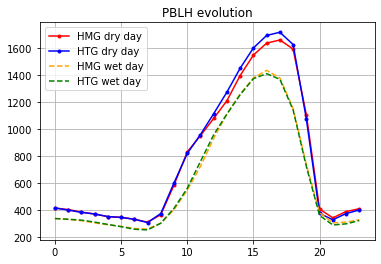

In [21]:
plt.plot(hourlyMean_localDry_HMG.hour.values, np.squeeze(hourlyMean_localDry_HMG.PBLH.values),'r.-',
        label = 'HMG dry day')
plt.plot(hourlyMean_localDry_HTG.hour.values, np.squeeze(hourlyMean_localDry_HTG.PBLH.values),'b.-',
        label = 'HTG dry day')

plt.plot(hourlyMean_localWet_HMG.hour.values, np.squeeze(hourlyMean_localWet_HMG.PBLH.values),'--',
         color='orange',
        label = 'HMG wet day')
plt.plot(hourlyMean_localWet_HTG.hour.values, np.squeeze(hourlyMean_localWet_HTG.PBLH.values),'--',
         color='green',
        label = 'HTG wet day')

plt.legend()
plt.grid()

plt.title('PBLH evolution')


Text(0.5, 1.0, 'PBLH [max dT/dz] evolution')

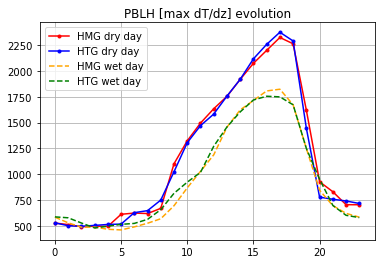

In [26]:
plt.plot(hourlyMean_localDry_HMG.hour.values, np.squeeze(hourlyMean_localDry_HMG.PBLdepth.values),'r.-',
        label = 'HMG dry day')
plt.plot(hourlyMean_localDry_HTG.hour.values, np.squeeze(hourlyMean_localDry_HTG.PBLdepth.values),'b.-',
        label = 'HTG dry day')

plt.plot(hourlyMean_localWet_HMG.hour.values, np.squeeze(hourlyMean_localWet_HMG.PBLdepth.values),'--',
         color='orange',
        label = 'HMG wet day')
plt.plot(hourlyMean_localWet_HTG.hour.values, np.squeeze(hourlyMean_localWet_HTG.PBLdepth.values),'--',
         color='green',
        label = 'HTG wet day')

plt.legend()
plt.grid()

plt.title('PBLH [max dT/dz] evolution')


In [22]:
## Get morning-mean arrays (8a-11a)

iMornings_HMG = np.where((hourlyMean_localDry_HMG.hour>=8) & 
                           (hourlyMean_localDry_HMG.hour<11))[0]
iMornings_HTG = np.where((hourlyMean_localDry_HTG.hour>=8) & 
                           (hourlyMean_localDry_HTG.hour<11))[0]

hourlyMean_localDryMorning_HMG = hourlyMean_localDry_HMG.isel(hour=iMornings_HMG).mean(dim='hour')
hourlyMean_localDryMorning_HTG = hourlyMean_localDry_HTG.isel(hour=iMornings_HTG).mean(dim='hour')



In [23]:
## Compute for wet-day mornings too
iMornings_HMG = np.where((hourlyMean_localWet_HMG.hour>=8) & 
                           (hourlyMean_localWet_HMG.hour<11))[0]
iMornings_HTG = np.where((hourlyMean_localWet_HTG.hour>=8) & 
                           (hourlyMean_localWet_HTG.hour<11))[0]

hourlyMean_localWetMorning_HMG = hourlyMean_localWet_HMG.isel(hour=iMornings_HMG).mean(dim='hour')
hourlyMean_localWetMorning_HTG = hourlyMean_localWet_HTG.isel(hour=iMornings_HTG).mean(dim='hour')

# Logical to toggle plotting wet day profiles too
plotWetDay = 'true'


(0.0, 0.06)

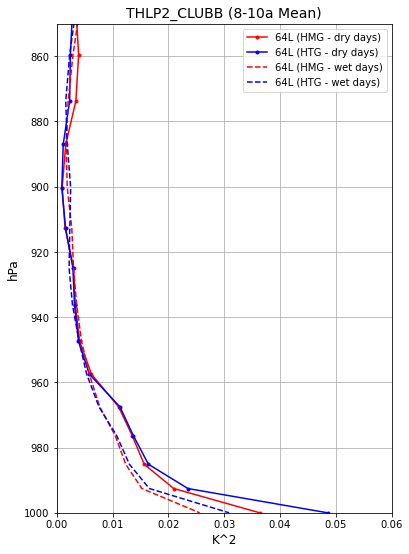

In [24]:
## Plot vertical profiles 

varSel = 'THLP2_CLUBB'

fig,axs = plt.subplots(1,1, figsize=(6,9))

axs.plot(np.squeeze(hourlyMean_localDryMorning_HMG[varSel].values), 
         hourlyMean_localDryMorning_HMG.ilev.values,'r.-',label='64L (HMG - dry days)')
axs.plot(np.squeeze(hourlyMean_localDryMorning_HTG[varSel].values), 
         hourlyMean_localDryMorning_HTG.ilev.values,'b.-',label='64L (HTG - dry days)')

if plotWetDay=='true':
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HMG[varSel].values), 
         hourlyMean_localWetMorning_HMG.ilev.values,'r--',label='64L (HMG - wet days)')
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HTG[varSel].values), 
             hourlyMean_localWetMorning_HTG.ilev.values,'b--',label='64L (HTG - wet days)')

axs.set_ylim([850,1000])
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' (8-10a Mean)',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()
axs.set_xlim([0.0, 0.06])

(0.0, 0.15)

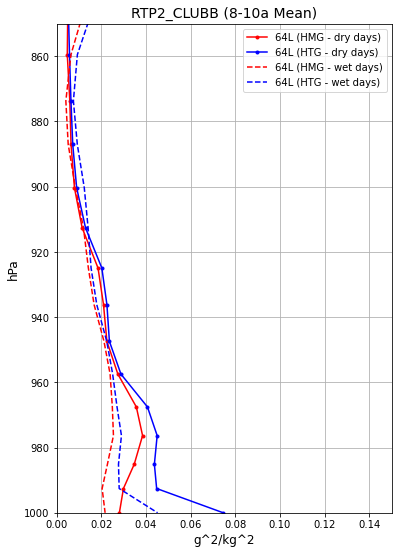

In [25]:
## Plot vertical profiles 

varSel = 'RTP2_CLUBB'

fig,axs = plt.subplots(1,1, figsize=(6,9))

axs.plot(np.squeeze(hourlyMean_localDryMorning_HMG[varSel].values), 
         hourlyMean_localDryMorning_HMG.ilev.values,'r.-',label='64L (HMG - dry days)')
axs.plot(np.squeeze(hourlyMean_localDryMorning_HTG[varSel].values), 
         hourlyMean_localDryMorning_HTG.ilev.values,'b.-',label='64L (HTG - dry days)')

if plotWetDay=='true':
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HMG[varSel].values), 
         hourlyMean_localWetMorning_HMG.ilev.values,'r--',label='64L (HMG - wet days)')
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HTG[varSel].values), 
             hourlyMean_localWetMorning_HTG.ilev.values,'b--',label='64L (HTG - wet days)')
    
    
axs.set_ylim([850,1000])
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' (8-10a Mean)',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()
axs.set_xlim([0.0, 0.15])


(-0.02, 0.05)

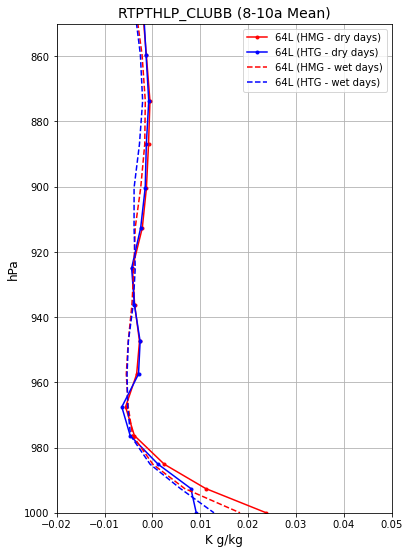

In [26]:
## Plot vertical profiles 

varSel = 'RTPTHLP_CLUBB'

fig,axs = plt.subplots(1,1, figsize=(6,9))

axs.plot(np.squeeze(hourlyMean_localDryMorning_HMG[varSel].values), 
         hourlyMean_localDryMorning_HMG.ilev.values,'r.-',label='64L (HMG - dry days)')
axs.plot(np.squeeze(hourlyMean_localDryMorning_HTG[varSel].values), 
         hourlyMean_localDryMorning_HTG.ilev.values,'b.-',label='64L (HTG - dry days)')

if plotWetDay=='true':
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HMG[varSel].values), 
         hourlyMean_localWetMorning_HMG.ilev.values,'r--',label='64L (HMG - wet days)')
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HTG[varSel].values), 
             hourlyMean_localWetMorning_HTG.ilev.values,'b--',label='64L (HTG - wet days)')
    
    
axs.set_ylim([850,1000])
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' (8-10a Mean)',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()
axs.set_xlim([-0.02, 0.05])


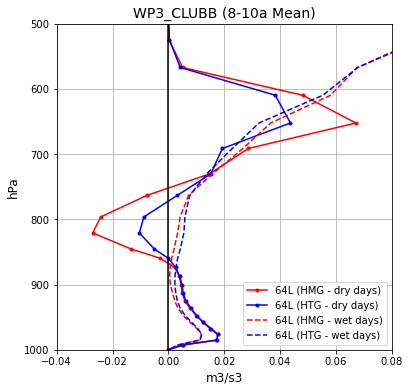

In [27]:
## Plot vertical profiles 

varSel = 'WP3_CLUBB'

fig,axs = plt.subplots(1,1, figsize=(6,6))

axs.plot(np.squeeze(hourlyMean_localDryMorning_HMG[varSel].values), 
         hourlyMean_localDryMorning_HMG.ilev.values,'r.-',label='64L (HMG - dry days)')
axs.plot(np.squeeze(hourlyMean_localDryMorning_HTG[varSel].values), 
         hourlyMean_localDryMorning_HTG.ilev.values,'b.-',label='64L (HTG - dry days)')

if plotWetDay=='true':
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HMG[varSel].values), 
         hourlyMean_localWetMorning_HMG.ilev.values,'r--',label='64L (HMG - wet days)')
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HTG[varSel].values), 
             hourlyMean_localWetMorning_HTG.ilev.values,'b--',label='64L (HTG - wet days)')
    
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' (8-10a Mean)',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()

axs.set_ylim([1000,500])
# axs.set_xlim([-0.004, 0.025])
axs.set_xlim([-0.04, 0.07])
axs.set_xlim([-0.04, 0.08])

axs.axvline(0,color='k')


(0.0, 0.5)

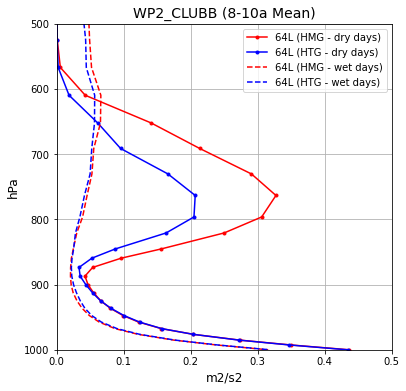

In [28]:
## Plot vertical profiles 

varSel = 'WP2_CLUBB'

fig,axs = plt.subplots(1,1, figsize=(6,6))

axs.plot(np.squeeze(hourlyMean_localDryMorning_HMG[varSel].values), 
         hourlyMean_localDryMorning_HMG.ilev.values,'r.-',label='64L (HMG - dry days)')
axs.plot(np.squeeze(hourlyMean_localDryMorning_HTG[varSel].values), 
         hourlyMean_localDryMorning_HTG.ilev.values,'b.-',label='64L (HTG - dry days)')

if plotWetDay=='true':
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HMG[varSel].values), 
         hourlyMean_localWetMorning_HMG.ilev.values,'r--',label='64L (HMG - wet days)')
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HTG[varSel].values), 
             hourlyMean_localWetMorning_HTG.ilev.values,'b--',label='64L (HTG - wet days)')
    
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' (8-10a Mean)',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()

axs.set_ylim([1000,500])
axs.set_xlim([0, 0.5])



(0.0, 1.1)

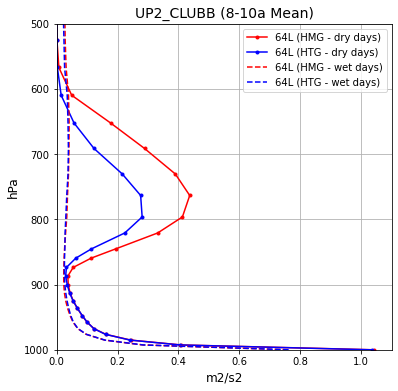

In [29]:
## Plot vertical profiles 

varSel = 'UP2_CLUBB'

fig,axs = plt.subplots(1,1, figsize=(6,6))

axs.plot(np.squeeze(hourlyMean_localDryMorning_HMG[varSel].values), 
         hourlyMean_localDryMorning_HMG.ilev.values,'r.-',label='64L (HMG - dry days)')
axs.plot(np.squeeze(hourlyMean_localDryMorning_HTG[varSel].values), 
         hourlyMean_localDryMorning_HTG.ilev.values,'b.-',label='64L (HTG - dry days)')

if plotWetDay=='true':
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HMG[varSel].values), 
         hourlyMean_localWetMorning_HMG.ilev.values,'r--',label='64L (HMG - wet days)')
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HTG[varSel].values), 
             hourlyMean_localWetMorning_HTG.ilev.values,'b--',label='64L (HTG - wet days)')
    
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' (8-10a Mean)',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()

axs.set_ylim([1000,500])
axs.set_xlim([0, 1.1])




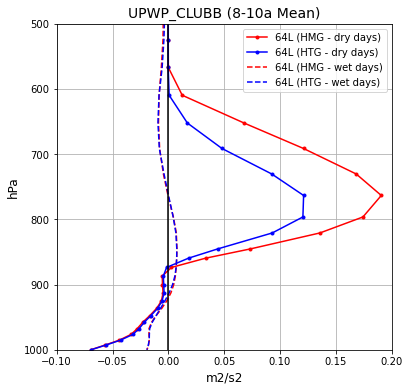

In [33]:
## Plot vertical profiles 

varSel = 'UPWP_CLUBB'

fig,axs = plt.subplots(1,1, figsize=(6,6))

axs.plot(np.squeeze(hourlyMean_localDryMorning_HMG[varSel].values), 
         hourlyMean_localDryMorning_HMG.ilev.values,'r.-',label='64L (HMG - dry days)')
axs.plot(np.squeeze(hourlyMean_localDryMorning_HTG[varSel].values), 
         hourlyMean_localDryMorning_HTG.ilev.values,'b.-',label='64L (HTG - dry days)')

if plotWetDay=='true':
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HMG[varSel].values), 
         hourlyMean_localWetMorning_HMG.ilev.values,'r--',label='64L (HMG - wet days)')
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HTG[varSel].values), 
             hourlyMean_localWetMorning_HTG.ilev.values,'b--',label='64L (HTG - wet days)')
    
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' (8-10a Mean)',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()

axs.set_ylim([1000,500])
# axs.set_xlim([-0.1, 0.04])
axs.set_xlim([-0.1, 0.2])

axs.axvline(0,color='k')


(1000.0, 500.0)

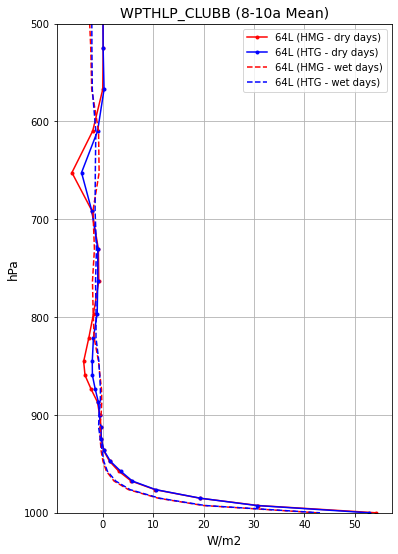

In [30]:
## Plot vertical profiles 

varSel = 'WPTHLP_CLUBB'

fig,axs = plt.subplots(1,1, figsize=(6,9))

axs.plot(np.squeeze(hourlyMean_localDryMorning_HMG[varSel].values), 
         hourlyMean_localDryMorning_HMG.ilev.values,'r.-',label='64L (HMG - dry days)')
axs.plot(np.squeeze(hourlyMean_localDryMorning_HTG[varSel].values), 
         hourlyMean_localDryMorning_HTG.ilev.values,'b.-',label='64L (HTG - dry days)')

if plotWetDay=='true':
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HMG[varSel].values), 
         hourlyMean_localWetMorning_HMG.ilev.values,'r--',label='64L (HMG - wet days)')
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HTG[varSel].values), 
             hourlyMean_localWetMorning_HTG.ilev.values,'b--',label='64L (HTG - wet days)')
    
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' (8-10a Mean)',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()

axs.set_ylim([1000,500])
# axs.set_xlim([-0.1, 0.04])



(1000.0, 500.0)

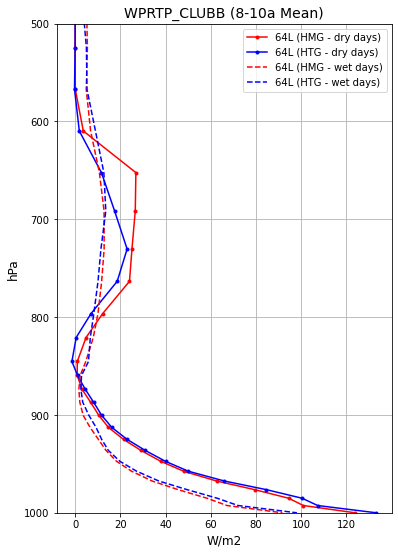

In [31]:
## Plot vertical profiles 

varSel = 'WPRTP_CLUBB'

fig,axs = plt.subplots(1,1, figsize=(6,9))

axs.plot(np.squeeze(hourlyMean_localDryMorning_HMG[varSel].values), 
         hourlyMean_localDryMorning_HMG.ilev.values,'r.-',label='64L (HMG - dry days)')
axs.plot(np.squeeze(hourlyMean_localDryMorning_HTG[varSel].values), 
         hourlyMean_localDryMorning_HTG.ilev.values,'b.-',label='64L (HTG - dry days)')

if plotWetDay=='true':
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HMG[varSel].values), 
         hourlyMean_localWetMorning_HMG.ilev.values,'r--',label='64L (HMG - wet days)')
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HTG[varSel].values), 
             hourlyMean_localWetMorning_HTG.ilev.values,'b--',label='64L (HTG - wet days)')
    
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' (8-10a Mean)',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()

axs.set_ylim([1000,500])
# axs.set_xlim([-0.1, 0.04])




(1000.0, 500.0)

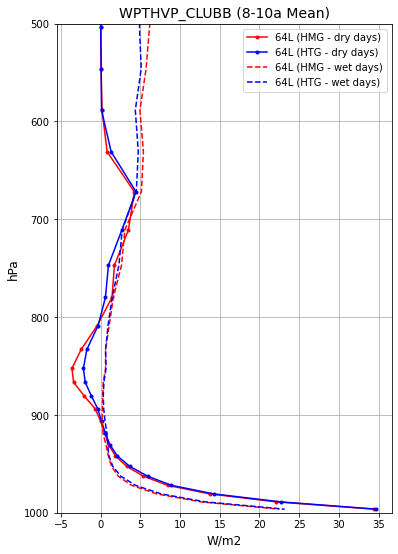

In [32]:
## Plot vertical profiles 

varSel = 'WPTHVP_CLUBB'

fig,axs = plt.subplots(1,1, figsize=(6,9))

axs.plot(np.squeeze(hourlyMean_localDryMorning_HMG[varSel].values), 
         hourlyMean_localDryMorning_HMG.lev.values,'r.-',label='64L (HMG - dry days)')
axs.plot(np.squeeze(hourlyMean_localDryMorning_HTG[varSel].values), 
         hourlyMean_localDryMorning_HTG.lev.values,'b.-',label='64L (HTG - dry days)')

if plotWetDay=='true':
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HMG[varSel].values), 
         hourlyMean_localWetMorning_HMG.lev.values,'r--',label='64L (HMG - wet days)')
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HTG[varSel].values), 
             hourlyMean_localWetMorning_HTG.lev.values,'b--',label='64L (HTG - wet days)')
    
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' (8-10a Mean)',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()

axs.set_ylim([1000,500])
# axs.set_xlim([-0.1, 0.04])


(-3e-08, 2e-07)

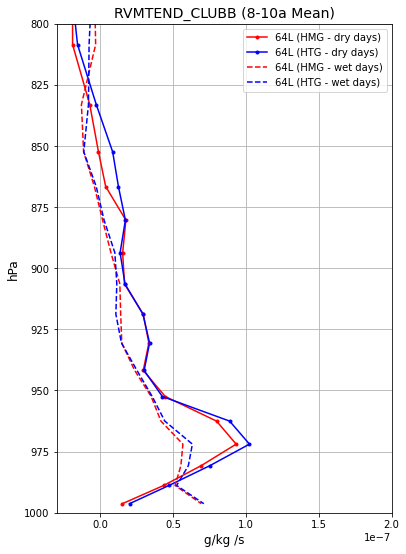

In [33]:
## Plot vertical profiles 

varSel = 'RVMTEND_CLUBB'

fig,axs = plt.subplots(1,1, figsize=(6,9))

axs.plot(np.squeeze(hourlyMean_localDryMorning_HMG[varSel].values), 
         hourlyMean_localDryMorning_HMG.lev.values,'r.-',label='64L (HMG - dry days)')
axs.plot(np.squeeze(hourlyMean_localDryMorning_HTG[varSel].values), 
         hourlyMean_localDryMorning_HTG.lev.values,'b.-',label='64L (HTG - dry days)')

if plotWetDay=='true':
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HMG[varSel].values), 
         hourlyMean_localWetMorning_HMG.lev.values,'r--',label='64L (HMG - wet days)')
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HTG[varSel].values), 
             hourlyMean_localWetMorning_HTG.lev.values,'b--',label='64L (HTG - wet days)')
    
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' (8-10a Mean)',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()

axs.set_ylim([1000,800])
axs.set_xlim([-0.3e-7, 2e-7])



(1000.0, 800.0)

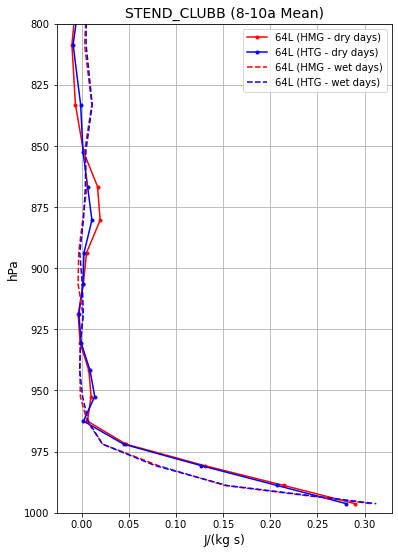

In [34]:
## Plot vertical profiles 

varSel = 'STEND_CLUBB'

fig,axs = plt.subplots(1,1, figsize=(6,9))

axs.plot(np.squeeze(hourlyMean_localDryMorning_HMG[varSel].values), 
         hourlyMean_localDryMorning_HMG.lev.values,'r.-',label='64L (HMG - dry days)')
axs.plot(np.squeeze(hourlyMean_localDryMorning_HTG[varSel].values), 
         hourlyMean_localDryMorning_HTG.lev.values,'b.-',label='64L (HTG - dry days)')

if plotWetDay=='true':
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HMG[varSel].values), 
         hourlyMean_localWetMorning_HMG.lev.values,'r--',label='64L (HMG - wet days)')
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HTG[varSel].values), 
             hourlyMean_localWetMorning_HTG.lev.values,'b--',label='64L (HTG - wet days)')
    
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' (8-10a Mean)',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()

axs.set_ylim([1000,800])
# axs.set_xlim([-0.3e-7, 2e-7])




(235.0, 305.0)

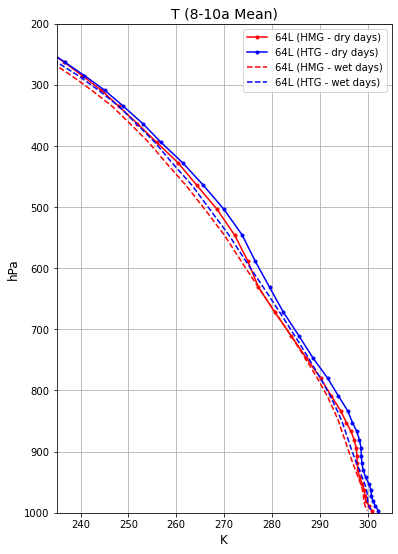

In [41]:
## Plot vertical profiles 

varSel = 'T'

fig,axs = plt.subplots(1,1, figsize=(6,9))

axs.plot(np.squeeze(hourlyMean_localDryMorning_HMG[varSel].values), 
         hourlyMean_localDryMorning_HMG.lev.values,'r.-',label='64L (HMG - dry days)')
axs.plot(np.squeeze(hourlyMean_localDryMorning_HTG[varSel].values), 
         hourlyMean_localDryMorning_HTG.lev.values,'b.-',label='64L (HTG - dry days)')

if plotWetDay=='true':
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HMG[varSel].values), 
         hourlyMean_localWetMorning_HMG.lev.values,'r--',label='64L (HMG - wet days)')
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HTG[varSel].values), 
             hourlyMean_localWetMorning_HTG.lev.values,'b--',label='64L (HTG - wet days)')
    
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' (8-10a Mean)',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()

axs.set_ylim([1000,500])
axs.set_xlim([265, 305])

axs.set_ylim([1000,200])
axs.set_xlim([235, 305])


(0.0, 0.02)

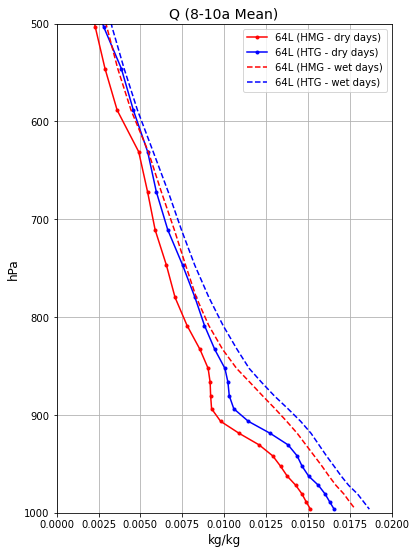

In [36]:
## Plot vertical profiles 

varSel = 'Q'

fig,axs = plt.subplots(1,1, figsize=(6,9))

axs.plot(np.squeeze(hourlyMean_localDryMorning_HMG[varSel].values), 
         hourlyMean_localDryMorning_HMG.lev.values,'r.-',label='64L (HMG - dry days)')
axs.plot(np.squeeze(hourlyMean_localDryMorning_HTG[varSel].values), 
         hourlyMean_localDryMorning_HTG.lev.values,'b.-',label='64L (HTG - dry days)')

if plotWetDay=='true':
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HMG[varSel].values), 
         hourlyMean_localWetMorning_HMG.lev.values,'r--',label='64L (HMG - wet days)')
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HTG[varSel].values), 
             hourlyMean_localWetMorning_HTG.lev.values,'b--',label='64L (HTG - wet days)')
    
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' (8-10a Mean)',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()

axs.set_ylim([1000,500])
axs.set_xlim([0.0, 0.02])



(0.0, 10.0)

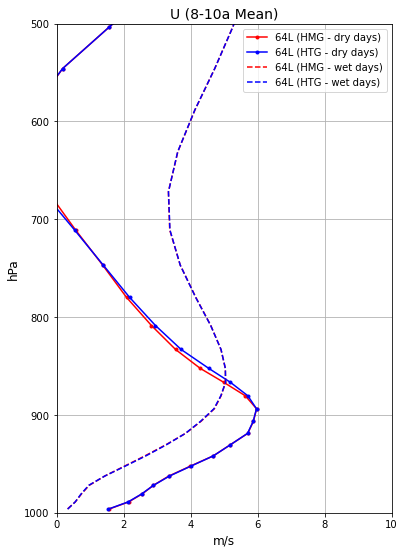

In [37]:
## Plot vertical profiles 

varSel = 'U'

fig,axs = plt.subplots(1,1, figsize=(6,9))

axs.plot(np.squeeze(hourlyMean_localDryMorning_HMG[varSel].values), 
         hourlyMean_localDryMorning_HMG.lev.values,'r.-',label='64L (HMG - dry days)')
axs.plot(np.squeeze(hourlyMean_localDryMorning_HTG[varSel].values), 
         hourlyMean_localDryMorning_HTG.lev.values,'b.-',label='64L (HTG - dry days)')

if plotWetDay=='true':
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HMG[varSel].values), 
         hourlyMean_localWetMorning_HMG.lev.values,'r--',label='64L (HMG - wet days)')
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HTG[varSel].values), 
             hourlyMean_localWetMorning_HTG.lev.values,'b--',label='64L (HTG - wet days)')
    
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' (8-10a Mean)',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()

axs.set_ylim([1000,500])
axs.set_xlim([0.0, 10])




(1000.0, 500.0)

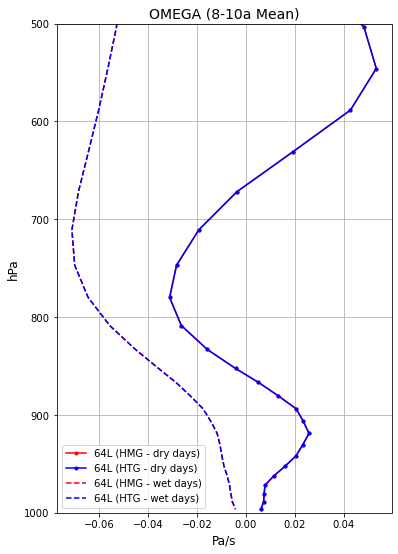

In [38]:
## Plot vertical profiles 

varSel = 'OMEGA'

fig,axs = plt.subplots(1,1, figsize=(6,9))

axs.plot(np.squeeze(hourlyMean_localDryMorning_HMG[varSel].values), 
         hourlyMean_localDryMorning_HMG.lev.values,'r.-',label='64L (HMG - dry days)')
axs.plot(np.squeeze(hourlyMean_localDryMorning_HTG[varSel].values), 
         hourlyMean_localDryMorning_HTG.lev.values,'b.-',label='64L (HTG - dry days)')

if plotWetDay=='true':
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HMG[varSel].values), 
         hourlyMean_localWetMorning_HMG.lev.values,'r--',label='64L (HMG - wet days)')
    axs.plot(np.squeeze(hourlyMean_localWetMorning_HTG[varSel].values), 
             hourlyMean_localWetMorning_HTG.lev.values,'b--',label='64L (HTG - wet days)')
    
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' (8-10a Mean)',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()

axs.set_ylim([1000,500])
# axs.set_xlim([0.0, 10])





#### What about means over late morning? 

In [72]:
## Get late morning-mean arrays (10a-1p)

iLateMornings_HMG = np.where((hourlyMean_localDry_HMG.hour>=10) & 
                           (hourlyMean_localDry_HMG.hour<13))[0]
iLateMornings_HTG = np.where((hourlyMean_localDry_HTG.hour>=10) & 
                           (hourlyMean_localDry_HTG.hour<13))[0]

hourlyMean_localDryLateMorning_HMG = hourlyMean_localDry_HMG.isel(hour=iLateMornings_HMG).mean(dim='hour')
hourlyMean_localDryLateMorning_HTG = hourlyMean_localDry_HTG.isel(hour=iLateMornings_HTG).mean(dim='hour')

(-0.004, 0.1)

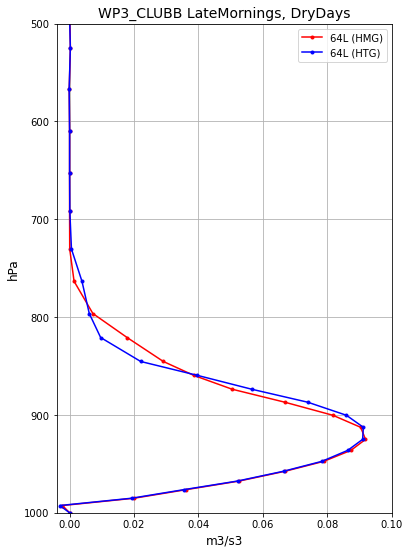

In [77]:
## Plot vertical profiles 

varSel = 'WP3_CLUBB'

fig,axs = plt.subplots(1,1, figsize=(6,9))

axs.plot(np.squeeze(hourlyMean_localDryLateMorning_HMG[varSel].values), 
         hourlyMean_localDryLateMorning_HMG.ilev.values,'r.-',label='64L (HMG)')
axs.plot(np.squeeze(hourlyMean_localDryLateMorning_HTG[varSel].values), 
         hourlyMean_localDryLateMorning_HTG.ilev.values,'b.-',label='64L (HTG)')
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' LateMornings, DryDays',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()

axs.set_ylim([1000,500])
axs.set_xlim([-0.004, 0.1])



(0.0, 1.8)

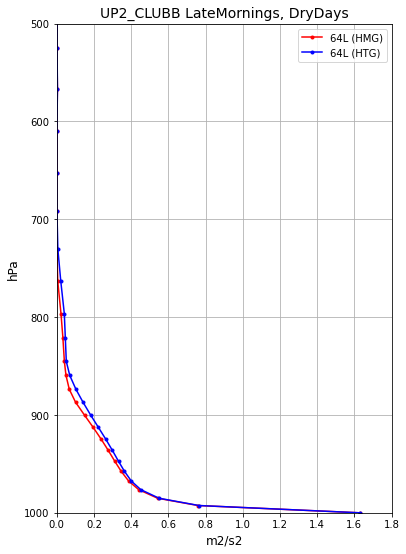

In [79]:
## Plot vertical profiles 

varSel = 'UP2_CLUBB'

fig,axs = plt.subplots(1,1, figsize=(6,9))

axs.plot(np.squeeze(hourlyMean_localDryLateMorning_HMG[varSel].values), 
         hourlyMean_localDryLateMorning_HMG.ilev.values,'r.-',label='64L (HMG)')
axs.plot(np.squeeze(hourlyMean_localDryLateMorning_HTG[varSel].values), 
         hourlyMean_localDryLateMorning_HTG.ilev.values,'b.-',label='64L (HTG)')
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' LateMornings, DryDays',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()

axs.set_ylim([1000,500])
axs.set_xlim([0, 1.8])





(-0.1, 0.04)

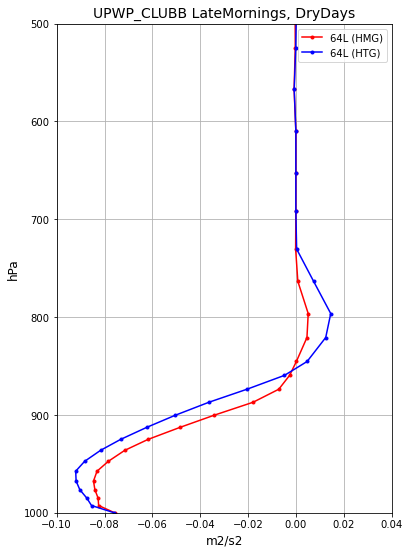

In [80]:
## Plot vertical profiles 

varSel = 'UPWP_CLUBB'

fig,axs = plt.subplots(1,1, figsize=(6,9))

axs.plot(np.squeeze(hourlyMean_localDryLateMorning_HMG[varSel].values), 
         hourlyMean_localDryLateMorning_HMG.ilev.values,'r.-',label='64L (HMG)')
axs.plot(np.squeeze(hourlyMean_localDryLateMorning_HTG[varSel].values), 
         hourlyMean_localDryLateMorning_HTG.ilev.values,'b.-',label='64L (HTG)')
axs.invert_yaxis()
axs.legend()
axs.set_title(varSel+' LateMornings, DryDays',fontsize=14)
axs.set_xlabel(HMGcamDS_all[varSel].units,fontsize=12)
axs.set_ylabel('hPa',fontsize=12)
axs.grid()

axs.set_ylim([1000,500])
axs.set_xlim([-0.1, 0.04])



### Veritcal info

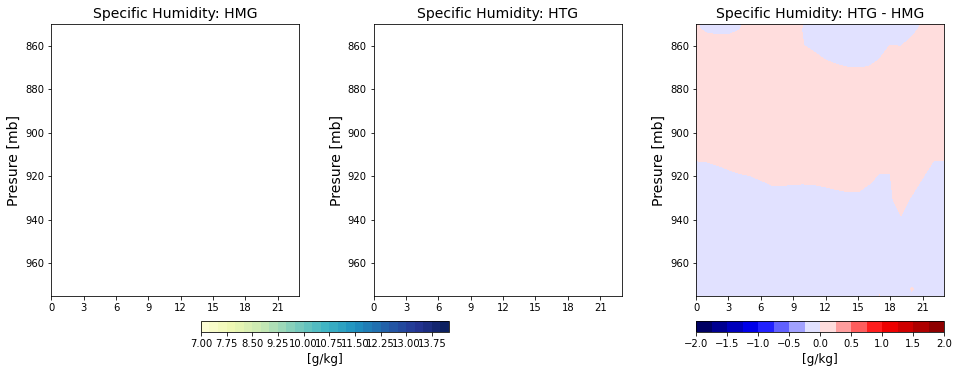

In [29]:
fig, axs_all = plt.subplots(1,3, figsize=(16, 5),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.6,wspace=0.3)

Qlevs = np.arange(7.0,14.5,0.25)
Qdiff_levs = np.arange(-2,2.25,0.25)


contour_plot = axs[0].contourf(hourlyMean_HMG.hour.values,hourlyMean_HMG.lev.values, 
                       np.transpose(np.squeeze(hourlyMean_HMG.Q.values)*1000.0), Qlevs,
                      cmap='YlGnBu')
axs[0].set_ylim([850,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('Specific Humidity: HMG', fontsize=14)
axs[0].invert_yaxis()

contour_plot = axs[1].contourf(hourlyMean_HTG.hour.values,hourlyMean_HTG.lev.values, 
                       np.transpose(np.squeeze(hourlyMean_HTG.Q.values)*1000.0), Qlevs,
                      cmap='YlGnBu')
axs[1].set_ylim([850,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_ylabel('Presure [mb]',fontsize=14)
axs[1].set_title('Specific Humidity: HTG', fontsize=14)
axs[1].invert_yaxis()

# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[g/kg]',fontsize=12)


# Plot difference 
contour_plot = axs[2].contourf(hourlyMean_HTG.hour.values,hourlyMean_HTG.lev.values, 
                       np.transpose(np.squeeze(hourlyMean_HTG.Q.values)*1000.0 - np.squeeze(hourlyMean_HMG.Q.values)*1000.0), 
                       Qdiff_levs,
                       cmap='seismic')
axs[2].set_ylim([850,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_ylabel('Presure [mb]',fontsize=14)
axs[2].set_title('Specific Humidity: HTG - HMG', fontsize=14)
axs[2].invert_yaxis()

# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[g/kg]',fontsize=12)


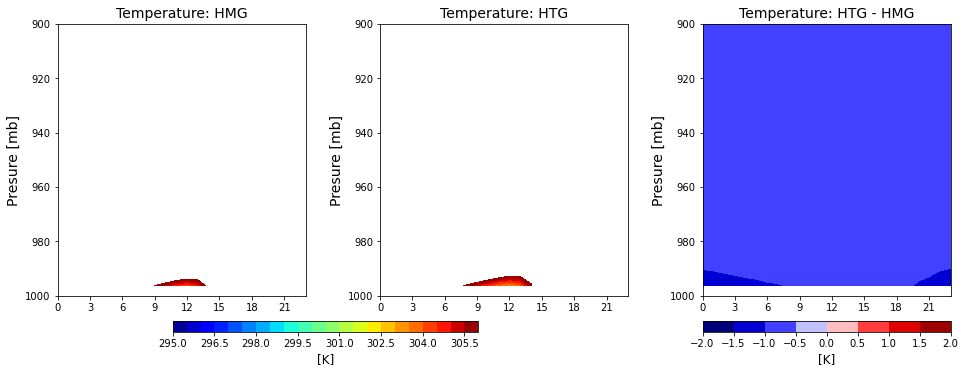

In [30]:
fig, axs_all = plt.subplots(1,3, figsize=(16, 5),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.6, wspace=0.3)

Tlevs = np.arange(295,306.5,0.5)
Tdiff_levs = np.arange(-2.0,2.5,0.5)


contour_plot = axs[0].contourf(hourlyMean_HMG.hour.values,hourlyMean_HMG.lev.values, 
                       np.transpose(np.squeeze(hourlyMean_HMG.T.values)), Tlevs,
                      cmap='jet')
axs[0].set_ylim([900,1000])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('Temperature: HMG', fontsize=14)
axs[0].invert_yaxis()
# ax01 = axs[0].twinx()
# ax01.plot(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG.TREFHT.values),'o-', 
#            color = 'white')
# ax01.set_ylim([275,310])
# ax01.set_ylabel('TREFHT [K]')

contour_plot = axs[1].contourf(hourlyMean_HTG.hour.values,hourlyMean_HTG.lev.values, 
                       np.transpose(np.squeeze(hourlyMean_HTG.T.values)), Tlevs,
                      cmap='jet')
axs[1].set_ylim([900,1000])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_ylabel('Presure [mb]',fontsize=14)
axs[1].set_title('Temperature: HTG', fontsize=14)
axs[1].invert_yaxis()

# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.18, ax_position.y0-0.1, ax_position.width+0.05, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[K]',fontsize=12)
# ax01 = axs[1].twinx()
# ax01.plot(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HTG.TREFHT.values),'o-', 
#            color = 'white')
# ax01.set_ylim([275,310])
# ax01.set_ylabel('TREFHT [K]')


# Plot difference 
contour_plot = axs[2].contourf(hourlyMean_HTG.hour.values,hourlyMean_HTG.lev.values, 
                       np.transpose(np.squeeze(hourlyMean_HTG.T.values) - np.squeeze(hourlyMean_HMG.T.values)), 
                       Tdiff_levs,
                       cmap='seismic')
axs[2].set_ylim([900,1000])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_ylabel('Presure [mb]',fontsize=14)
axs[2].set_title('Temperature: HTG - HMG', fontsize=14)
axs[2].invert_yaxis()

# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[K]',fontsize=12)


### Does using 2-day hindcasts rather than a free running simulation make a huge difference?

In [22]:
obsFile = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-hmg.nc'

with xr.open_dataset(obsFile, decode_times=True) as obsDS:
    obsT = obsDS.T_srf.values + 273.15    #Convert C to K


In [18]:
# Where the files are saved (locally):
dataDir64 = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/HindcastTests/FinalOption_defaultSfc_betterFinidat_moreMomentsPlusReorder/'

# File naming conventions: 
hmg_startFile   = 'FSCAM.T42_T42.FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2daySims.Start'  
htg_startFile   = 'FSCAM.T42_T42.FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2daySims.Start'

middleFile64    = '.cam.h0.2015-' # Default 20 min coupling
endFile         = '-84585.nc'

# Month/day also factor into naming convention (since these are run for ~2 days and second day is used)
months    = np.ones(31)*6
months[0] = 5
days      = np.arange(0,31)
days[0]   = 31



In [19]:
# Now read in each daily file, and save the appropriate second day to an xr dataset: 

for iDay in range(29):
    
    if iDay==0:
        hmg64file = dataDir64+'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2daySims.Start0531.cam.h0.2015-05-31-84585.nc'
        htg64file = dataDir64+'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2daySims.Start0531.cam.h0.2015-05-31-84585.nc'
        
    else:
        # Define full file names 
        hmg64file    = dataDir64+hmg_startFile+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile64+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
        htg64file    = dataDir64+htg_startFile+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile64+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile


    # ---------------------- 
    # Read in 64 levels data
    # ----------------------
    # Read in files with homogeneous surface forcing prescribed 
    with xr.open_dataset(hmg64file, decode_times=True) as hmg64_DS:
        hmg64_DS['time']  = hmg64_DS.indexes['time'].to_datetimeindex()

        # Select day: 
        times_hmg  = pd.DatetimeIndex(hmg64_DS['time'].values)
        iTimeStart = np.where((times_hmg.day==days[iDay+1]) & (times_hmg.hour==6))[0]
        iTimeEnd   = np.where((times_hmg.day==days[iDay+2]) & (times_hmg.hour==6))[0]
        iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])

        if iDay==0:
            hmgDS_64 = hmg64_DS.isel(time=iTimeRange)
        else:
            hmgDS_64 = xr.concat([hmgDS_64,hmg64_DS.isel(time=iTimeRange)], dim='time')


    # Read in files with heterogeneous surface forcing prescribed     
    with xr.open_dataset(htg64file, decode_times=True) as htg64_DS:
        htg64_DS['time']  = htg64_DS.indexes['time'].to_datetimeindex()

        # Select day: 
        times_htg  = pd.DatetimeIndex(htg64_DS['time'].values)
        iTimeStart = np.where((times_htg.day==days[iDay+1]) & (times_htg.hour==6))[0]
        iTimeEnd   = np.where((times_htg.day==days[iDay+2]) & (times_htg.hour==6))[0]
        iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])

        if iDay==0:
            htgDS_64 = htg64_DS.isel(time=iTimeRange)
        else:
            htgDS_64 = xr.concat([htgDS_64,htg64_DS.isel(time=iTimeRange)], dim='time')


    print('Done with day %i' % iDay)


Done with day 0
Done with day 1
Done with day 2
Done with day 3
Done with day 4
Done with day 5
Done with day 6
Done with day 7
Done with day 8
Done with day 9
Done with day 10
Done with day 11
Done with day 12
Done with day 13
Done with day 14
Done with day 15
Done with day 16
Done with day 17
Done with day 18
Done with day 19
Done with day 20
Done with day 21
Done with day 22
Done with day 23
Done with day 24
Done with day 25
Done with day 26
Done with day 27
Done with day 28


(278.0, 325.0)

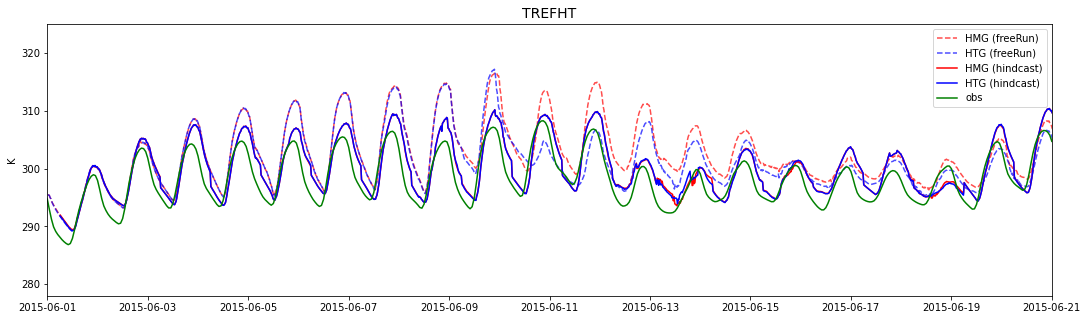

In [25]:
fig,ax1 = plt.subplots(1,1, figsize=(18,5))

ax1.plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all['TREFHT'].values),
              'r--', alpha=0.7, label='HMG (freeRun)')
ax1.plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all['TREFHT'].values),
              'b--', alpha=0.7, label='HTG (freeRun)')
ax1.plot(hmgDS_64.time.values, np.squeeze(hmgDS_64.TREFHT.values),'r',label='HMG (hindcast)')
ax1.plot(htgDS_64.time.values, np.squeeze(htgDS_64.TREFHT.values),'b',label='HTG (hindcast)')

ax1.plot(obsDS.time.values, obsT, 'g', label='obs')

ax1.set_title('TREFHT',fontsize=14)
ax1.set_ylabel(HMGcamDS['TREFHT'].units)
ax1.legend()
ax1.set_xlim([datetime.date(2015,6,1), datetime.date(2015,6,21)])
ax1.set_ylim([278,325])


(16587.0, 16607.0)

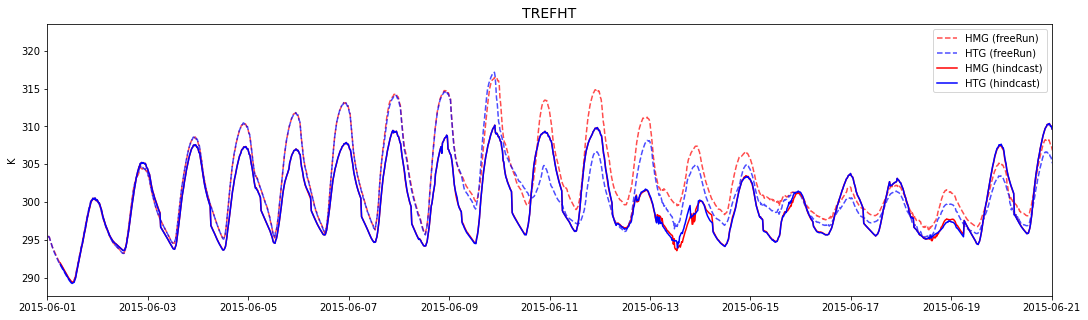

In [32]:
fig,ax1 = plt.subplots(1,1, figsize=(18,5))

ax1.plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all['TREFHT'].values),
              'r--', alpha=0.7, label='HMG (freeRun)')
ax1.plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all['TREFHT'].values),
              'b--', alpha=0.7, label='HTG (freeRun)')
ax1.plot(hmgDS_64.time.values, np.squeeze(hmgDS_64.TREFHT.values),'r',label='HMG (hindcast)')
ax1.plot(htgDS_64.time.values, np.squeeze(htgDS_64.TREFHT.values),'b',label='HTG (hindcast)')


ax1.set_title('TREFHT',fontsize=14)
ax1.set_ylabel(HMGcamDS['TREFHT'].units)
ax1.legend()
ax1.set_xlim([datetime.date(2015,6,1), datetime.date(2015,6,21)])





(16587.0, 16607.0)

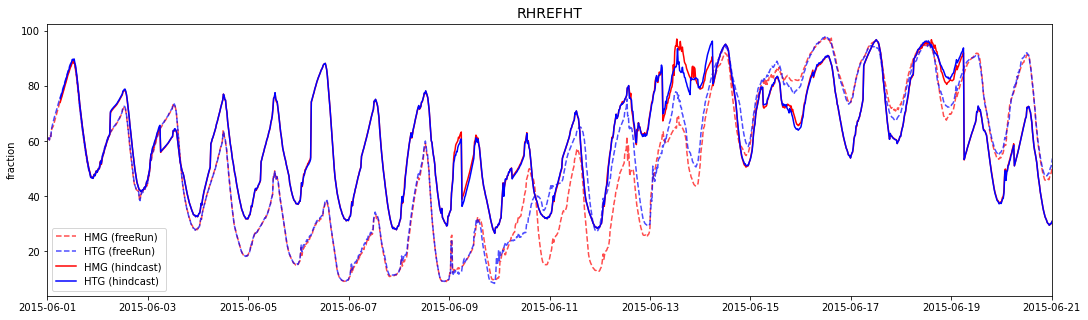

In [33]:
fig,ax1 = plt.subplots(1,1, figsize=(18,5))

ax1.plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all['RHREFHT'].values),
              'r--', alpha=0.7, label='HMG (freeRun)')
ax1.plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all['RHREFHT'].values),
              'b--', alpha=0.7, label='HTG (freeRun)')
ax1.plot(hmgDS_64.time.values, np.squeeze(hmgDS_64.RHREFHT.values),'r',label='HMG (hindcast)')
ax1.plot(htgDS_64.time.values, np.squeeze(htgDS_64.RHREFHT.values),'b',label='HTG (hindcast)')

# ax1.plot(obsDS.time.values, obsDS.RH_srf.values, 'g', label = 'Obs')

ax1.set_title('RHREFHT',fontsize=14)
ax1.set_ylabel(HMGcamDS['RHREFHT'].units)
ax1.legend()
ax1.set_xlim([datetime.date(2015,6,1), datetime.date(2015,6,21)])


(16587.0, 16607.0)

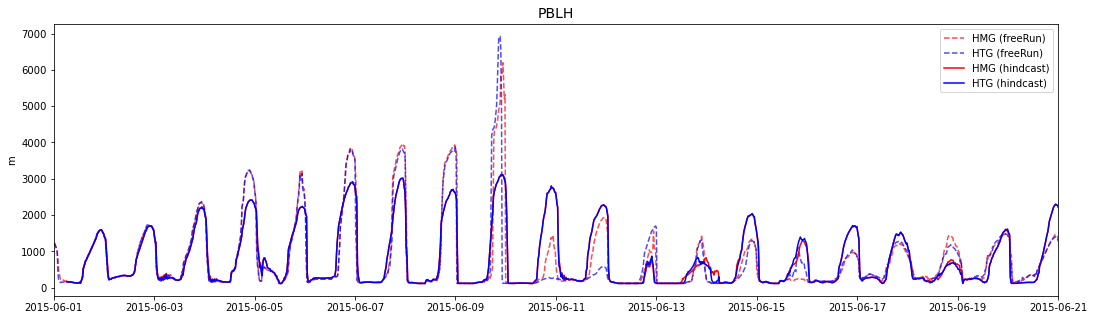

In [30]:
fig,ax1 = plt.subplots(1,1, figsize=(18,5))

ax1.plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all['PBLH'].values),
              'r--', alpha=0.7, label='HMG (freeRun)')
ax1.plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all['PBLH'].values),
              'b--', alpha=0.7, label='HTG (freeRun)')
ax1.plot(hmgDS_64.time.values, np.squeeze(hmgDS_64.PBLH.values),'r',label='HMG (hindcast)')
ax1.plot(htgDS_64.time.values, np.squeeze(htgDS_64.PBLH.values),'b',label='HTG (hindcast)')


ax1.set_title('PBLH',fontsize=14)
ax1.set_ylabel(HMGcamDS['PBLH'].units)
ax1.legend()
ax1.set_xlim([datetime.date(2015,6,1), datetime.date(2015,6,21)])






(16587.0, 16607.0)

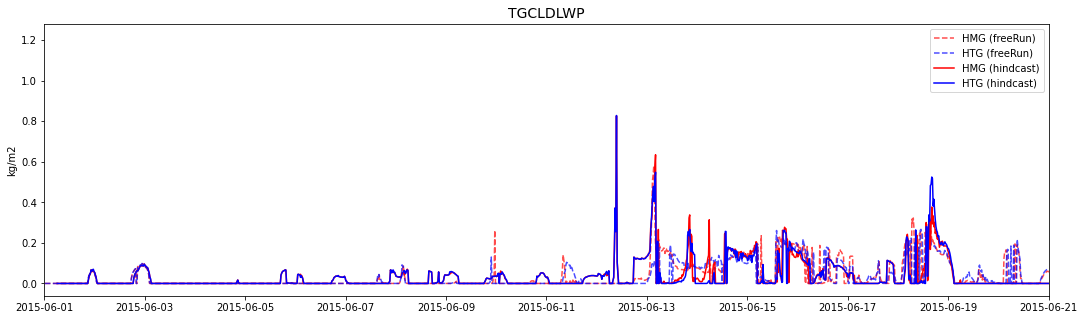

In [31]:
fig,ax1 = plt.subplots(1,1, figsize=(18,5))

ax1.plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all['TGCLDLWP'].values),
              'r--', alpha=0.7, label='HMG (freeRun)')
ax1.plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all['TGCLDLWP'].values),
              'b--', alpha=0.7, label='HTG (freeRun)')
ax1.plot(hmgDS_64.time.values, np.squeeze(hmgDS_64.TGCLDLWP.values),'r',label='HMG (hindcast)')
ax1.plot(htgDS_64.time.values, np.squeeze(htgDS_64.TGCLDLWP.values),'b',label='HTG (hindcast)')


ax1.set_title('TGCLDLWP',fontsize=14)
ax1.set_ylabel(HMGcamDS['TGCLDLWP'].units)
ax1.legend()
ax1.set_xlim([datetime.date(2015,6,1), datetime.date(2015,6,21)])







### Is it the temperature nudging...? 

In [34]:
### 
#   Only prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/HindcastTests/'

# Define file names of cam history files
hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_3monthSim.RelaxOptions.001.cam.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_3monthSim.RelaxOptions.001.cam.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_3monthSim.RelaxOptions.001.cam.h0.2015-08-09-36585.nc'])

htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_3monthSim.RelaxOptions.001.cam.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_3monthSim.RelaxOptions.001.cam.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_3monthSim.RelaxOptions.001.cam.h0.2015-08-09-36585.nc'])

for iFile in range(len(hmgATMfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    
    if iFile==0:
        HTGcamDS_Trelax = HTGcamDS 
        HMGcamDS_Trelax = HMGcamDS
    else: 
        HTGcamDS_Trelax = xr.concat([HTGcamDS_Trelax, HTGcamDS], dim='time')
        HMGcamDS_Trelax = xr.concat([HMGcamDS_Trelax, HMGcamDS], dim='time')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


(16587.0, 16599.0)

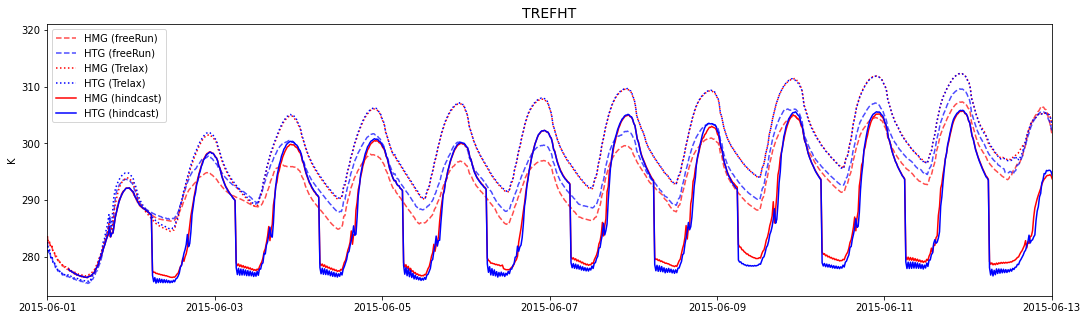

In [36]:
fig,ax1 = plt.subplots(1,1, figsize=(18,5))

ax1.plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all['TREFHT'].values),
              'r--', alpha=0.7, label='HMG (freeRun)')
ax1.plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all['TREFHT'].values),
              'b--', alpha=0.7, label='HTG (freeRun)')

ax1.plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_Trelax['TREFHT'].values),
              'r:', label='HMG (Trelax)')
ax1.plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_Trelax['TREFHT'].values),
              'b:', label='HTG (Trelax)')

ax1.plot(hmgDS_64.time.values, np.squeeze(hmgDS_64.TREFHT.values),'r',label='HMG (hindcast)')
ax1.plot(htgDS_64.time.values, np.squeeze(htgDS_64.TREFHT.values),'b',label='HTG (hindcast)')


ax1.set_title('TREFHT',fontsize=14)
ax1.set_ylabel(HMGcamDS['TREFHT'].units)
ax1.legend()
ax1.set_xlim([datetime.date(2015,6,1), datetime.date(2015,6,13)])


### Does the first month match up with a 1-month experiment, where all the changes are merged into repo's? 

In [29]:
### 
#   Only prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/wstar_tests/'

# Define file names of cam history files
hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HMG.confirmGitMerge.cam.h0.2015-05-31-84585.nc'])

htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HTG.confirmGitMerge.cam.h0.2015-05-31-84585.nc'])

for iFile in range(len(htgATMfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
    
    if iFile==0:
        HTGcamDS_gitMerge = HTGcamDS 
        HMGcamDS_gitMerge = HMGcamDS

    else: 
        HTGcamDS_gitMerge = xr.concat([HTGcamDS_gitMerge, HTGcamDS], dim='time')
        HMGcamDS_gitMerge = xr.concat([HMGcamDS_gitMerge, HMGcamDS], dim='time')
        
    print('Done reading in file %i of %i' % (iFile+1, len(htgATMfiles)))
    

Done reading in file 1 of 1


In [32]:
## Discard the first 2 days... 
iTimeStart   = np.where(HMGcamDS_gitMerge.time.values >= np.datetime64('2015-06-02'))[0]
timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_gitMerge.time.values))

HTGcamDS_gitMerge = HTGcamDS_gitMerge.isel(time=timeArr)
HMGcamDS_gitMerge = HMGcamDS_gitMerge.isel(time=timeArr)


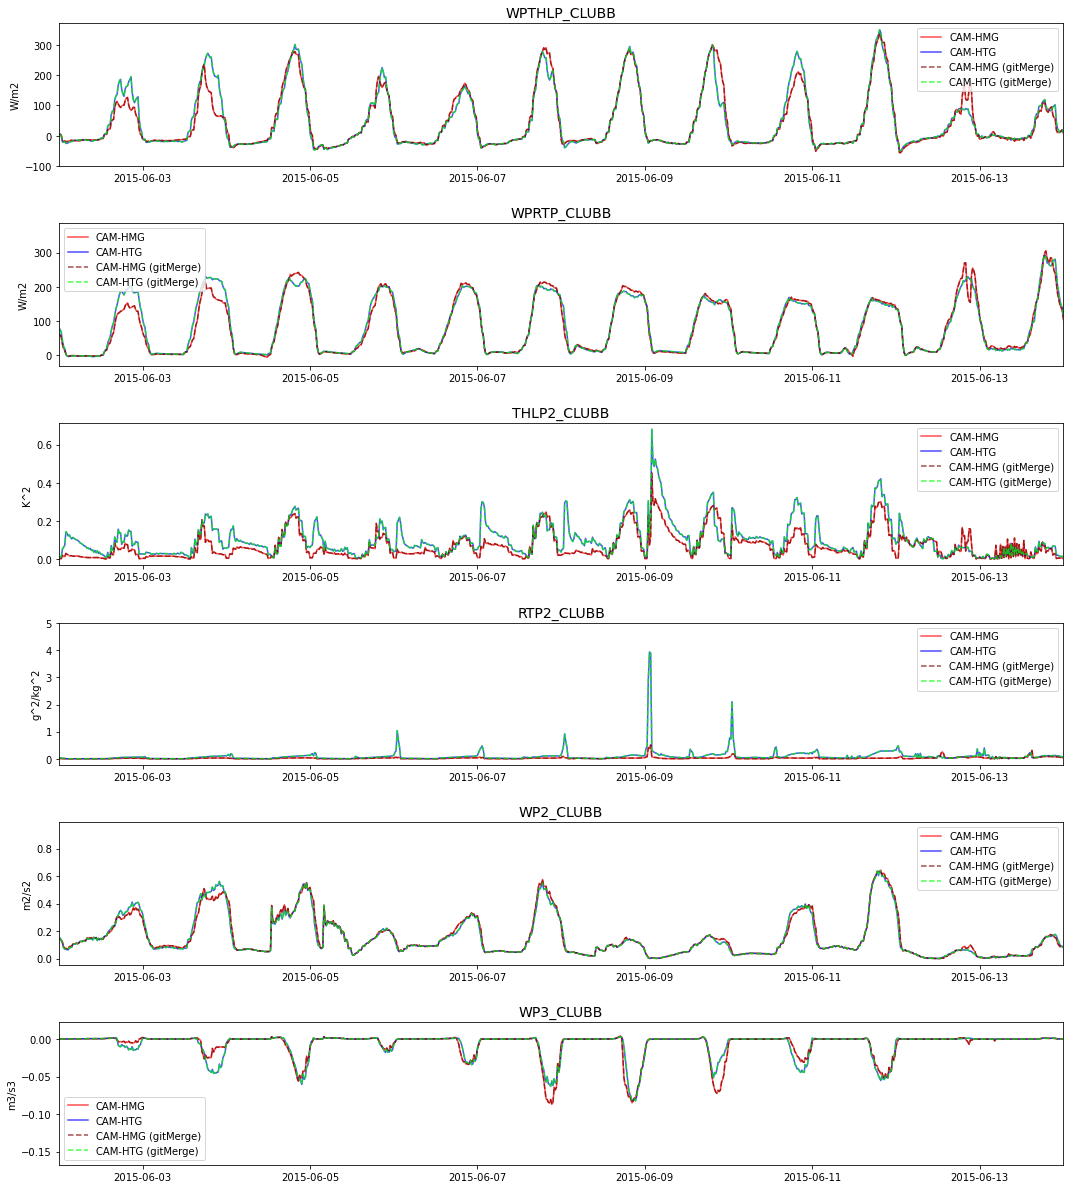

In [84]:
fig,axs = plt.subplots(6,1, figsize=(18,21))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

ATM_varNames = np.asarray(['WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','RTP2_CLUBB','WP2_CLUBB','WP3_CLUBB'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):
        
    if ATM_varNames[iVar]=='WP3_CLUBB':
        axs[iVar].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames[iVar]].values)[:,-2],
                  'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames[iVar]].values)[:,-2],
                  'b-', alpha=0.7, label='CAM-HTG')
        
        axs[iVar].plot(HMGcamDS_gitMerge['time'].values, np.squeeze(HMGcamDS_gitMerge[ATM_varNames[iVar]].values)[:,-2],
                  '--',color='maroon', alpha=0.7, label='CAM-HMG (gitMerge)')
        axs[iVar].plot(HTGcamDS_gitMerge['time'].values, np.squeeze(HTGcamDS_gitMerge[ATM_varNames[iVar]].values)[:,-2],
                  '--',color='lime', alpha=0.7, label='CAM-HTG (gitMerge)')
        
    else: 
        axs[iVar].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames[iVar]].values)[:,-1],
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames[iVar]].values)[:,-1],
                      'b-', alpha=0.7, label='CAM-HTG')
        
        axs[iVar].plot(HMGcamDS_gitMerge['time'].values, np.squeeze(HMGcamDS_gitMerge[ATM_varNames[iVar]].values)[:,-1],
                  '--',color='maroon', alpha=0.7, label='CAM-HMG (gitMerge)')
        axs[iVar].plot(HTGcamDS_gitMerge['time'].values, np.squeeze(HTGcamDS_gitMerge[ATM_varNames[iVar]].values)[:,-1],
                  '--',color='lime', alpha=0.7, label='CAM-HTG (gitMerge)')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_ylabel(HMGcamDS_all[ATM_varNames[iVar]].units)
    axs[iVar].legend()
#     axs[iVar].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])
    axs[iVar].set_xlim([datetime.date(2015,6,2), datetime.date(2015,6,14)])


## More idealized experiment
* 25% even split of surface between lake, urban, vegetated (tree), and vegetated (grass)

In [50]:
### 
#   Only prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   Idealized surface: 25% split between lake, urban, tree, and grass. Maximizing heterogeneity 
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/wstar_tests/'

# Define file names of cam history files
hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_onlyThlpRtp_idealizedSfc_HMG.001.cam.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlpRtp_idealizedSfc_HMG.001.cam.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlpRtp_idealizedSfc_HMG.001.cam.h0.2015-08-09-36585.nc'])

htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_onlyThlpRtp_idealizedSfc_HTG.001.cam.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlpRtp_idealizedSfc_HTG.001.cam.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlpRtp_idealizedSfc_HTG.001.cam.h0.2015-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_onlyThlpRtp_idealizedSfc_HMG.001.clm2.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlpRtp_idealizedSfc_HMG.001.clm2.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlpRtp_idealizedSfc_HMG.001.clm2.h0.2015-08-09-36585.nc'])

htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_onlyThlpRtp_idealizedSfc_HTG.001.clm2.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlpRtp_idealizedSfc_HTG.001.clm2.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_onlyThlpRtp_idealizedSfc_HTG.001.clm2.h0.2015-08-09-36585.nc'])

for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_idealized = HTGcamDS 
        HMGcamDS_idealized = HMGcamDS
        HTGclmDS_idealized = HTGclmDS
        HMGclmDS_idealized = HMGclmDS 
    else: 
        HTGcamDS_idealized = xr.concat([HTGcamDS_idealized, HTGcamDS], dim='time')
        HMGcamDS_idealized = xr.concat([HMGcamDS_idealized, HMGcamDS], dim='time')
        HTGclmDS_idealized = xr.concat([HTGclmDS_idealized, HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_idealized = xr.concat([HMGclmDS_idealized, HMGclmDS], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [58]:
## Discard the first 2 days... 
# iTimeStart   = np.where(HTGcamDS_idealized.time.values >= np.datetime64('2015-06-02'))[0]

# Discard the first 1.5 months...? 
iTimeStart   = np.where(HTGcamDS_idealized.time.values >= np.datetime64('2015-07-15'))[0]

timeArr      = np.arange(iTimeStart[0], len(HTGcamDS_idealized.time.values))

HTGcamDS_idealized = HTGcamDS_idealized.isel(time=timeArr)
HMGcamDS_idealized = HMGcamDS_idealized.isel(time=timeArr)

HTGclmDS_idealized = HTGclmDS_idealized.isel(time=timeArr)
HMGclmDS_idealized = HMGclmDS_idealized.isel(time=timeArr)



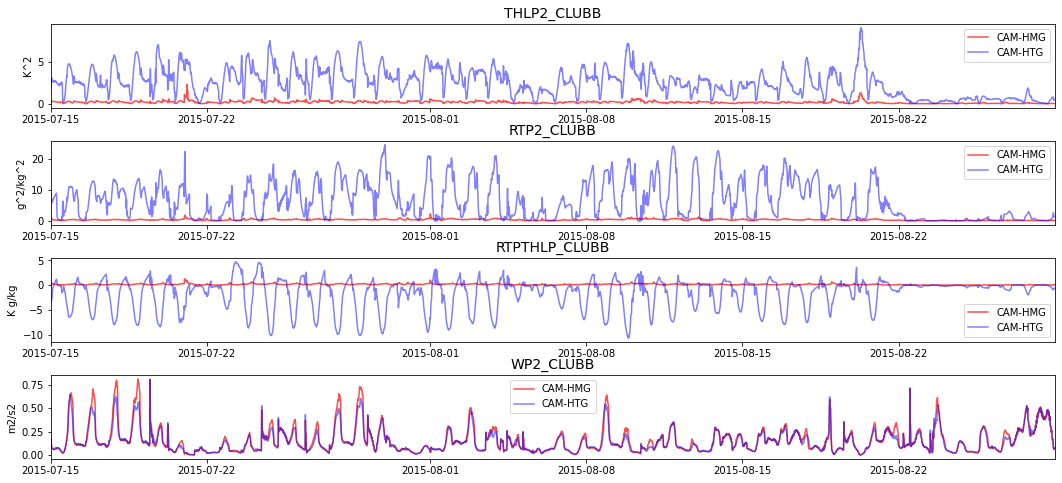

In [60]:
fig,axs = plt.subplots(4,1, figsize=(18,8))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB'])

for iVar in range(4):
    axs[iVar].plot(HMGcamDS_idealized['time'].values, np.squeeze(HMGcamDS_idealized[ATM_varNames[iVar]].values[:,-1,:,:]),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(HTGcamDS_idealized['time'].values, np.squeeze(HTGcamDS_idealized[ATM_varNames[iVar]].values[:,-1,:,:]),
                  'b-', alpha=0.5, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units)
    axs[iVar].legend()
    axs[iVar].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])
    axs[iVar].set_xlim([datetime.date(2015,7,15), datetime.date(2015,8,29)])


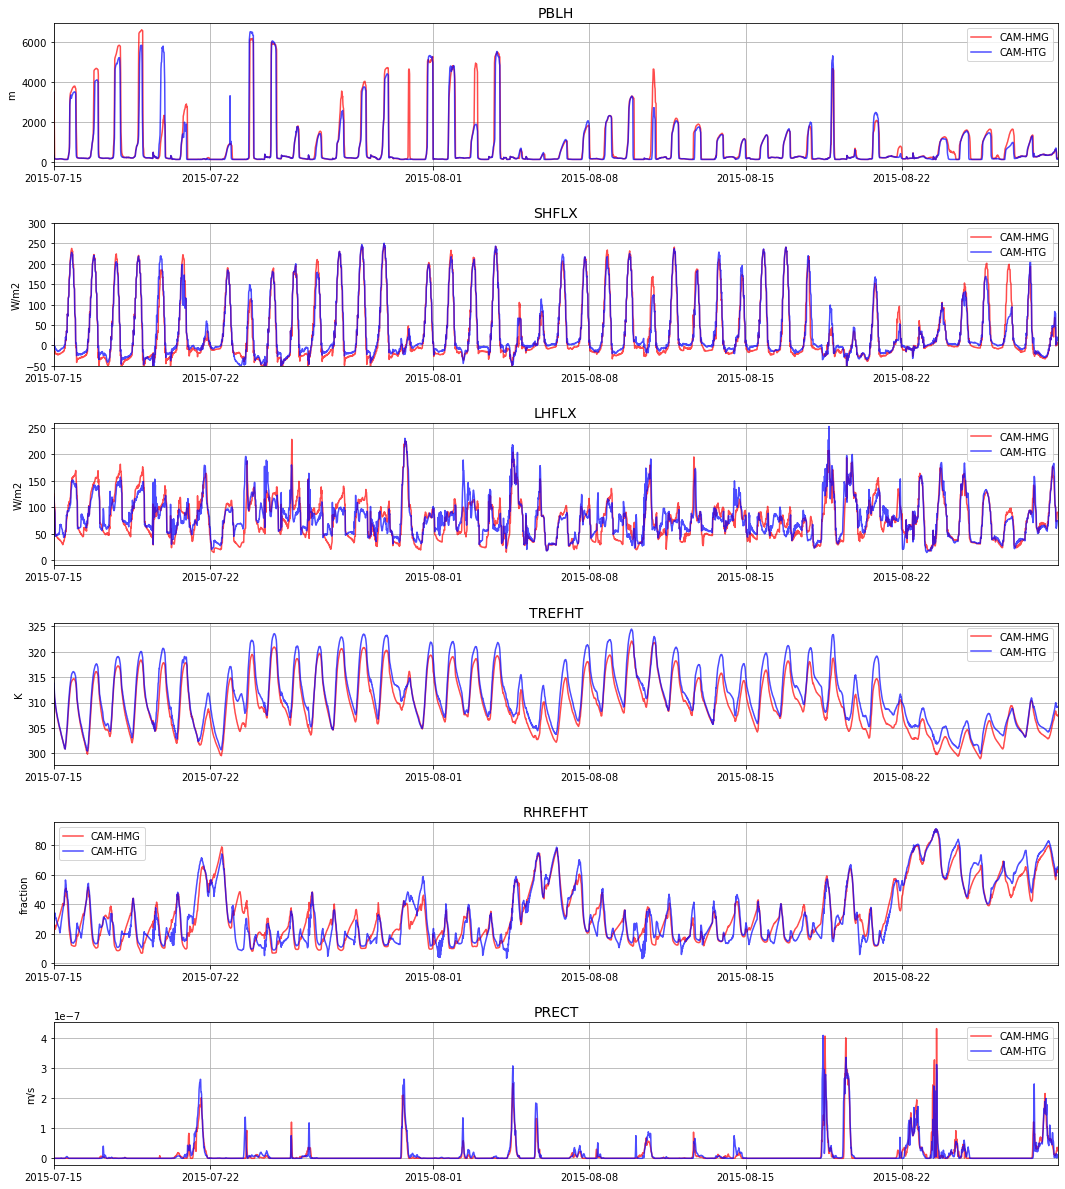

In [69]:
fig,axs = plt.subplots(6,1, figsize=(18,21))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

ATM_varNames = np.asarray(['PBLH','SHFLX','LHFLX','TREFHT','RHREFHT','PRECT'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):
        
    axs[iVar].plot(HMGcamDS_idealized['time'].values, np.squeeze(HMGcamDS_idealized[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(HTGcamDS_idealized['time'].values, np.squeeze(HTGcamDS_idealized[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units)
    axs[iVar].legend()
    axs[iVar].grid()
    axs[iVar].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])
    axs[iVar].set_xlim([datetime.date(2015,7,15), datetime.date(2015,8,29)])
#     axs[iVar].set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,9)])

    if ATM_varNames[iVar]=='SHFLX':
        axs[iVar].set_ylim([-50,300])
    elif ATM_varNames[iVar]=='LHFLX':
        axs[iVar].set_ylim([-10,260])
#     elif ATM_varNames[iVar]=='TREFHT':
#         axs[iVar].set_ylim([270,310])
#     elif ATM_varNames[iVar]=='RHREFHT':
#         axs[iVar].set_ylim([10,120])
        

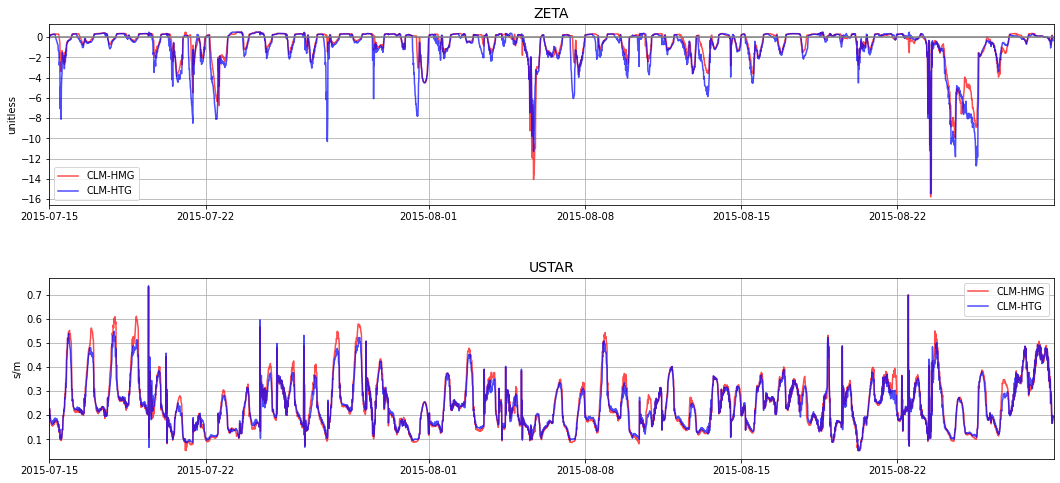

In [70]:
fig,axs = plt.subplots(2,1, figsize=(18,8))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

ATM_varNames = np.asarray(['ZETA','USTAR'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(2):
        
    axs[iVar].plot(HMGclmDS_idealized['time'].values, np.squeeze(HMGclmDS_idealized[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CLM-HMG')
    axs[iVar].plot(HTGclmDS_idealized['time'].values, np.squeeze(HTGclmDS_idealized[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CLM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_ylabel(HMGclmDS[ATM_varNames[iVar]].units)
    axs[iVar].legend()
    axs[iVar].grid()
    axs[iVar].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])
    axs[iVar].set_xlim([datetime.date(2015,7,15), datetime.date(2015,8,29)])
    
    if ATM_varNames[iVar]=='ZETA':
        axs[iVar].axhline(0,color='gray')
        


**Get diurnal cycle?**

In [62]:
# Get means a function of hour of day
hourlyMean_HMGidlz = HMGcamDS_idealized.groupby("time.hour").mean()
hourlyMean_HTGidlz = HTGcamDS_idealized.groupby("time.hour").mean()

hourlyMean_HMGidlz['TBOT'] = (('time','lat','lon'), hourlyMean_HMGidlz.T.values[:,-1,:,:])
hourlyMean_HTGidlz['TBOT'] = (('time','lat','lon'), hourlyMean_HTGidlz.T.values[:,-1,:,:])

hourlyMean_HMGidlz['TBOT'].attrs['units'] = 'K'
hourlyMean_HTGidlz['TBOT'].attrs['units'] = 'K'


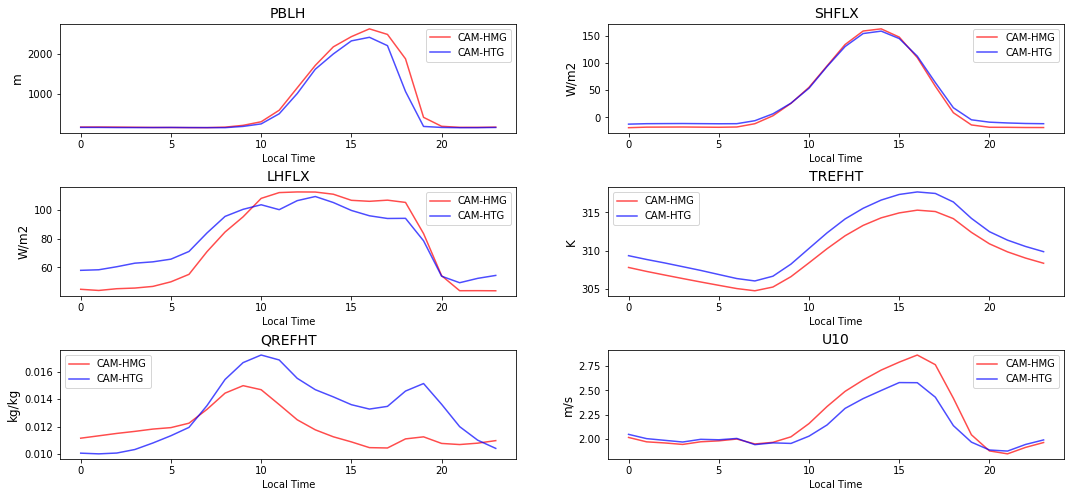

In [63]:
fig,axs = plt.subplots(3,2, figsize=(18,8))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['PBLH','SHFLX','LHFLX','TREFHT','QREFHT','U10'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):
    # Make it show in local time 
    doubleVar_HMG = np.concatenate([np.squeeze(hourlyMean_HMGidlz[ATM_varNames[iVar]].values)[:],np.squeeze(hourlyMean_HMGidlz[ATM_varNames[iVar]].values)[:]])
    doubleVar_HTG = np.concatenate([np.squeeze(hourlyMean_HTGidlz[ATM_varNames[iVar]].values)[:],np.squeeze(hourlyMean_HTGidlz[ATM_varNames[iVar]].values)[:]])
    doubleHour    = np.concatenate([hourlyMean_HMG['hour'].values-5,hourlyMean_HMG['hour'].values-5+24])
       
    axs[iVar].plot(doubleHour[5:29], doubleVar_HMG[5:29],
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(doubleHour[5:29], doubleVar_HTG[5:29],
                  'b-', alpha=0.7, label='CAM-HTG')
    
#     axs[iVar].plot(hourlyMean_HMG['hour'].values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values),
#                   'r-', alpha=0.7, label='CAM-HMG')
#     axs[iVar].plot(hourlyMean_HTG['hour'].values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values),
#                   'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    
    if ATM_varNames[iVar]!='TBOT':
        axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(HMGcamDS['T'].units, fontsize=12)
        